# SOM of Text Dataset

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Mishika\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vectorizing texts...


Applying TF-IDF: 100%|█████████████████████████████████████████████████████████████| 1500/1500 [02:30<00:00,  9.98it/s]


Training SOM...
Data scaling took: 0.001151 seconds.
SOM training took: 0.131963 seconds.


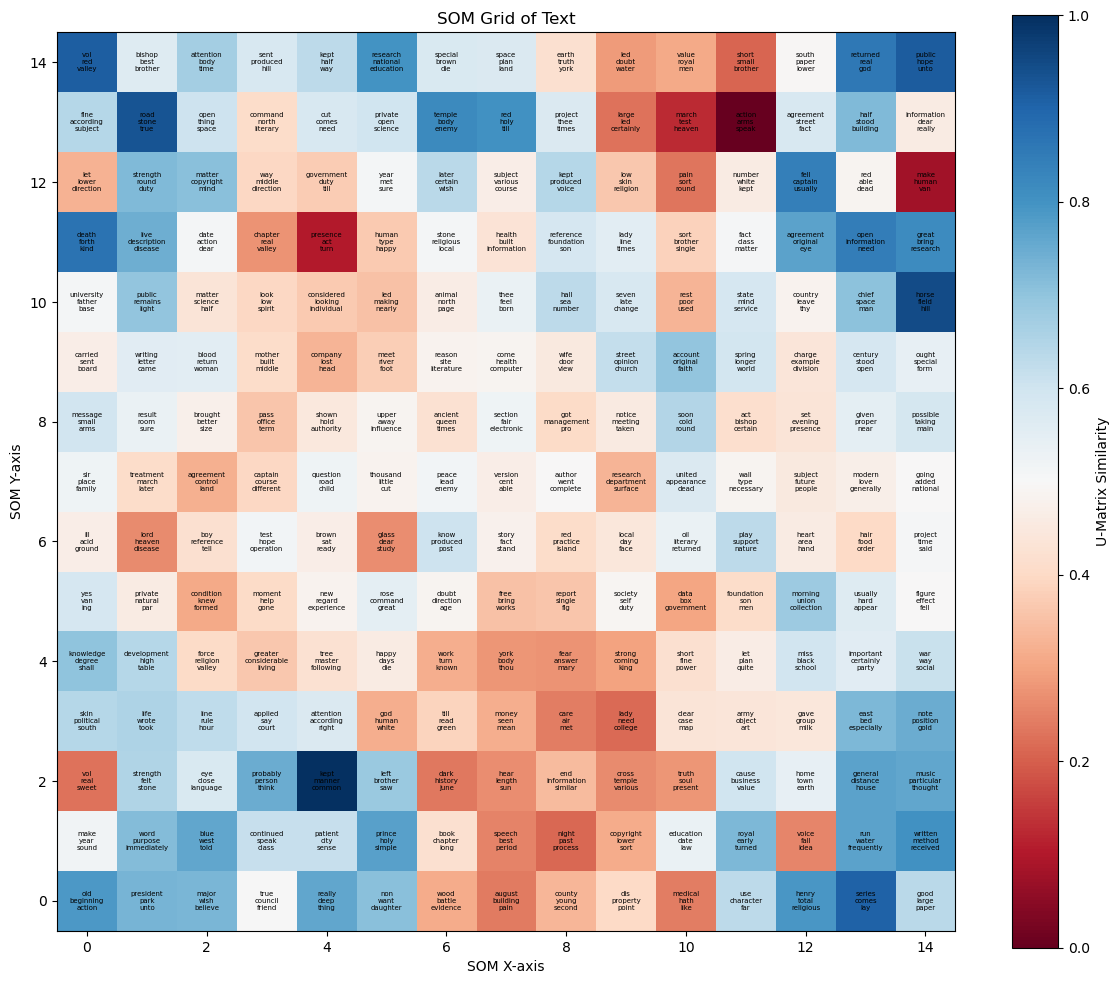


Total Words Displayed on SOM: 500
able, according, account, acid, act, action, added, age, agreement, air, ancient, animal, answer, appear, appearance, applied, area, arms, army, art, attention, august, author, authority, away, base, battle, bed, beginning, believe, best, better, bishop, black, blood, blue, board, body, book, born, box, boy, bring, brother, brought, brown, building, built, business, came, captain, care, carried, case, cause, cent, century, certain, certainly, change, chapter, character, charge, chief, child, church, city, class, clear, close, cold, collection, college, come, comes, coming, command, common, company, complete, computer, condition, considerable, considered, continued, control, copyright, council, country, county, course, court, cross, cut, dark, data, date, daughter, day, days, dead, dear, death, deep, degree, department, description, development, die, different, direction, dis, disease, distance, division, door, doubt, duty, early, earth, east, educatio

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from numbasom import SOM
import nltk
from nltk.corpus import words as nltk_words, stopwords
from tqdm import tqdm
from collections import defaultdict
from random import shuffle, sample

# Ensure nltk resources are available
nltk.download('words')
nltk.download('stopwords')

# ------------------------ 1. Load Texts ------------------------
def load_texts(folder):
    texts = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r", encoding="utf-8", errors="ignore") as f:
                    texts.append(f.read())
    return texts

text_folder = r"OneDrive - University College London/Datasets mlb/Dataset_3 Texts"
texts = load_texts(text_folder)

# ------------------------ 2. TF-IDF + SVD ------------------------
def vectorize_texts(texts, n_components=100):
    print("Vectorizing texts...")
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(tqdm(texts, desc="Applying TF-IDF"))
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_features = svd.fit_transform(tfidf_matrix)
    scaled_features = StandardScaler().fit_transform(reduced_features)
    return scaled_features, tfidf, tfidf_matrix, svd

features_scaled, tfidf_vectorizer, tfidf_matrix, svd_model = vectorize_texts(texts)
feature_names = tfidf_vectorizer.get_feature_names_out()

# ------------------------ 3. Filter Top Words ------------------------
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# ------------------------ 4. Train SOM ------------------------
som_size = (15, 15)
print("Training SOM...")
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# ------------------------ 5. Assign Words to SOM ------------------------
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

# Prepare word vectors
for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = StandardScaler().fit_transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

# Initial assignment of words to BMUs
assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells to ensure exactly 3 words per cell
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

# Fill each cell to exactly 3 words using unused words
for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

# Still underfilled? Fill with random samples from valid words
flat_valid_words = list(set(valid_words))
for cell in all_cells:
    while len(cell_word_map[cell]) < 3:
        word = sample(flat_valid_words, 1)[0]
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

# ------------------------ 6. U-Matrix (no smoothing) ------------------------
u_matrix = np.zeros((som_size[0], som_size[1]))
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = (i + dx) % som_size[0], (j + dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)

u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# ------------------------ 7. Plot U-Matrix and Feature Map ------------------------

# Create the figure for U-Matrix and Feature Map
fig, ax = plt.subplots(figsize=(12, 10))

# U-Matrix plot
cmap = 'RdBu'
cax = ax.imshow(u_matrix, cmap=cmap, origin='lower', interpolation='none')

# Add the words (Feature Map) on top of the U-Matrix
for (i, j), words in cell_word_map.items():
    label = "\n".join(words)
    ax.text(j, i, label, ha='center', va='center', fontsize=5, color='black')

# Colorbar for the U-Matrix plot
plt.colorbar(cax, label='U-Matrix Similarity')

# Set titles and labels
plt.title("SOM Grid of Text")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save U-Matrix + Feature Map Plot
output_path_u_matrix = r"OneDrive - University College London/Datasets mlb/output_datasets all together/som_u_matrix_feature_map.png"
plt.savefig(output_path_u_matrix, dpi=300)
plt.show()

# ------------------------ 8. Display Words ------------------------
displayed_words = sorted({word for words in cell_word_map.values() for word in words})
print(f"\nTotal Words Displayed on SOM: {len(displayed_words)}")
print(", ".join(displayed_words))

# ------------------------ 9. Save TF-IDF Matrix ------------------------
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_save_path = r"OneDrive - University College London/Datasets mlb/output_datasets all together/tfidf.csv"
tfidf_df.to_csv(tfidf_save_path, index=False)
print(f"\nTF-IDF matrix saved to: {tfidf_save_path}")

# ------------------------ 10. Save SOM Model ------------------------
# Save the trained SOM model
som_save_path = r"OneDrive - University College London/Datasets mlb/output_datasets all together/som_model.pkl"
import pickle
with open(som_save_path, 'wb') as f:
    pickle.dump(som, f)
print(f"SOM model saved to: {som_save_path}")

# SOM using BERT 

[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Encoding texts with BERT...


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Training SOM...
Data scaling took: 3.502106 seconds.
SOM training took: 3.503832 seconds.
Encoding top words with BERT...


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

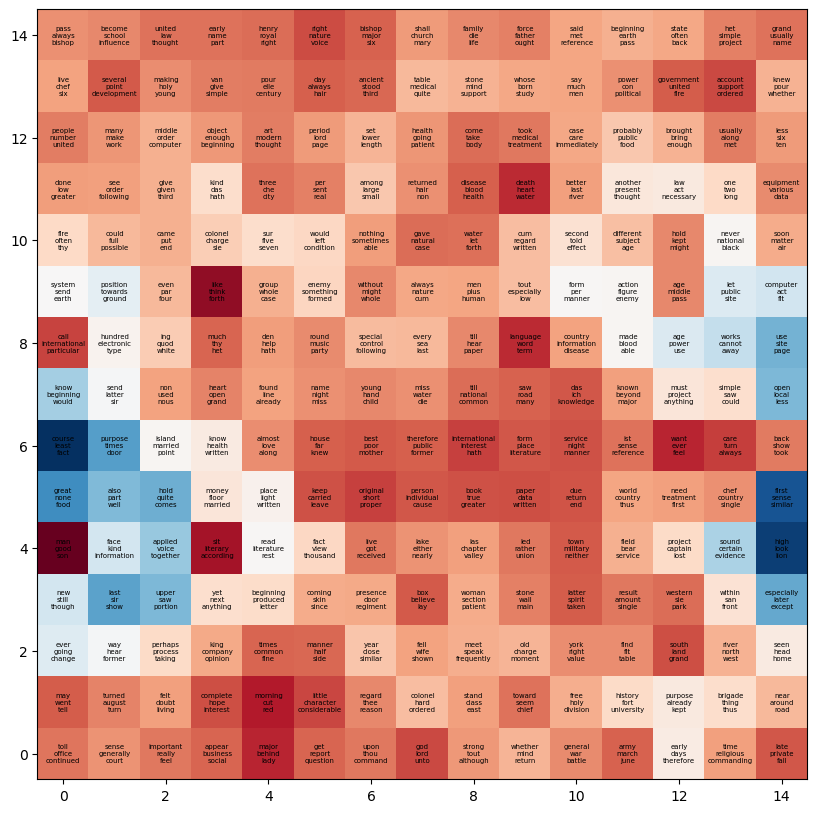

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from numbasom import SOM
import nltk
from nltk.corpus import words as nltk_words, stopwords
from tqdm import tqdm
from collections import defaultdict
from random import shuffle, sample
import pickle

# Download required NLTK data
nltk.download('words')
nltk.download('stopwords')

# ------------------------ 1. Load Texts ------------------------
def load_texts(folder):
    texts = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r", encoding="utf-8", errors="ignore") as f:
                    texts.append(f.read())
    return texts

text_folder = r"OneDrive - University College London/Datasets mlb/Dataset_3 Texts"
texts = load_texts(text_folder)

# ------------------------ 2. BERT Embeddings ------------------------
print("Encoding texts with BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = model.encode(texts, show_progress_bar=True)
features_scaled = StandardScaler().fit_transform(bert_embeddings)

# ------------------------ 3. Filter Top Words ------------------------
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

word_freq = defaultdict(int)
for text in texts:
    for word in text.split():
        word = word.lower()
        if word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2:
            word_freq[word] += 1

top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:500]

# ------------------------ 4. Train SOM ------------------------
som_size = (15, 15)
print("Training SOM...")
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=7000, normalize=True)

# ------------------------ 5. Word Embeddings for Top Words ------------------------
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

print("Encoding top words with BERT...")
word_embeddings = model.encode(top_words)
word_embeddings_scaled = StandardScaler().fit_transform(word_embeddings)

for word, vec in zip(top_words, word_embeddings_scaled):
    word_vectors.append(vec)
    valid_words.append(word)

# Assign words to SOM cells
assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells to ensure exactly 3 words per cell
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

flat_valid_words = list(set(valid_words))
for cell in all_cells:
    while len(cell_word_map[cell]) < 3:
        word = sample(flat_valid_words, 1)[0]
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

# ------------------------ 6. U-Matrix ------------------------
u_matrix = np.zeros((som_size[0], som_size[1]))
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = (i + dx) % som_size[0], (j + dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)

u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# ------------------------ 7. Plot U-Matrix and Feature Map ------------------------
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='none')

for (i, j), words in cell_word_map.items():
    label = "\n".join(words)
    ax.text(j, i, label, ha='center', va='center', fontsize=5, color='black')

plt.colorbar

In [21]:
# tfidf_svd_preprocessing.py

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import nltk

nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

# Load texts
def load_texts(folder):
    texts = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r", encoding="utf-8", errors="ignore") as f:
                    texts.append(f.read())
    return texts

text_folder = r"OneDrive - University College London/Datasets mlb/Dataset_3 Texts"
texts = load_texts(text_folder)

# Vectorize
def vectorize_texts(texts, n_components=100):
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(tqdm(texts, desc="TF-IDF"))
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(tfidf_matrix)
    scaled = StandardScaler().fit_transform(reduced)
    return scaled, tfidf, svd, tfidf_matrix

features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = vectorize_texts(texts)

# Save for SOM usage
import pickle
with open("tfidf_svd_data.pkl", "wb") as f:
    pickle.dump((features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix), f)
print("TF-IDF and SVD preprocessing complete and saved.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!
TF-IDF: 100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [03:59<00:00,  6.25it/s]


TF-IDF and SVD preprocessing complete and saved.


In [39]:
# tfidf_svd_preprocessing.py

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import nltk

nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

# Load texts
def load_texts(folder):
    texts = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r", encoding="utf-8", errors="ignore") as f:
                    texts.append(f.read())
    return texts

text_folder = r"OneDrive - University College London/Datasets mlb/Dataset_3 Texts"
texts = load_texts(text_folder)

# Vectorize
def vectorize_texts(texts, n_components=100):
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(tqdm(texts, desc="TF-IDF"))
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(tfidf_matrix)
    scaled = StandardScaler().fit_transform(reduced)
    return scaled, tfidf, svd, tfidf_matrix

features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = vectorize_texts(texts)

# Save for SOM usage
import pickle
with open("tfidf_svd_data.pkl", "wb") as f:
    pickle.dump((features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix), f)
print("TF-IDF and SVD preprocessing complete and saved.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!
TF-IDF: 100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [03:26<00:00,  7.26it/s]


TF-IDF and SVD preprocessing complete and saved.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001690 seconds.
SOM training took: 0.215281 seconds.

📸 Caption found for query image: "a person is walking down a ramp in a building"

🧭 Full caption BMU location: (4, 9)
📦 Words in that cell: ['work', 'long', 'make']

🔍 Individual caption word mappings:
 - "person" → (4, 9) (words in cell: ['work', 'long', 'make'])
 - "building" → (10, 1) (words in cell: ['wall', 'building', 'produced'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3855037388.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3855037388.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug1.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


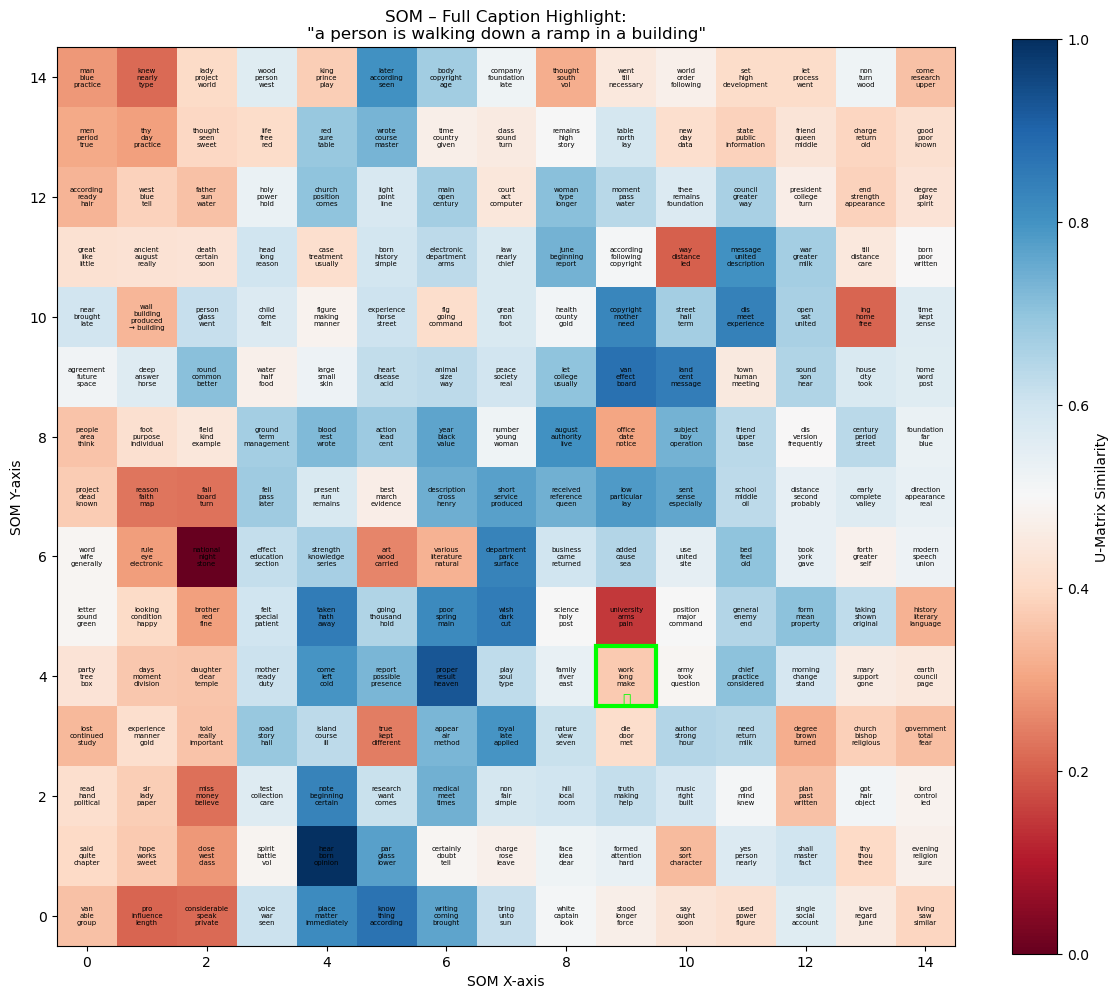

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/005_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug1.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001468 seconds.
SOM training took: 0.204505 seconds.

📸 Caption found for query image: "a large building that has been destroyed and is being demolished"

🧭 Full caption BMU location: (2, 2)
📦 Words in that cell: ['good', 'long', 'works']

🔍 Individual caption word mappings:
 - "large" → (2, 2) (words in cell: ['good', 'long', 'works'])
 - "building" → (2, 2) (words in cell: ['good', 'long', 'works'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3398144020.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3398144020.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug2.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


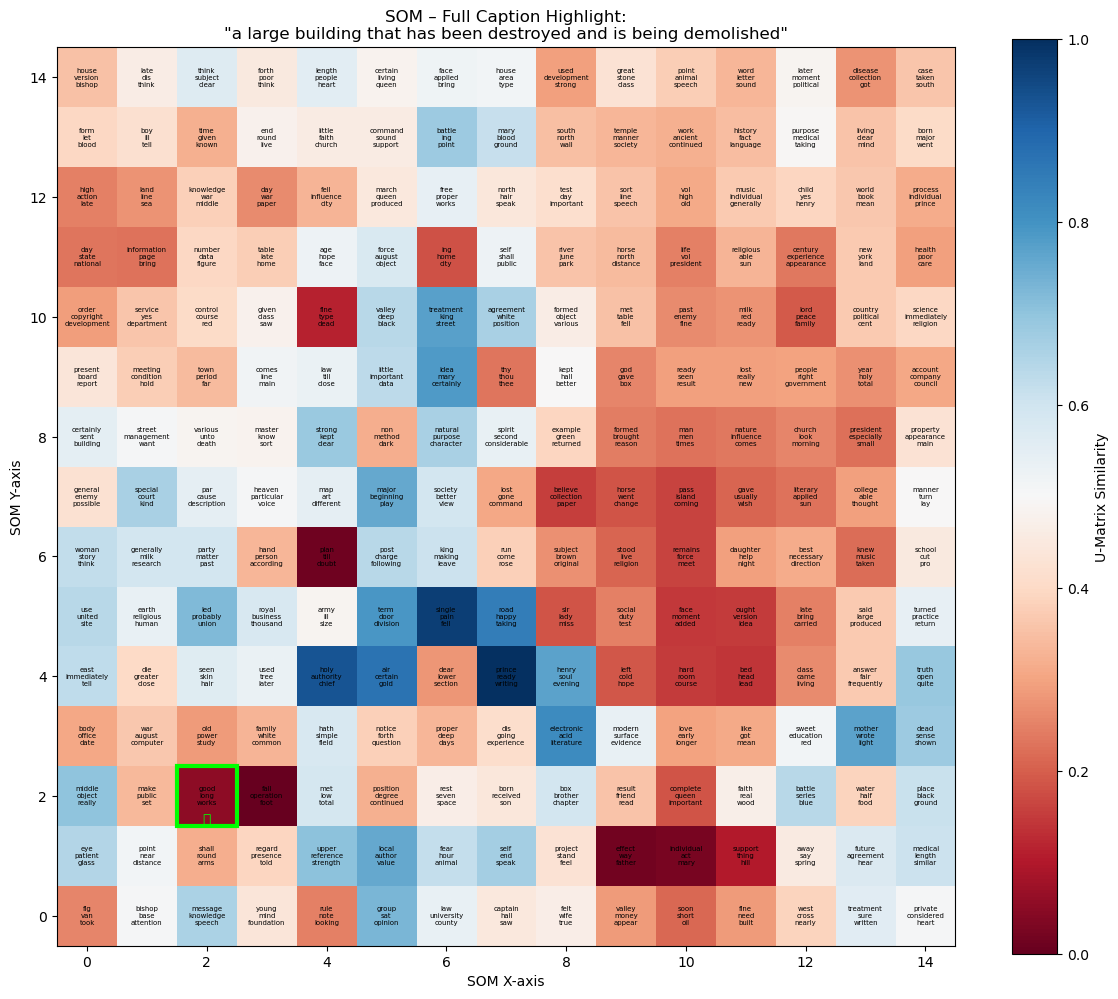

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/178_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug2.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001470 seconds.
SOM training took: 0.182327 seconds.

📸 Caption found for query image: "a couple standing in front of a building"

🧭 Full caption BMU location: (1, 12)
📦 Words in that cell: ['long', 'works', 'way']

🔍 Individual caption word mappings:
 - "building" → (1, 12) (words in cell: ['long', 'works', 'way'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2815505120.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2815505120.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug3.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


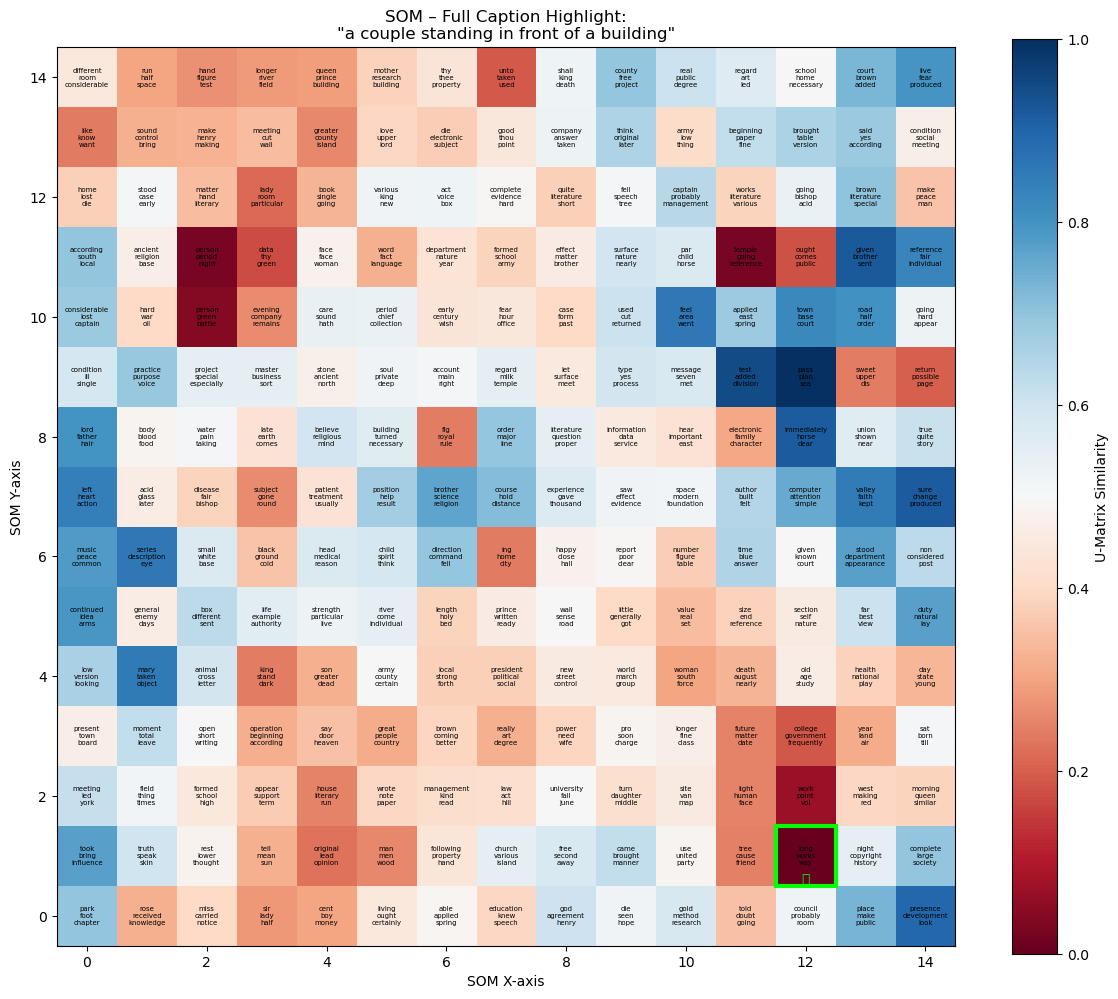

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/092_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug3.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001711 seconds.
SOM training took: 0.205390 seconds.

📸 Caption found for query image: "a castle with a tower and a field"

🧭 Full caption BMU location: (4, 7)
📦 Words in that cell: ['power', 'case', 'head']

🔍 Individual caption word mappings:
 - "field" → (4, 7) (words in cell: ['power', 'case', 'head'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3376694152.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3376694152.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug4.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


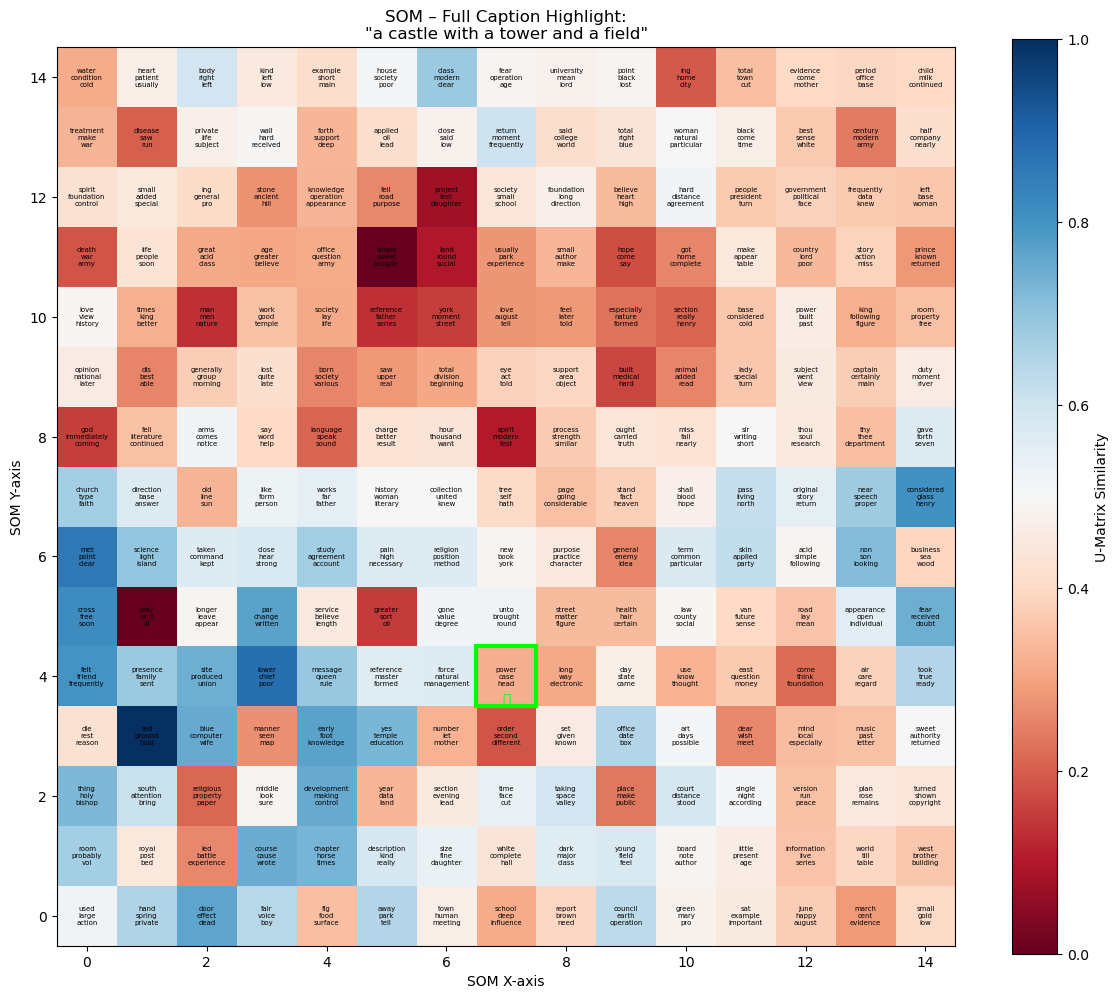

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/image_1448.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug4.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.000904 seconds.
SOM training took: 0.174983 seconds.

📸 Caption found for query image: "the ruins of the world ' s largest nuclear plant"

🧭 Full caption BMU location: (12, 6)
📦 Words in that cell: ['day', 'place', 'long']

🔍 Individual caption word mappings:
 - "world" → (12, 6) (words in cell: ['day', 'place', 'long'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2643948184.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2643948184.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug5.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


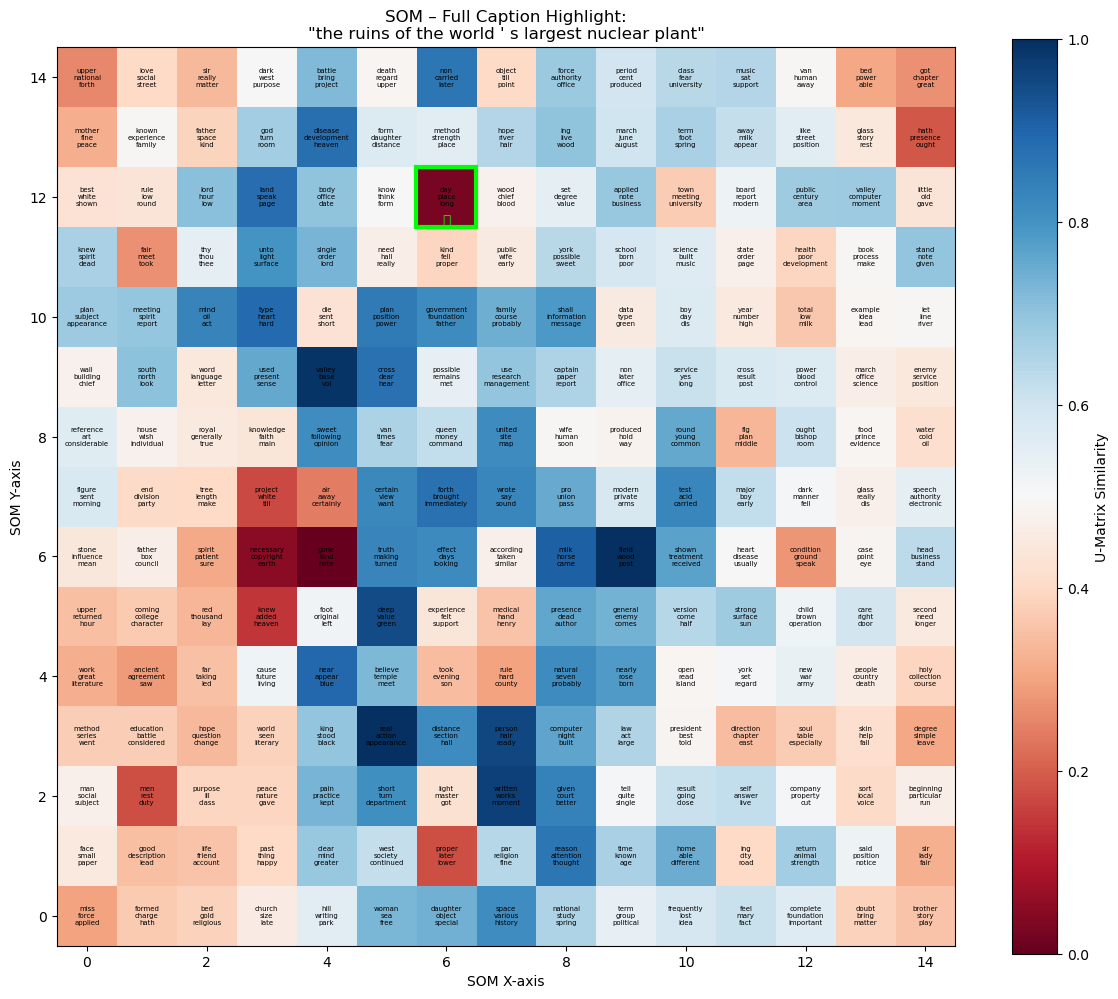

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/145_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug5.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001939 seconds.
SOM training took: 0.209923 seconds.

📸 Caption found for query image: "the robot from the movie"

🧭 Full caption BMU location: (12, 10)
📦 Words in that cell: ['way', 'electronic', 'came']

🔍 Individual caption word mappings:


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3161591027.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3161591027.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug6.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


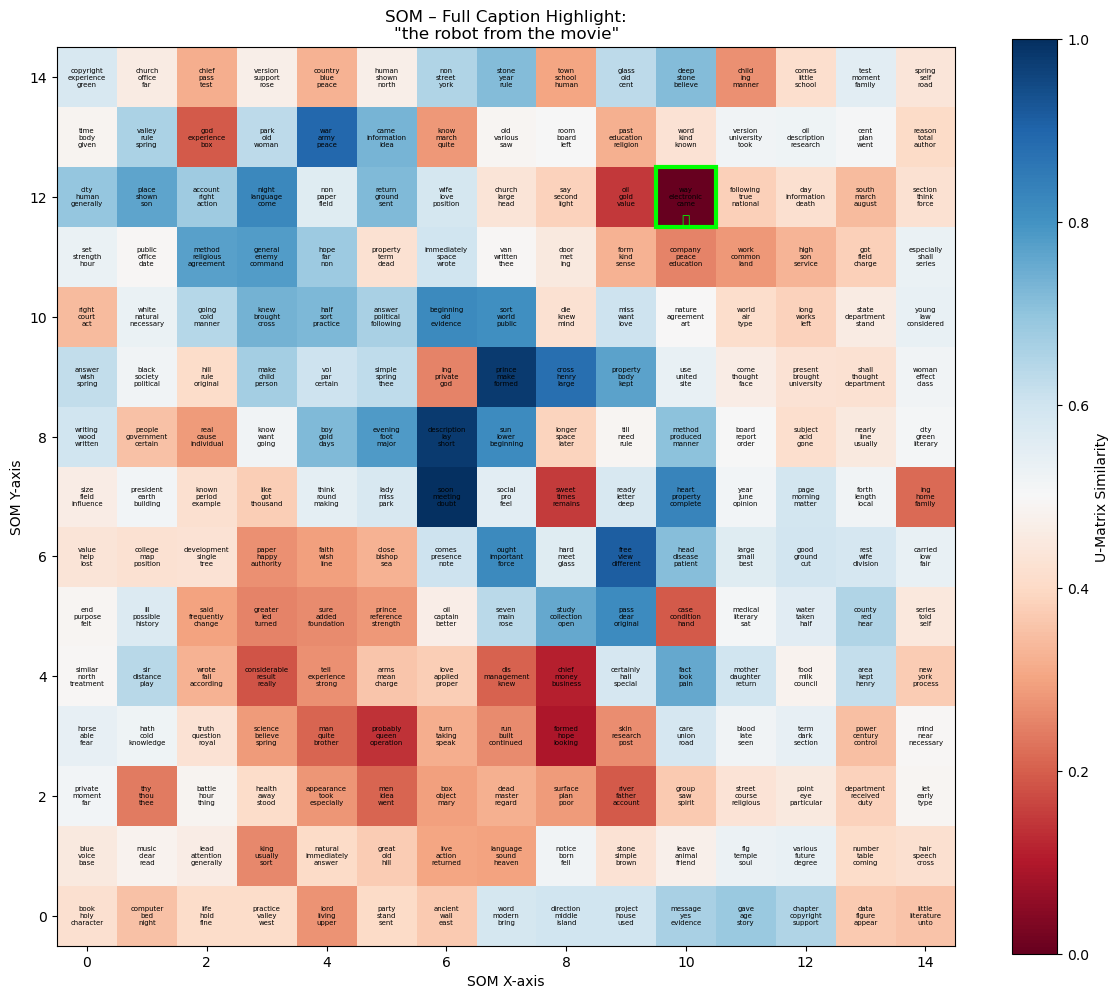

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/037_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug6.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001714 seconds.
SOM training took: 0.204908 seconds.

📸 Caption found for query image: "the roman city of palm, libya"

🧭 Full caption BMU location: (8, 2)
📦 Words in that cell: ['war', 'army', 'peace']

🔍 Individual caption word mappings:
 - "city" → (11, 12) (words in cell: ['ing', 'home', 'city'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\572367690.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\572367690.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug7.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


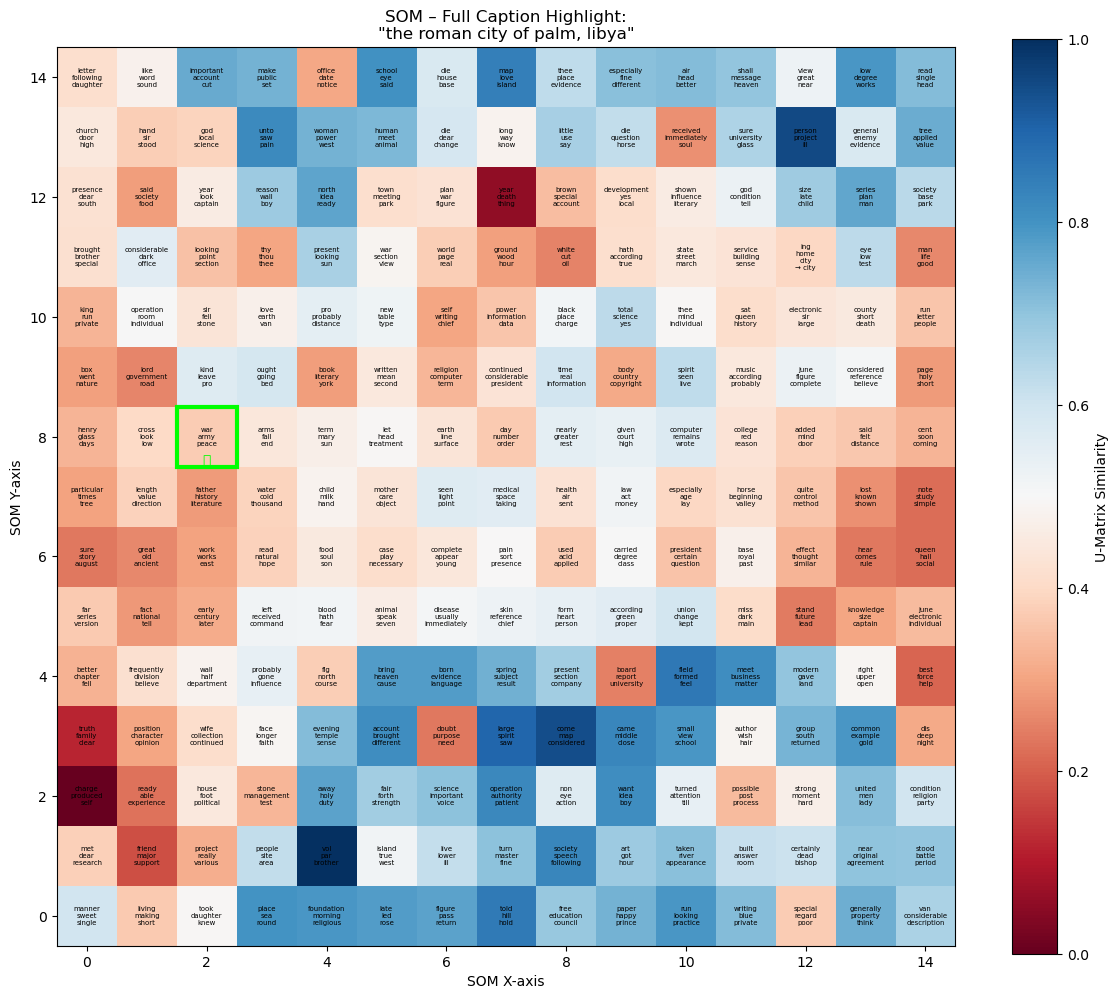

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/213_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug7.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001346 seconds.
SOM training took: 0.215278 seconds.

📸 Caption found for query image: "a stone carving of a woman ' s head"

🧭 Full caption BMU location: (11, 1)
📦 Words in that cell: ['right', 'left', 'head']

🔍 Individual caption word mappings:
 - "stone" → (11, 1) (words in cell: ['right', 'left', 'head'])
 - "woman" → (11, 0) (words in cell: ['works', 'think', 'young'])
 - "head" → (11, 1) (words in cell: ['right', 'left', 'head'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\1348710070.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\1348710070.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug8.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


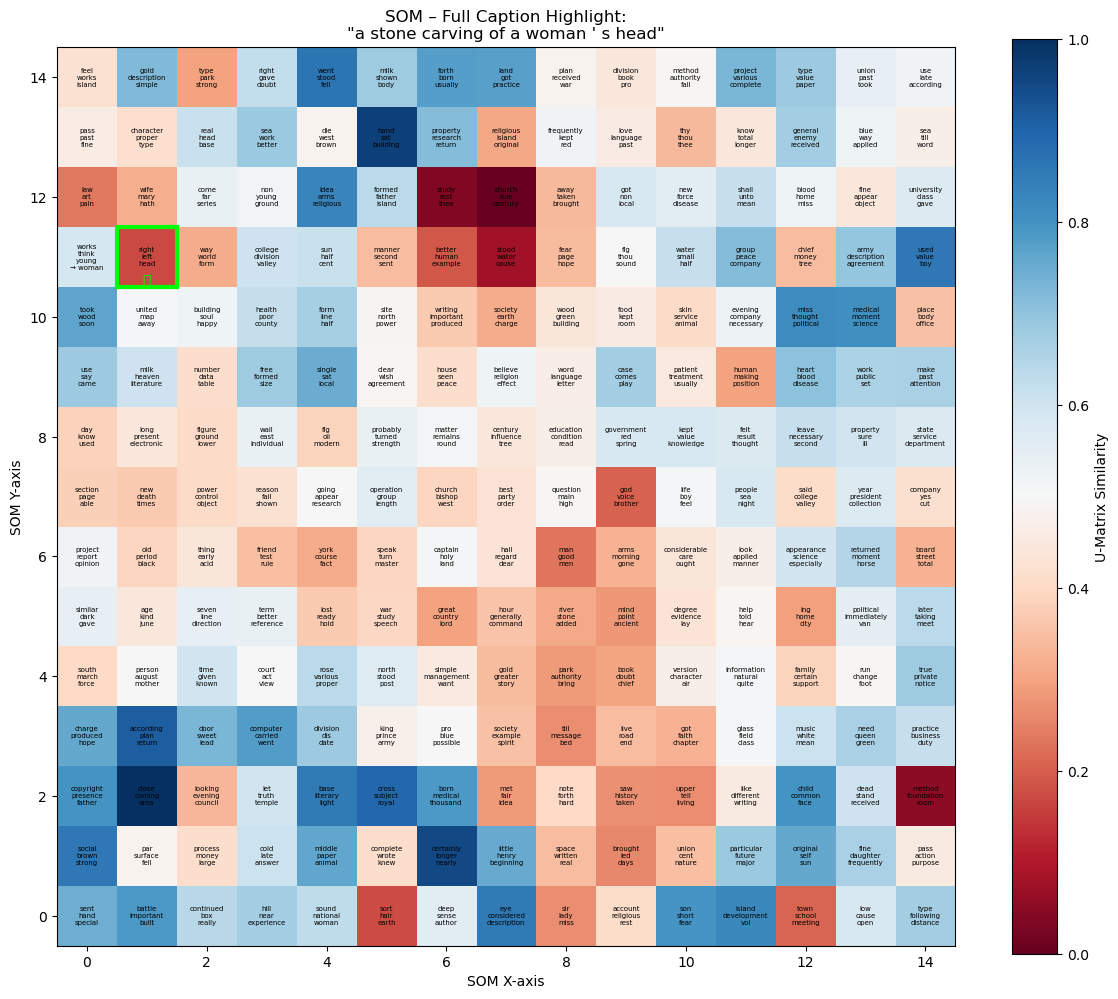

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/343_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug8.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.001670 seconds.
SOM training took: 0.222380 seconds.

📸 Caption found for query image: "a group of men looking at a skeleton"

🧭 Full caption BMU location: (0, 12)
📦 Words in that cell: ['rest', 'real', 'value']

🔍 Individual caption word mappings:
 - "group" → (9, 2) (words in cell: ['order', 'high', 'light'])
 - "men" → (14, 12) (words in cell: ['man', 'men', 'acid'])
 - "looking" → (8, 8) (words in cell: ['works', 'think', 'form'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2701118211.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\2701118211.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug9.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


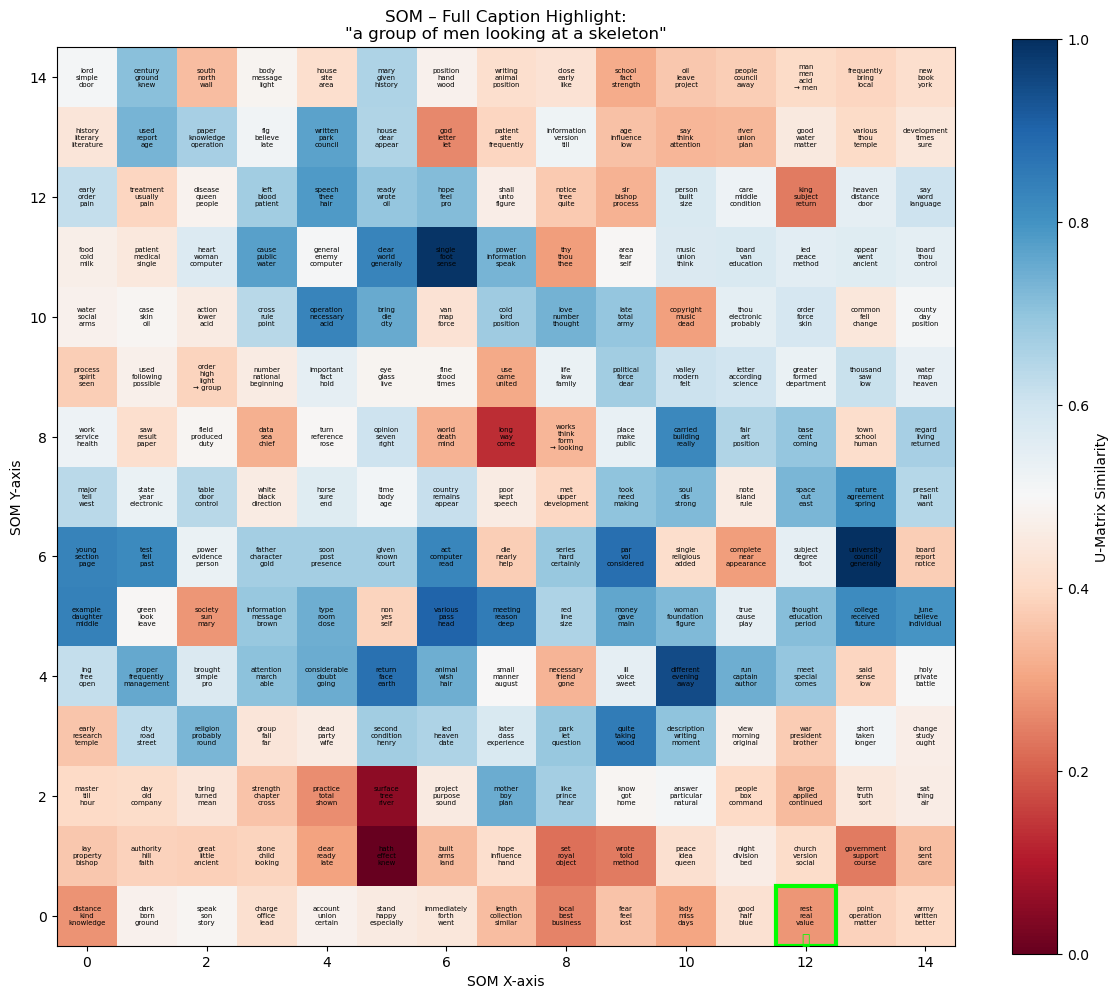

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/407_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug9.png"), dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Mishika/nltk_data...
[nltk_data]   Package words is already up-to-date!


Data scaling took: 0.002022 seconds.
SOM training took: 0.220995 seconds.

📸 Caption found for query image: "a man and woman dancing together in a room"

🧭 Full caption BMU location: (14, 13)
📦 Words in that cell: ['long', 'know', 'say']

🔍 Individual caption word mappings:
 - "man" → (3, 5) (words in cell: ['man', 'men', 'social'])
 - "woman" → (10, 14) (words in cell: ['works', 'way', 'come'])
 - "room" → (14, 13) (words in cell: ['long', 'know', 'say'])


C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3885077380.py:162: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mishika\AppData\Local\Temp\ipykernel_30116\3885077380.py:167: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug10.png"), dpi=300)
C:\Users\Mishika\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


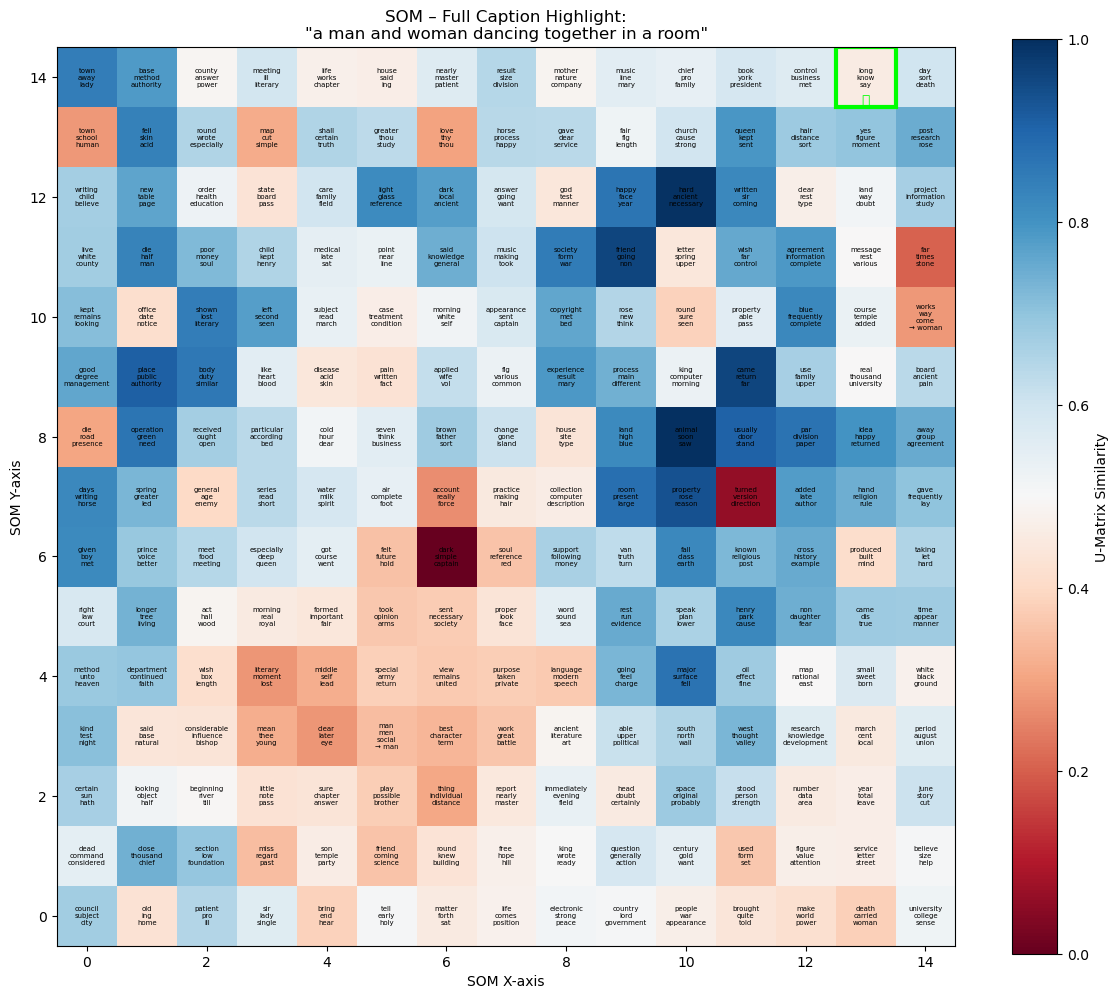

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numbasom import SOM
from collections import defaultdict
from nltk.corpus import words as nltk_words, stopwords
from random import shuffle, sample
from sklearn.preprocessing import StandardScaler
import os
import nltk

nltk.download('stopwords')
nltk.download('words')

# Load preprocessed TF-IDF + SVD
with open("tfidf_svd_data.pkl", "rb") as f:
    features_scaled, tfidf_vectorizer, svd_model, tfidf_matrix = pickle.load(f)

feature_names = tfidf_vectorizer.get_feature_names_out()
scaler = StandardScaler()
scaler.fit(svd_model.transform(tfidf_matrix))

# Filter English, non-stopword tokens
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_words(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

# Rank words by TF-IDF mean scores
avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
word_scores = dict(zip(feature_names, avg_scores))
filtered_words = [w for w in feature_names if filter_words(w)]
filtered_words.sort(key=lambda w: word_scores.get(w, 0), reverse=True)
top_words = filtered_words[:500]

# Train SOM
som_size = (15, 15)
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

# Map top words to SOM
cell_word_map = defaultdict(list)
word_vectors = []
valid_words = []

for word in top_words:
    idx = tfidf_vectorizer.vocabulary_.get(word)
    if idx is not None:
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        word_vectors.append(scaled[0])
        valid_words.append(word)

assigned_words = set()
for word, vec in zip(valid_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

# Fill remaining cells
flat_valid_words = list(set(valid_words))
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in valid_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        cell_word_map[cell].append(word)
    while len(cell_word_map[cell]) < 3:
        cell_word_map[cell].append(sample(flat_valid_words, 1)[0])

# Generate U-Matrix
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = (i+dx) % som_size[0], (j+dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)
u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

# Load caption for query image
query_image_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 images/045_img.jpg"
caption_txt_path = r"OneDrive - University College London/Datasets mlb/Dataset_2 caption generation/all_captions.txt"
image_key = os.path.splitext(os.path.basename(query_image_path))[0]

caption = None
with open(caption_txt_path, "r", encoding="utf-8") as f:
    for line in f:
        if image_key in line:
            caption = line.strip().split(":", 1)[-1].strip()
            break

if not caption:
    raise ValueError("Caption not found.")

print(f"\n📸 Caption found for query image: \"{caption}\"\n")

# --- Caption sentence vector ---
caption_vec = tfidf_vectorizer.transform([caption])
caption_reduced = svd_model.transform(caption_vec)
caption_scaled = scaler.transform(caption_reduced)
query_vec = caption_scaled[0]
distances = np.linalg.norm(lattice - query_vec, axis=2)
query_bmu = np.unravel_index(np.argmin(distances), som_size)

print(f"🧭 Full caption BMU location: {query_bmu}")
print(f"📦 Words in that cell: {cell_word_map[query_bmu]}\n")

# Optional: Map individual words (if you want arrows to show them)
show_individual_words = True
caption_tokens = caption.lower().split()
caption_tokens = [w for w in caption_tokens if w in tfidf_vectorizer.vocabulary_ and filter_words(w)]
caption_cell_map = defaultdict(list)

print("🔍 Individual caption word mappings:")
if show_individual_words:
    for word in caption_tokens:
        idx = tfidf_vectorizer.vocabulary_.get(word)
        vec = np.zeros((1, len(feature_names)))
        vec[0, idx] = 1.0
        reduced = svd_model.transform(vec)
        scaled = scaler.transform(reduced)
        distances = np.linalg.norm(lattice - scaled[0], axis=2)
        bmu = np.unravel_index(np.argmin(distances), som_size)
        caption_cell_map[bmu].append(word)
        print(f" - \"{word}\" → {bmu} (words in cell: {cell_word_map[bmu]})")

# Plot SOM
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(u_matrix, cmap='RdBu', origin='lower', interpolation='nearest')

# Text per cell
for (i, j) in all_cells:
    lines = list(cell_word_map.get((i, j), []))

    # Optionally: show caption word arrows
    if show_individual_words and (i, j) != query_bmu:
        cap_words = caption_cell_map.get((i, j), [])
        lines += ["→ " + w for w in cap_words]

    ax.text(j, i, "\n".join(lines), ha='center', va='center', fontsize=5, color='black')

# Highlight full caption BMU
rect = plt.Rectangle((query_bmu[1] - 0.5, query_bmu[0] - 0.5), 1, 1, edgecolor='lime', linewidth=3, facecolor='none')
ax.add_patch(rect)
ax.text(query_bmu[1], query_bmu[0] - 0.4, "🔍", ha='center', va='center', color='lime', fontsize=10)

# Final details
plt.colorbar(cax, label='U-Matrix Similarity')
plt.title(f"SOM – Full Caption Highlight:\n\"{caption}\"")
plt.xlabel("SOM X-axis")
plt.ylabel("SOM Y-axis")
plt.tight_layout()

# Save
output_dir = r"OneDrive - University College London/Datasets mlb/output_datasets all together/query"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "som_caption_visualization3_debug10.png"), dpi=300)
plt.show()

# SOM of Text Dataset using Imagebind 

In [27]:
pip install git+https://github.com/facebookresearch/ImageBind.git

  Cloning https://github.com/facebookresearch/ImageBind.git to c:\users\mishika\appdata\local\temp\pip-req-build-yd252fd3
  Resolved https://github.com/facebookresearch/ImageBind.git to commit 3fcf5c9039de97f6ff5528ee4a9dce903c5979b3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to c:\users\mishika\appdata\local\temp\pip-install-he5511cp\pytorchvideo_2326698503d641a4967308b3575310f6
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of imagebind to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/ImageBind.git 'C:\Users\Mishika\AppData\Local\Temp\pip-req-build-yd252fd3'
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git 'C:\Users\Mishika\AppData\Local\Temp\pip-install-he5511cp\pytorchvideo_2326698503d641a4967308b3575310f6'
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
ERROR: Could not find a version that satisfies the requirement torch==1.13.1 (from imagebind) (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.13.1


In [29]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install ftfy regex tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torch --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     --- ------------------------------------ 0.5/6.2 MB 3.4 MB/s eta 0:00:02
     ------ --------------------------------- 1.0/6.2 MB 3.0 MB/s eta 0:00:02
     -------- ------------------------------- 1.3/6.2 MB 2.2 MB/s eta 0:00:03
     ----------- ---------------------------- 1.8/6.2 MB 2.1 MB/s eta 0:00:03
     ----------- ---------------------------- 1.8/6.2 MB 2.1 MB/s eta 0:00:03
     --------------- ------------------------ 2.4/6.2 MB 1.9 MB/s eta 0:00:03
     ---------------- ----------------------- 2.6/6.2 MB 1.8 MB/s eta 0:00:02
     ------------------ --------------------- 2.9/6.2 MB 1.8 MB/s eta 0:00:02
     -------------------- ------------------- 3.1/6.2 MB 1.7 MB/s eta 0:00:02
     ---------------------- ----------------- 3.4/6.2 MB 1.6 MB/s eta 0:00:02
     ------------------------- -------------- 3.9/6.2 MB 1.7 MB/s eta 0:00:02
     ---------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imagebind 0.1.0 requires torch==1.13.1, but you have torch 2.6.0+cpu which is incompatible.
torchaudio 0.13.1 requires torch==1.13.1, but you have torch 2.6.0+cpu which is incompatible.
torchvision 0.14.1 requires torch==1.13.1, but you have torch 2.6.0+cpu which is incompatible.


In [3]:
pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0+cpuNote: you may need to restart the kernel to use updated packages.

Uninstalling torch-2.6.0+cpu:
  Successfully uninstalled torch-2.6.0+cpu
Found existing installation: torchvision 0.14.1
Uninstalling torchvision-0.14.1:
  Successfully uninstalled torchvision-0.14.1
Found existing installation: torchaudio 0.13.1
Uninstalling torchaudio-0.13.1:
  Successfully uninstalled torchaudio-0.13.1


In [5]:
pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1+cpu --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/164.2 MB ? eta -:--:--
     ---------------------------------------- 0.8/164.2 MB 5.6 MB/s eta 0:00:29
     ---------------------------------------- 1.6/164.2 MB 4.7 MB/s eta 0:00:35
      --------------------------------------- 2.6/164.2 MB 4.7 MB/s eta 0:00:35
      --------------------------------------- 3.4/164.2 MB 4.6 MB/s eta 0:00:36
     - -------------------------------------- 4.2/164.2 MB 4.3 MB/s eta 0:00:37
     - -------------------------------------- 5.2/164.2 MB 4.5 MB/s eta 0:00:36
     - -------------------------------------- 6.3/164.2 MB 4.6 MB/s eta 0:00:35
     - -------------------------------------- 7.3/164.2 MB 4.7 MB/s eta 0:00:34
     - -------------------------------------- 8.1/164.2 MB 4.6 MB/s eta 0:00:35
     -- ------------------------------------- 9.2/164.2 MB 4.6 MB/s eta 0:00:34
     -- ------------------------------------ 10.2/164.2 MB 4.6 MB/s et

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import torch
import numpy as np
x = torch.randn(2, 3)
print(x.numpy())  # ✅ Should now work!

C:\Users\Mishika\anaconda3\envs\imagebind-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[-0.36776125 -0.02119307  0.910606  ]
 [-1.2691023  -0.3551767   0.04805419]]


In [23]:
import numpy
print(numpy.__version__)

2.2.4


In [25]:
pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [35]:
!pip install torch torchvision torchaudio

In [37]:
!pip install git+https://github.com/facebookresearch/ImageBind.git

  Cloning https://github.com/facebookresearch/ImageBind.git to c:\users\mishika\appdata\local\temp\pip-req-build-5esl_uaf
  Resolved https://github.com/facebookresearch/ImageBind.git to commit 3fcf5c9039de97f6ff5528ee4a9dce903c5979b3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to c:\users\mishika\appdata\local\temp\pip-install-2iu7dx6z\pytorchvideo_4e36914316ff4c358a0165e177fc9335
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of imagebind to determine which version is compatible with other requirements. This could take a while.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/ImageBind.git 'C:\Users\Mishika\AppData\Local\Temp\pip-req-build-5esl_uaf'
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git 'C:\Users\Mishika\AppData\Local\Temp\pip-install-2iu7dx6z\pytorchvideo_4e36914316ff4c358a0165e177fc9335'
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
ERROR: Could not find a version that satisfies the requirement torch==1.13.1 (from imagebind) (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.13.1


In [39]:
pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Found existing installation: torchaudio 2.6.0
Uninstalling torchaudio-2.6.0:
  Successfully uninstalled torchaudio-2.6.0
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.


In [3]:
pip install notebook ipykernel

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas


  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)


In [7]:
pip install numbasom


  Using cached numbasom-0.0.5-py3-none-any.whl.metadata (6.9 kB)
Using cached numbasom-0.0.5-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 4.2 MB/s eta 0:00:01
   ----------- ---------------------------- 0.8/2.8 MB 2.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 2.5 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 2.6 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
    --------------------------------------- 0.5/30.3 MB 2.8 MB/s eta 0:00:11
   - -------------------------------------- 1.0/30.3 MB 2.6 MB/s eta 0:00:12
   -- ------------------------------------- 1.6/30.3 MB 2.5 MB/s eta 0:00:12
   -- ------------------------------------- 2.1/30.3 MB

In [11]:
pip install nltk

  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 2.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.9 MB/s eta 0:00:00
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.


In [15]:
pip install soundfile

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ------------------------------ --------- 0.8/1.0 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install nltk numpy==1.26.4 soundfile

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install pandas matplotlib numpy==1.26.4 tqdm nltk scikit-learn soundfile

  Using cached scipy-1.15.2-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 730.2 kB/s eta 0:00:15
   - -------------------------------------- 0.5/11.1 MB 730.2 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/11.1 MB 730.2 kB/s eta 0:00:15
   --- ------------------------------------ 1.0/11.1 MB 898.8 kB/s eta 0:00:12
   ---- ----------------------------------- 1.3/11.1 MB 907.1 kB/s eta 0:00:11
   ----- ---------------------------------- 1.6/11.1 MB 964.5 kB/s eta 0:00:10
   ------ --------------------------------- 1.8/11.1 MB 967.9 kB/s eta 0:00:10
   ------- -------------------------------- 2.1/11.1 MB 1.1 MB/s eta 0:00:09
   --------- -------

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbasom import SOM
import torch
from imagebind.models import imagebind_model
from imagebind.data import load_and_transform_text
import nltk
from nltk.corpus import words as nltk_words, stopwords
from collections import defaultdict
from tqdm import tqdm
from random import shuffle, sample
import pickle

In [15]:
nltk.download('words')
nltk.download('stopwords')

text_folder = r"OneDrive - University College London/Datasets mlb/Dataset_3 Texts"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Mishika\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mishika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [17]:
def load_texts(folder):
    texts = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), "r", encoding="utf-8", errors="ignore") as f:
                    texts.append(f.read())
    return texts

texts = load_texts(text_folder)

In [19]:
def encode_texts_with_imagebind(texts, batch_size=16):
    embeddings = []
    model.eval()
    model.to(device)
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding Texts"):
        batch = texts[i:i + batch_size]
        inputs = {"text": load_and_transform_text(batch, device)}
        with torch.no_grad():
            output = model(inputs)["text"]
        embeddings.extend(output.tolist())  # avoids numpy()
    return np.array(embeddings)

features_scaled = encode_texts_with_imagebind(texts)

Encoding Texts: 100%|██████████████████████████████████████████████████████████████████| 94/94 [41:23<00:00, 26.42s/it]


In [21]:
english_words_set = set(nltk_words.words())
stop_words = set(stopwords.words('english'))

def filter_word(word):
    word = word.lower()
    return word.isalpha() and word in english_words_set and word not in stop_words and len(word) > 2

all_words = set()
for text in texts:
    for word in text.split():
        if filter_word(word):
            all_words.add(word.lower())

top_words = list(all_words)[:500]

In [23]:
som_size = (15, 15)
print("Training SOM...")
som = SOM(som_size, is_torus=True)
lattice = som.train(features_scaled, num_iterations=5000, normalize=True)

Training SOM...
Data scaling took: 0.876426 seconds.
SOM training took: 1.272538 seconds.


In [25]:
print("Encoding top words...")
word_vectors = encode_texts_with_imagebind(top_words)

Encoding top words...


Encoding Texts: 100%|██████████████████████████████████████████████████████████████████| 32/32 [02:19<00:00,  4.36s/it]


In [27]:
cell_word_map = defaultdict(list)
assigned_words = set()

for word, vec in zip(top_words, word_vectors):
    distances = np.linalg.norm(lattice - vec, axis=2)
    bmu = np.unravel_index(np.argmin(distances), som_size)
    if len(cell_word_map[bmu]) < 3:
        cell_word_map[bmu].append(word)
        assigned_words.add(word)

In [29]:
all_cells = [(i, j) for i in range(som_size[0]) for j in range(som_size[1])]
unused_words = [w for w in top_words if w not in assigned_words]
shuffle(unused_words)

for cell in all_cells:
    while len(cell_word_map[cell]) < 3 and unused_words:
        word = unused_words.pop()
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

flat_words = list(set(top_words))
for cell in all_cells:
    while len(cell_word_map[cell]) < 3:
        word = sample(flat_words, 1)[0]
        if word not in cell_word_map[cell]:
            cell_word_map[cell].append(word)

In [31]:
u_matrix = np.zeros(som_size)
for i in range(som_size[0]):
    for j in range(som_size[1]):
        neighbors = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = (i + dx) % som_size[0], (j + dy) % som_size[1]
            neighbors.append(np.linalg.norm(lattice[i, j] - lattice[ni, nj]))
        u_matrix[i, j] = np.mean(neighbors)

u_matrix = (u_matrix - u_matrix.min()) / (u_matrix.max() - u_matrix.min())

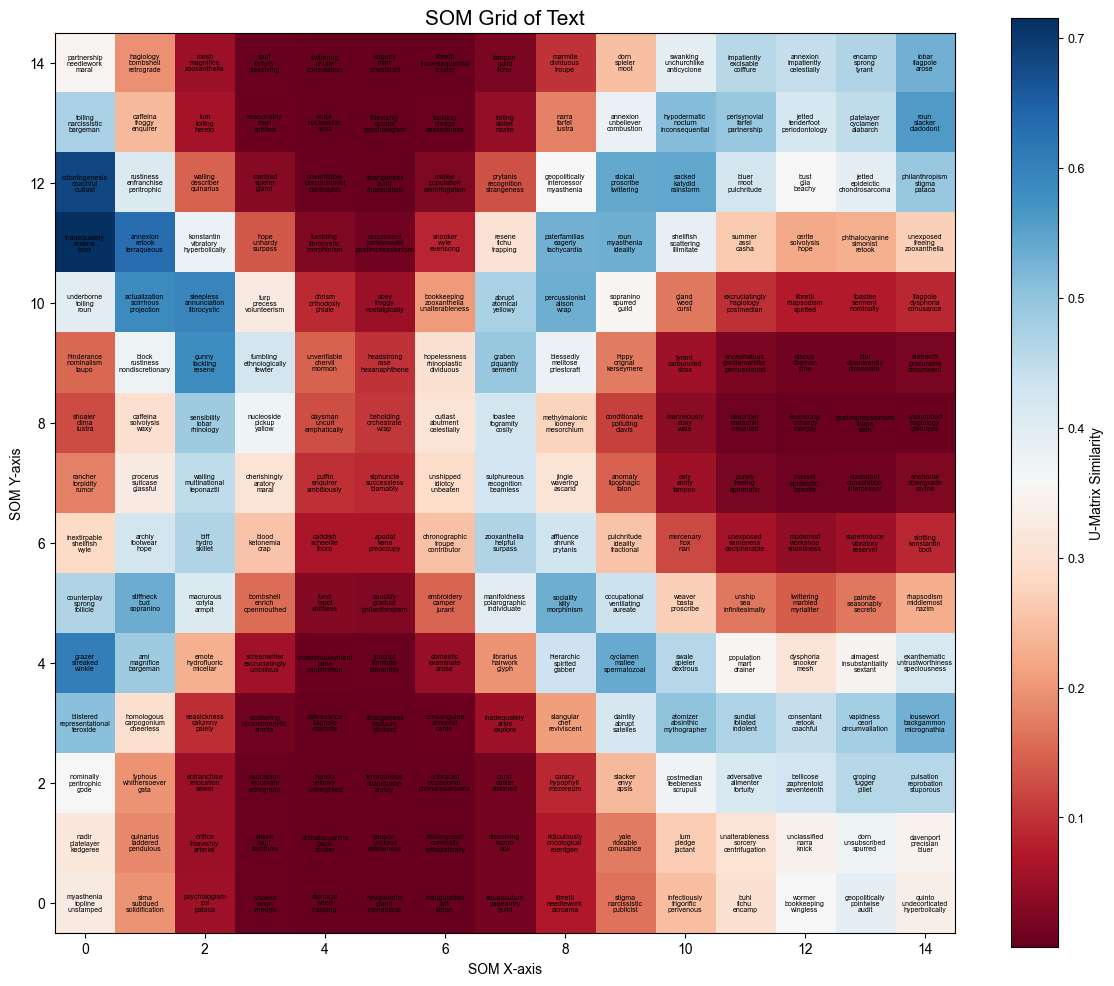

In [95]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
from scipy.ndimage import gaussian_filter



# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 10))

# Use standard 'RdBu' colormap
cax = ax.imshow(smoothed_u_matrix, cmap='RdBu', origin='lower', interpolation='none')

# --- Add text (unchanged) ---
for (i, j), words in cell_word_map.items():
    label = "\n".join(words)
    ax.text(j, i, label, ha='center', va='center', fontsize=5, color='black', linespacing=1.0)

# --- Colorbar & layout ---
cbar = plt.colorbar(cax, label='U-Matrix Similarity')
cbar.ax.tick_params(labelsize=9)

plt.title("SOM Grid of Text", fontsize=15)
plt.xlabel("SOM X-axis", fontsize=10)
plt.ylabel("SOM Y-axis", fontsize=10)
plt.tight_layout()

# --- Save and show ---
output_path_u_matrix = r"OneDrive - University College London/Datasets mlb/output_datasets all together/som_u_matrix_feature_map_rdbu_smooth.png"
plt.savefig(output_path_u_matrix, dpi=300)
plt.show()

In [3]:
import torch
import clip

device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print("CLIP is ready on", device)

100%|███████████████████████████████████████| 338M/338M [04:20<00:00, 1.36MiB/s]


CLIP is ready on cpu


In [71]:
import os
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# === Load MobileNetV2 Model ===
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_image_features(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = mobilenet_model.predict(img_array)
    return features.flatten()

def process_images_and_save(image_folder, output_folder):
    features = []
    paths = []

    for filename in tqdm(os.listdir(image_folder), desc="Extracting Features"):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(image_folder, filename)
            try:
                feat = extract_image_features(path)
                features.append(feat)
                paths.append(path)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    features = np.array(features)
    paths = np.array(paths)

    os.makedirs(output_folder, exist_ok=True)
    np.save(os.path.join(output_folder, 'image_features.npy'), features)
    np.save(os.path.join(output_folder, 'image_paths.npy'), paths)
    print("✅ Saved features and paths.")

# === Example Usage ===
if __name__ == "__main__":
    image_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_2 images"
    output_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_2 Features"

    process_images_and_save(image_folder, output_folder)

C:\Users\Mishika\AppData\Local\Temp\ipykernel_33308\3549705562.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
Extracting Features:   0%|                                                                                                                               | 0/1501 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting Features:   0%|                                                                                                                       | 1/1501 [00:01<40:20,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   0%|▏                                                                                                                      | 2/1501 [00:01<18:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:   0%|▏                                                                                                                      | 3/1501 [00:01<12:15,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:   0%|▎                                                                                                                      | 4/1501 [00:02<08:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   0%|▍                                                                                                                      | 5/1501 [00:02<07:12,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   0%|▍                                                                                                                      | 6/1501 [00:02<06:14,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:   0%|▌                                                                                                                      | 7/1501 [00:02<05:35,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   1%|▋                                                                                                                      | 8/1501 [00:02<05:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:   1%|▋                                                                                                                      | 9/1501 [00:02<04:44,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   1%|▊                                                                                                                     | 10/1501 [00:03<04:27,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:   1%|▊                                                                                                                     | 11/1501 [00:03<04:19,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   1%|▉                                                                                                                     | 12/1501 [00:03<04:14,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   1%|█                                                                                                                     | 13/1501 [00:03<04:06,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   1%|█                                                                                                                     | 14/1501 [00:03<04:03,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   1%|█▏                                                                                                                    | 15/1501 [00:03<04:01,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   1%|█▎                                                                                                                    | 16/1501 [00:04<03:54,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   1%|█▎                                                                                                                    | 17/1501 [00:04<03:54,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:   1%|█▍                                                                                                                    | 18/1501 [00:04<04:00,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:   1%|█▍                                                                                                                    | 19/1501 [00:04<04:04,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   1%|█▌                                                                                                                    | 20/1501 [00:04<04:04,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   1%|█▋                                                                                                                    | 21/1501 [00:04<04:10,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   1%|█▋                                                                                                                    | 22/1501 [00:05<04:12,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:   2%|█▊                                                                                                                    | 23/1501 [00:05<04:14,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   2%|█▉                                                                                                                    | 24/1501 [00:05<04:02,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:   2%|█▉                                                                                                                    | 25/1501 [00:05<04:10,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:   2%|██                                                                                                                    | 26/1501 [00:05<04:06,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:   2%|██                                                                                                                    | 27/1501 [00:05<04:08,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   2%|██▏                                                                                                                   | 28/1501 [00:06<04:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:   2%|██▎                                                                                                                   | 29/1501 [00:06<03:59,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:   2%|██▎                                                                                                                   | 30/1501 [00:06<04:00,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   2%|██▍                                                                                                                   | 31/1501 [00:06<04:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:   2%|██▌                                                                                                                   | 32/1501 [00:06<04:01,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   2%|██▌                                                                                                                   | 33/1501 [00:06<04:11,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:   2%|██▋                                                                                                                   | 34/1501 [00:07<04:12,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:   2%|██▊                                                                                                                   | 35/1501 [00:07<04:02,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   2%|██▊                                                                                                                   | 36/1501 [00:07<04:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:   2%|██▉                                                                                                                   | 37/1501 [00:07<04:03,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   3%|██▉                                                                                                                   | 38/1501 [00:07<03:58,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   3%|███                                                                                                                   | 39/1501 [00:07<03:58,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   3%|███▏                                                                                                                  | 40/1501 [00:08<04:04,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   3%|███▏                                                                                                                  | 41/1501 [00:08<03:58,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   3%|███▎                                                                                                                  | 42/1501 [00:08<04:01,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   3%|███▍                                                                                                                  | 43/1501 [00:08<04:07,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   3%|███▍                                                                                                                  | 44/1501 [00:08<04:02,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:   3%|███▌                                                                                                                  | 45/1501 [00:08<04:02,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   3%|███▌                                                                                                                  | 46/1501 [00:09<04:02,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:   3%|███▋                                                                                                                  | 47/1501 [00:09<03:56,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:   3%|███▊                                                                                                                  | 48/1501 [00:09<03:59,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:   3%|███▊                                                                                                                  | 49/1501 [00:09<04:00,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   3%|███▉                                                                                                                  | 50/1501 [00:09<04:06,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   3%|████                                                                                                                  | 51/1501 [00:09<04:12,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   3%|████                                                                                                                  | 52/1501 [00:10<04:04,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:   4%|████▏                                                                                                                 | 53/1501 [00:10<04:00,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:   4%|████▏                                                                                                                 | 54/1501 [00:10<04:05,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:   4%|████▎                                                                                                                 | 55/1501 [00:10<04:04,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   4%|████▍                                                                                                                 | 56/1501 [00:10<04:10,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:   4%|████▍                                                                                                                 | 57/1501 [00:10<04:13,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   4%|████▌                                                                                                                 | 58/1501 [00:11<04:04,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:   4%|████▋                                                                                                                 | 59/1501 [00:11<03:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:   4%|████▋                                                                                                                 | 60/1501 [00:11<03:50,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:   4%|████▊                                                                                                                 | 61/1501 [00:11<03:47,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   4%|████▊                                                                                                                 | 62/1501 [00:11<03:49,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   4%|████▉                                                                                                                 | 63/1501 [00:11<03:55,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   4%|█████                                                                                                                 | 64/1501 [00:12<03:55,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   4%|█████                                                                                                                 | 65/1501 [00:12<03:56,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   4%|█████▏                                                                                                                | 66/1501 [00:12<04:00,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:   4%|█████▎                                                                                                                | 67/1501 [00:12<04:08,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   5%|█████▎                                                                                                                | 68/1501 [00:12<04:09,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:   5%|█████▍                                                                                                                | 69/1501 [00:12<04:08,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   5%|█████▌                                                                                                                | 70/1501 [00:13<04:13,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:   5%|█████▌                                                                                                                | 71/1501 [00:13<04:01,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   5%|█████▋                                                                                                                | 72/1501 [00:13<03:55,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   5%|█████▋                                                                                                                | 73/1501 [00:13<03:57,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   5%|█████▊                                                                                                                | 74/1501 [00:13<03:48,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:   5%|█████▉                                                                                                                | 75/1501 [00:13<03:56,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   5%|█████▉                                                                                                                | 76/1501 [00:14<04:02,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   5%|██████                                                                                                                | 77/1501 [00:14<03:57,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   5%|██████▏                                                                                                               | 78/1501 [00:14<03:54,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:   5%|██████▏                                                                                                               | 79/1501 [00:14<03:54,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   5%|██████▎                                                                                                               | 80/1501 [00:14<03:52,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   5%|██████▎                                                                                                               | 81/1501 [00:14<03:55,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:   5%|██████▍                                                                                                               | 82/1501 [00:15<03:56,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:   6%|██████▌                                                                                                               | 83/1501 [00:15<03:52,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting Features:   6%|██████▌                                                                                                               | 84/1501 [00:15<03:53,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   6%|██████▋                                                                                                               | 85/1501 [00:15<03:55,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:   6%|██████▊                                                                                                               | 86/1501 [00:15<03:51,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:   6%|██████▊                                                                                                               | 87/1501 [00:15<03:49,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   6%|██████▉                                                                                                               | 88/1501 [00:16<03:49,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   6%|██████▉                                                                                                               | 89/1501 [00:16<03:52,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:   6%|███████                                                                                                               | 90/1501 [00:16<03:52,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   6%|███████▏                                                                                                              | 91/1501 [00:16<03:50,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:   6%|███████▏                                                                                                              | 92/1501 [00:16<03:45,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting Features:   6%|███████▎                                                                                                              | 93/1501 [00:16<03:45,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   6%|███████▍                                                                                                              | 94/1501 [00:17<03:45,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   6%|███████▍                                                                                                              | 95/1501 [00:17<03:46,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   6%|███████▌                                                                                                              | 96/1501 [00:17<03:45,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   6%|███████▋                                                                                                              | 97/1501 [00:17<03:46,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   7%|███████▋                                                                                                              | 98/1501 [00:17<03:40,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   7%|███████▊                                                                                                              | 99/1501 [00:17<03:40,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:   7%|███████▊                                                                                                             | 100/1501 [00:17<03:44,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting Features:   7%|███████▊                                                                                                             | 101/1501 [00:18<03:42,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:   7%|███████▉                                                                                                             | 102/1501 [00:18<03:41,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   7%|████████                                                                                                             | 103/1501 [00:18<03:41,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   7%|████████                                                                                                             | 104/1501 [00:18<03:44,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   7%|████████▏                                                                                                            | 105/1501 [00:18<03:47,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:   7%|████████▎                                                                                                            | 106/1501 [00:18<03:41,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   7%|████████▎                                                                                                            | 107/1501 [00:19<03:45,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   7%|████████▍                                                                                                            | 108/1501 [00:19<03:45,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   7%|████████▍                                                                                                            | 109/1501 [00:19<03:56,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:   7%|████████▌                                                                                                            | 110/1501 [00:19<03:51,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting Features:   7%|████████▋                                                                                                            | 111/1501 [00:19<03:48,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:   7%|████████▋                                                                                                            | 112/1501 [00:19<03:56,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   8%|████████▊                                                                                                            | 113/1501 [00:20<03:51,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   8%|████████▉                                                                                                            | 114/1501 [00:20<03:51,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:   8%|████████▉                                                                                                            | 115/1501 [00:20<03:58,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   8%|█████████                                                                                                            | 116/1501 [00:20<03:48,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:   8%|█████████                                                                                                            | 117/1501 [00:20<03:45,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:   8%|█████████▏                                                                                                           | 118/1501 [00:20<03:50,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   8%|█████████▎                                                                                                           | 119/1501 [00:21<03:47,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   8%|█████████▎                                                                                                           | 120/1501 [00:21<03:51,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   8%|█████████▍                                                                                                           | 121/1501 [00:21<03:46,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   8%|█████████▌                                                                                                           | 122/1501 [00:21<03:48,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:   8%|█████████▌                                                                                                           | 123/1501 [00:21<03:53,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:   8%|█████████▋                                                                                                           | 124/1501 [00:21<03:45,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:   8%|█████████▋                                                                                                           | 125/1501 [00:22<03:46,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   8%|█████████▊                                                                                                           | 126/1501 [00:22<03:46,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:   8%|█████████▉                                                                                                           | 127/1501 [00:22<03:49,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   9%|█████████▉                                                                                                           | 128/1501 [00:22<03:52,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   9%|██████████                                                                                                           | 129/1501 [00:22<03:47,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   9%|██████████▏                                                                                                          | 130/1501 [00:22<03:49,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting Features:   9%|██████████▏                                                                                                          | 131/1501 [00:23<03:49,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   9%|██████████▎                                                                                                          | 132/1501 [00:23<03:45,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting Features:   9%|██████████▎                                                                                                          | 133/1501 [00:23<03:40,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:   9%|██████████▍                                                                                                          | 134/1501 [00:23<03:35,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:   9%|██████████▌                                                                                                          | 135/1501 [00:23<03:36,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting Features:   9%|██████████▌                                                                                                          | 136/1501 [00:23<04:03,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:   9%|██████████▋                                                                                                          | 137/1501 [00:24<04:01,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:   9%|██████████▊                                                                                                          | 138/1501 [00:24<03:58,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:   9%|██████████▊                                                                                                          | 139/1501 [00:24<04:00,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:   9%|██████████▉                                                                                                          | 140/1501 [00:24<04:00,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:   9%|██████████▉                                                                                                          | 141/1501 [00:24<03:58,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:   9%|███████████                                                                                                          | 142/1501 [00:24<03:56,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  10%|███████████▏                                                                                                         | 143/1501 [00:25<03:50,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  10%|███████████▏                                                                                                         | 144/1501 [00:25<03:59,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  10%|███████████▎                                                                                                         | 145/1501 [00:25<03:59,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  10%|███████████▍                                                                                                         | 146/1501 [00:25<03:51,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  10%|███████████▍                                                                                                         | 147/1501 [00:25<03:55,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  10%|███████████▌                                                                                                         | 148/1501 [00:26<03:52,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  10%|███████████▌                                                                                                         | 149/1501 [00:26<03:50,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  10%|███████████▋                                                                                                         | 150/1501 [00:26<03:51,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  10%|███████████▊                                                                                                         | 151/1501 [00:26<03:54,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  10%|███████████▊                                                                                                         | 152/1501 [00:26<03:44,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  10%|███████████▉                                                                                                         | 153/1501 [00:26<03:41,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  10%|████████████                                                                                                         | 154/1501 [00:27<03:37,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  10%|████████████                                                                                                         | 155/1501 [00:27<03:35,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  10%|████████████▏                                                                                                        | 156/1501 [00:27<03:35,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  10%|████████████▏                                                                                                        | 157/1501 [00:27<03:40,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  11%|████████████▎                                                                                                        | 158/1501 [00:27<03:38,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  11%|████████████▍                                                                                                        | 159/1501 [00:27<03:43,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  11%|████████████▍                                                                                                        | 160/1501 [00:27<03:43,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  11%|████████████▌                                                                                                        | 161/1501 [00:28<03:51,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  11%|████████████▋                                                                                                        | 162/1501 [00:28<03:46,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  11%|████████████▋                                                                                                        | 163/1501 [00:28<03:47,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  11%|████████████▊                                                                                                        | 164/1501 [00:28<03:42,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  11%|████████████▊                                                                                                        | 165/1501 [00:28<03:35,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  11%|████████████▉                                                                                                        | 166/1501 [00:28<03:41,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  11%|█████████████                                                                                                        | 167/1501 [00:29<03:43,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  11%|█████████████                                                                                                        | 168/1501 [00:29<03:47,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  11%|█████████████▏                                                                                                       | 169/1501 [00:29<03:44,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:  11%|█████████████▎                                                                                                       | 170/1501 [00:29<03:42,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  11%|█████████████▎                                                                                                       | 171/1501 [00:29<03:34,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  11%|█████████████▍                                                                                                       | 172/1501 [00:30<03:42,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  12%|█████████████▍                                                                                                       | 173/1501 [00:30<03:41,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  12%|█████████████▌                                                                                                       | 174/1501 [00:30<03:39,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  12%|█████████████▋                                                                                                       | 175/1501 [00:30<03:44,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  12%|█████████████▋                                                                                                       | 176/1501 [00:30<03:41,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  12%|█████████████▊                                                                                                       | 177/1501 [00:30<03:41,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  12%|█████████████▊                                                                                                       | 178/1501 [00:31<03:38,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  12%|█████████████▉                                                                                                       | 179/1501 [00:31<03:37,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  12%|██████████████                                                                                                       | 180/1501 [00:31<03:34,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  12%|██████████████                                                                                                       | 181/1501 [00:31<03:33,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  12%|██████████████▏                                                                                                      | 182/1501 [00:31<03:33,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  12%|██████████████▎                                                                                                      | 183/1501 [00:31<03:33,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  12%|██████████████▎                                                                                                      | 184/1501 [00:31<03:35,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  12%|██████████████▍                                                                                                      | 185/1501 [00:32<03:37,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  12%|██████████████▍                                                                                                      | 186/1501 [00:32<03:40,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  12%|██████████████▌                                                                                                      | 187/1501 [00:32<03:38,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  13%|██████████████▋                                                                                                      | 188/1501 [00:32<03:36,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  13%|██████████████▋                                                                                                      | 189/1501 [00:32<03:34,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  13%|██████████████▊                                                                                                      | 190/1501 [00:32<03:39,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting Features:  13%|██████████████▉                                                                                                      | 191/1501 [00:33<03:36,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  13%|██████████████▉                                                                                                      | 192/1501 [00:33<03:33,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  13%|███████████████                                                                                                      | 193/1501 [00:33<03:40,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  13%|███████████████                                                                                                      | 194/1501 [00:33<03:40,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  13%|███████████████▏                                                                                                     | 195/1501 [00:33<03:37,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  13%|███████████████▎                                                                                                     | 196/1501 [00:33<03:33,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  13%|███████████████▎                                                                                                     | 197/1501 [00:34<03:32,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  13%|███████████████▍                                                                                                     | 198/1501 [00:34<03:32,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  13%|███████████████▌                                                                                                     | 199/1501 [00:34<03:31,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  13%|███████████████▌                                                                                                     | 200/1501 [00:34<03:39,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  13%|███████████████▋                                                                                                     | 201/1501 [00:34<03:43,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  13%|███████████████▋                                                                                                     | 202/1501 [00:34<03:41,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  14%|███████████████▊                                                                                                     | 203/1501 [00:35<03:34,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  14%|███████████████▉                                                                                                     | 204/1501 [00:35<03:39,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  14%|███████████████▉                                                                                                     | 205/1501 [00:35<03:36,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  14%|████████████████                                                                                                     | 206/1501 [00:35<03:40,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  14%|████████████████▏                                                                                                    | 207/1501 [00:35<03:36,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  14%|████████████████▏                                                                                                    | 208/1501 [00:35<03:40,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  14%|████████████████▎                                                                                                    | 209/1501 [00:36<03:34,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  14%|████████████████▎                                                                                                    | 210/1501 [00:36<03:39,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  14%|████████████████▍                                                                                                    | 211/1501 [00:36<03:36,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  14%|████████████████▌                                                                                                    | 212/1501 [00:36<03:35,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  14%|████████████████▌                                                                                                    | 213/1501 [00:36<03:35,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  14%|████████████████▋                                                                                                    | 214/1501 [00:37<03:42,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  14%|████████████████▊                                                                                                    | 215/1501 [00:37<03:40,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  14%|████████████████▊                                                                                                    | 216/1501 [00:37<03:33,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  14%|████████████████▉                                                                                                    | 217/1501 [00:37<03:33,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  15%|████████████████▉                                                                                                    | 218/1501 [00:37<03:31,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|█████████████████                                                                                                    | 219/1501 [00:37<03:29,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  15%|█████████████████▏                                                                                                   | 220/1501 [00:38<03:41,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  15%|█████████████████▏                                                                                                   | 221/1501 [00:38<03:37,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|█████████████████▎                                                                                                   | 222/1501 [00:38<03:36,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  15%|█████████████████▍                                                                                                   | 223/1501 [00:38<03:31,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  15%|█████████████████▍                                                                                                   | 224/1501 [00:38<03:30,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  15%|█████████████████▌                                                                                                   | 225/1501 [00:38<03:26,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|█████████████████▌                                                                                                   | 226/1501 [00:38<03:26,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|█████████████████▋                                                                                                   | 227/1501 [00:39<03:23,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  15%|█████████████████▊                                                                                                   | 228/1501 [00:39<03:29,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|█████████████████▊                                                                                                   | 229/1501 [00:39<03:29,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  15%|█████████████████▉                                                                                                   | 230/1501 [00:39<03:25,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  15%|██████████████████                                                                                                   | 231/1501 [00:39<03:23,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  15%|██████████████████                                                                                                   | 232/1501 [00:39<03:27,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  16%|██████████████████▏                                                                                                  | 233/1501 [00:40<03:27,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  16%|██████████████████▏                                                                                                  | 234/1501 [00:40<03:34,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  16%|██████████████████▎                                                                                                  | 235/1501 [00:40<03:33,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  16%|██████████████████▍                                                                                                  | 236/1501 [00:40<03:30,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  16%|██████████████████▍                                                                                                  | 237/1501 [00:40<03:30,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  16%|██████████████████▌                                                                                                  | 238/1501 [00:40<03:26,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  16%|██████████████████▋                                                                                                  | 239/1501 [00:41<03:22,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  16%|██████████████████▋                                                                                                  | 240/1501 [00:41<03:27,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  16%|██████████████████▊                                                                                                  | 241/1501 [00:41<03:26,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  16%|██████████████████▊                                                                                                  | 242/1501 [00:41<03:30,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  16%|██████████████████▉                                                                                                  | 243/1501 [00:41<03:28,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  16%|███████████████████                                                                                                  | 244/1501 [00:41<03:29,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  16%|███████████████████                                                                                                  | 245/1501 [00:42<03:27,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  16%|███████████████████▏                                                                                                 | 246/1501 [00:42<03:33,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  16%|███████████████████▎                                                                                                 | 247/1501 [00:42<03:35,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  17%|███████████████████▎                                                                                                 | 248/1501 [00:42<03:35,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  17%|███████████████████▍                                                                                                 | 249/1501 [00:42<03:34,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  17%|███████████████████▍                                                                                                 | 250/1501 [00:42<03:33,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  17%|███████████████████▌                                                                                                 | 251/1501 [00:43<03:33,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  17%|███████████████████▋                                                                                                 | 252/1501 [00:43<03:28,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  17%|███████████████████▋                                                                                                 | 253/1501 [00:43<03:30,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  17%|███████████████████▊                                                                                                 | 254/1501 [00:43<03:37,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  17%|███████████████████▉                                                                                                 | 255/1501 [00:43<03:32,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  17%|███████████████████▉                                                                                                 | 256/1501 [00:44<03:30,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  17%|████████████████████                                                                                                 | 257/1501 [00:44<03:25,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  17%|████████████████████                                                                                                 | 258/1501 [00:44<03:24,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  17%|████████████████████▏                                                                                                | 259/1501 [00:44<03:24,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  17%|████████████████████▎                                                                                                | 260/1501 [00:44<03:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  17%|████████████████████▎                                                                                                | 261/1501 [00:44<03:30,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  17%|████████████████████▍                                                                                                | 262/1501 [00:45<03:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  18%|████████████████████▌                                                                                                | 263/1501 [00:45<03:39,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  18%|████████████████████▌                                                                                                | 264/1501 [00:45<03:40,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  18%|████████████████████▋                                                                                                | 265/1501 [00:45<03:38,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  18%|████████████████████▋                                                                                                | 266/1501 [00:45<03:36,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  18%|████████████████████▊                                                                                                | 267/1501 [00:45<03:48,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  18%|████████████████████▉                                                                                                | 268/1501 [00:46<03:47,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  18%|████████████████████▉                                                                                                | 269/1501 [00:46<03:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  18%|█████████████████████                                                                                                | 270/1501 [00:46<03:40,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  18%|█████████████████████                                                                                                | 271/1501 [00:46<03:41,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  18%|█████████████████████▏                                                                                               | 272/1501 [00:46<03:36,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  18%|█████████████████████▎                                                                                               | 273/1501 [00:46<03:32,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  18%|█████████████████████▎                                                                                               | 274/1501 [00:47<03:30,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  18%|█████████████████████▍                                                                                               | 275/1501 [00:47<03:28,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  18%|█████████████████████▌                                                                                               | 276/1501 [00:47<03:23,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  18%|█████████████████████▌                                                                                               | 277/1501 [00:47<03:22,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  19%|█████████████████████▋                                                                                               | 278/1501 [00:47<03:27,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  19%|█████████████████████▋                                                                                               | 279/1501 [00:48<03:44,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  19%|█████████████████████▊                                                                                               | 280/1501 [00:48<03:45,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  19%|█████████████████████▉                                                                                               | 281/1501 [00:48<03:35,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  19%|█████████████████████▉                                                                                               | 282/1501 [00:48<03:36,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  19%|██████████████████████                                                                                               | 283/1501 [00:48<03:32,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  19%|██████████████████████▏                                                                                              | 284/1501 [00:48<03:27,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  19%|██████████████████████▏                                                                                              | 285/1501 [00:49<03:26,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  19%|██████████████████████▎                                                                                              | 286/1501 [00:49<03:20,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  19%|██████████████████████▎                                                                                              | 287/1501 [00:49<03:25,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  19%|██████████████████████▍                                                                                              | 288/1501 [00:49<03:24,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  19%|██████████████████████▌                                                                                              | 289/1501 [00:49<03:21,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  19%|██████████████████████▌                                                                                              | 290/1501 [00:49<03:27,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  19%|██████████████████████▋                                                                                              | 291/1501 [00:50<03:23,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  19%|██████████████████████▊                                                                                              | 292/1501 [00:50<03:20,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  20%|██████████████████████▊                                                                                              | 293/1501 [00:50<03:18,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  20%|██████████████████████▉                                                                                              | 294/1501 [00:50<03:27,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  20%|██████████████████████▉                                                                                              | 295/1501 [00:50<03:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  20%|███████████████████████                                                                                              | 296/1501 [00:50<03:23,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  20%|███████████████████████▏                                                                                             | 297/1501 [00:51<03:28,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  20%|███████████████████████▏                                                                                             | 298/1501 [00:51<03:25,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  20%|███████████████████████▎                                                                                             | 299/1501 [00:51<03:26,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  20%|███████████████████████▍                                                                                             | 300/1501 [00:51<03:20,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  20%|███████████████████████▍                                                                                             | 301/1501 [00:51<03:17,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  20%|███████████████████████▌                                                                                             | 302/1501 [00:51<03:16,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  20%|███████████████████████▌                                                                                             | 303/1501 [00:52<03:14,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  20%|███████████████████████▋                                                                                             | 304/1501 [00:52<03:11,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  20%|███████████████████████▊                                                                                             | 305/1501 [00:52<03:14,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  20%|███████████████████████▊                                                                                             | 306/1501 [00:52<03:44,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  20%|███████████████████████▉                                                                                             | 307/1501 [00:52<03:34,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  21%|████████████████████████                                                                                             | 308/1501 [00:52<03:28,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  21%|████████████████████████                                                                                             | 309/1501 [00:53<03:21,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  21%|████████████████████████▏                                                                                            | 310/1501 [00:53<03:17,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  21%|████████████████████████▏                                                                                            | 311/1501 [00:53<03:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  21%|████████████████████████▎                                                                                            | 312/1501 [00:53<03:17,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  21%|████████████████████████▍                                                                                            | 313/1501 [00:53<03:16,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  21%|████████████████████████▍                                                                                            | 314/1501 [00:53<03:16,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  21%|████████████████████████▌                                                                                            | 315/1501 [00:54<03:16,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  21%|████████████████████████▋                                                                                            | 316/1501 [00:54<03:12,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  21%|████████████████████████▋                                                                                            | 317/1501 [00:54<03:12,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  21%|████████████████████████▊                                                                                            | 318/1501 [00:54<03:10,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  21%|████████████████████████▊                                                                                            | 319/1501 [00:54<03:13,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  21%|████████████████████████▉                                                                                            | 320/1501 [00:54<03:16,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  21%|█████████████████████████                                                                                            | 321/1501 [00:55<03:16,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  21%|█████████████████████████                                                                                            | 322/1501 [00:55<03:14,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  22%|█████████████████████████▏                                                                                           | 323/1501 [00:55<03:18,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  22%|█████████████████████████▎                                                                                           | 324/1501 [00:55<03:15,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  22%|█████████████████████████▎                                                                                           | 325/1501 [00:55<03:17,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  22%|█████████████████████████▍                                                                                           | 326/1501 [00:55<03:21,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  22%|█████████████████████████▍                                                                                           | 327/1501 [00:56<03:17,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  22%|█████████████████████████▌                                                                                           | 328/1501 [00:56<03:22,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  22%|█████████████████████████▋                                                                                           | 329/1501 [00:56<03:19,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  22%|█████████████████████████▋                                                                                           | 330/1501 [00:56<03:22,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  22%|█████████████████████████▊                                                                                           | 331/1501 [00:56<03:21,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  22%|█████████████████████████▉                                                                                           | 332/1501 [00:56<03:20,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  22%|█████████████████████████▉                                                                                           | 333/1501 [00:57<03:15,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  22%|██████████████████████████                                                                                           | 334/1501 [00:57<03:15,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  22%|██████████████████████████                                                                                           | 335/1501 [00:57<03:14,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  22%|██████████████████████████▏                                                                                          | 336/1501 [00:57<03:08,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  22%|██████████████████████████▎                                                                                          | 337/1501 [00:57<03:15,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  23%|██████████████████████████▎                                                                                          | 338/1501 [00:57<03:14,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  23%|██████████████████████████▍                                                                                          | 339/1501 [00:58<03:22,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  23%|██████████████████████████▌                                                                                          | 340/1501 [00:58<03:19,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  23%|██████████████████████████▌                                                                                          | 341/1501 [00:58<03:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  23%|██████████████████████████▋                                                                                          | 342/1501 [00:58<03:20,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  23%|██████████████████████████▋                                                                                          | 343/1501 [00:58<03:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  23%|██████████████████████████▊                                                                                          | 344/1501 [00:59<03:23,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  23%|██████████████████████████▉                                                                                          | 345/1501 [00:59<03:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  23%|██████████████████████████▉                                                                                          | 346/1501 [00:59<03:12,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  23%|███████████████████████████                                                                                          | 347/1501 [00:59<03:13,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  23%|███████████████████████████▏                                                                                         | 348/1501 [00:59<03:17,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  23%|███████████████████████████▏                                                                                         | 349/1501 [00:59<03:15,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  23%|███████████████████████████▎                                                                                         | 350/1501 [00:59<03:11,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  23%|███████████████████████████▎                                                                                         | 351/1501 [01:00<03:07,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  23%|███████████████████████████▍                                                                                         | 352/1501 [01:00<03:06,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  24%|███████████████████████████▌                                                                                         | 353/1501 [01:00<03:03,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  24%|███████████████████████████▌                                                                                         | 354/1501 [01:00<03:11,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  24%|███████████████████████████▋                                                                                         | 355/1501 [01:00<03:19,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  24%|███████████████████████████▋                                                                                         | 356/1501 [01:01<03:21,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  24%|███████████████████████████▊                                                                                         | 357/1501 [01:01<03:16,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  24%|███████████████████████████▉                                                                                         | 358/1501 [01:01<03:19,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  24%|███████████████████████████▉                                                                                         | 359/1501 [01:01<03:11,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  24%|████████████████████████████                                                                                         | 360/1501 [01:01<03:16,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  24%|████████████████████████████▏                                                                                        | 361/1501 [01:01<03:10,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  24%|████████████████████████████▏                                                                                        | 362/1501 [01:02<03:08,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  24%|████████████████████████████▎                                                                                        | 363/1501 [01:02<03:04,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  24%|████████████████████████████▎                                                                                        | 364/1501 [01:02<03:05,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  24%|████████████████████████████▍                                                                                        | 365/1501 [01:02<03:04,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  24%|████████████████████████████▌                                                                                        | 366/1501 [01:02<03:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  24%|████████████████████████████▌                                                                                        | 367/1501 [01:02<03:04,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  25%|████████████████████████████▋                                                                                        | 368/1501 [01:02<03:05,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  25%|████████████████████████████▊                                                                                        | 369/1501 [01:03<03:02,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  25%|████████████████████████████▊                                                                                        | 370/1501 [01:03<03:01,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  25%|████████████████████████████▉                                                                                        | 371/1501 [01:03<03:03,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  25%|████████████████████████████▉                                                                                        | 372/1501 [01:03<03:03,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  25%|█████████████████████████████                                                                                        | 373/1501 [01:03<03:07,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  25%|█████████████████████████████▏                                                                                       | 374/1501 [01:03<03:13,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  25%|█████████████████████████████▏                                                                                       | 375/1501 [01:04<03:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  25%|█████████████████████████████▎                                                                                       | 376/1501 [01:04<03:05,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  25%|█████████████████████████████▍                                                                                       | 377/1501 [01:04<03:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  25%|█████████████████████████████▍                                                                                       | 378/1501 [01:04<03:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  25%|█████████████████████████████▌                                                                                       | 379/1501 [01:04<03:07,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  25%|█████████████████████████████▌                                                                                       | 380/1501 [01:04<03:10,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  25%|█████████████████████████████▋                                                                                       | 381/1501 [01:05<03:04,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  25%|█████████████████████████████▊                                                                                       | 382/1501 [01:05<03:03,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  26%|█████████████████████████████▊                                                                                       | 383/1501 [01:05<03:03,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  26%|█████████████████████████████▉                                                                                       | 384/1501 [01:05<03:02,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  26%|██████████████████████████████                                                                                       | 385/1501 [01:05<03:01,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  26%|██████████████████████████████                                                                                       | 386/1501 [01:05<03:02,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  26%|██████████████████████████████▏                                                                                      | 387/1501 [01:06<03:05,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  26%|██████████████████████████████▏                                                                                      | 388/1501 [01:06<03:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  26%|██████████████████████████████▎                                                                                      | 389/1501 [01:06<03:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  26%|██████████████████████████████▍                                                                                      | 390/1501 [01:06<03:05,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting Features:  26%|██████████████████████████████▍                                                                                      | 391/1501 [01:06<03:11,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  26%|██████████████████████████████▌                                                                                      | 392/1501 [01:06<03:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  26%|██████████████████████████████▋                                                                                      | 393/1501 [01:07<03:07,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  26%|██████████████████████████████▋                                                                                      | 394/1501 [01:07<03:03,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  26%|██████████████████████████████▊                                                                                      | 395/1501 [01:07<03:03,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  26%|██████████████████████████████▊                                                                                      | 396/1501 [01:07<03:02,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  26%|██████████████████████████████▉                                                                                      | 397/1501 [01:07<03:04,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  27%|███████████████████████████████                                                                                      | 398/1501 [01:07<03:05,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  27%|███████████████████████████████                                                                                      | 399/1501 [01:08<03:02,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  27%|███████████████████████████████▏                                                                                     | 400/1501 [01:08<03:06,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  27%|███████████████████████████████▎                                                                                     | 401/1501 [01:08<03:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  27%|███████████████████████████████▎                                                                                     | 402/1501 [01:08<03:00,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  27%|███████████████████████████████▍                                                                                     | 403/1501 [01:08<03:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  27%|███████████████████████████████▍                                                                                     | 404/1501 [01:09<03:12,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  27%|███████████████████████████████▌                                                                                     | 405/1501 [01:09<03:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting Features:  27%|███████████████████████████████▋                                                                                     | 406/1501 [01:09<03:10,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  27%|███████████████████████████████▋                                                                                     | 407/1501 [01:09<03:09,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  27%|███████████████████████████████▊                                                                                     | 408/1501 [01:09<03:09,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  27%|███████████████████████████████▉                                                                                     | 409/1501 [01:09<03:01,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  27%|███████████████████████████████▉                                                                                     | 410/1501 [01:10<02:58,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  27%|████████████████████████████████                                                                                     | 411/1501 [01:10<02:56,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  27%|████████████████████████████████                                                                                     | 412/1501 [01:10<03:03,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  28%|████████████████████████████████▏                                                                                    | 413/1501 [01:10<03:05,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  28%|████████████████████████████████▎                                                                                    | 414/1501 [01:10<03:01,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  28%|████████████████████████████████▎                                                                                    | 415/1501 [01:10<03:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  28%|████████████████████████████████▍                                                                                    | 416/1501 [01:11<03:07,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  28%|████████████████████████████████▌                                                                                    | 417/1501 [01:11<03:05,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  28%|████████████████████████████████▌                                                                                    | 418/1501 [01:11<03:06,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  28%|████████████████████████████████▋                                                                                    | 419/1501 [01:11<03:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  28%|████████████████████████████████▋                                                                                    | 420/1501 [01:11<03:04,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  28%|████████████████████████████████▊                                                                                    | 421/1501 [01:11<03:00,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  28%|████████████████████████████████▉                                                                                    | 422/1501 [01:12<02:55,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  28%|████████████████████████████████▉                                                                                    | 423/1501 [01:12<02:57,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  28%|█████████████████████████████████                                                                                    | 424/1501 [01:12<02:56,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  28%|█████████████████████████████████▏                                                                                   | 425/1501 [01:12<03:00,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  28%|█████████████████████████████████▏                                                                                   | 426/1501 [01:12<03:02,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  28%|█████████████████████████████████▎                                                                                   | 427/1501 [01:12<02:57,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  29%|█████████████████████████████████▎                                                                                   | 428/1501 [01:13<02:52,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  29%|█████████████████████████████████▍                                                                                   | 429/1501 [01:13<02:53,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  29%|█████████████████████████████████▌                                                                                   | 430/1501 [01:13<02:56,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  29%|█████████████████████████████████▌                                                                                   | 431/1501 [01:13<02:55,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  29%|█████████████████████████████████▋                                                                                   | 432/1501 [01:13<02:56,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  29%|█████████████████████████████████▊                                                                                   | 433/1501 [01:13<02:59,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  29%|█████████████████████████████████▊                                                                                   | 434/1501 [01:14<03:04,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  29%|█████████████████████████████████▉                                                                                   | 435/1501 [01:14<03:00,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  29%|█████████████████████████████████▉                                                                                   | 436/1501 [01:14<02:59,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  29%|██████████████████████████████████                                                                                   | 437/1501 [01:14<03:01,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  29%|██████████████████████████████████▏                                                                                  | 438/1501 [01:14<02:57,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  29%|██████████████████████████████████▏                                                                                  | 439/1501 [01:14<02:58,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  29%|██████████████████████████████████▎                                                                                  | 440/1501 [01:15<03:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  29%|██████████████████████████████████▍                                                                                  | 441/1501 [01:15<03:04,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  29%|██████████████████████████████████▍                                                                                  | 442/1501 [01:15<03:08,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  30%|██████████████████████████████████▌                                                                                  | 443/1501 [01:15<03:06,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  30%|██████████████████████████████████▌                                                                                  | 444/1501 [01:15<03:05,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  30%|██████████████████████████████████▋                                                                                  | 445/1501 [01:15<03:00,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting Features:  30%|██████████████████████████████████▊                                                                                  | 446/1501 [01:16<03:00,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  30%|██████████████████████████████████▊                                                                                  | 447/1501 [01:16<02:57,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  30%|██████████████████████████████████▉                                                                                  | 448/1501 [01:16<02:57,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting Features:  30%|██████████████████████████████████▉                                                                                  | 449/1501 [01:16<03:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  30%|███████████████████████████████████                                                                                  | 450/1501 [01:16<03:05,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  30%|███████████████████████████████████▏                                                                                 | 451/1501 [01:16<03:02,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  30%|███████████████████████████████████▏                                                                                 | 452/1501 [01:17<02:58,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  30%|███████████████████████████████████▎                                                                                 | 453/1501 [01:17<02:58,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  30%|███████████████████████████████████▍                                                                                 | 454/1501 [01:17<02:57,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  30%|███████████████████████████████████▍                                                                                 | 455/1501 [01:17<02:57,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  30%|███████████████████████████████████▌                                                                                 | 456/1501 [01:17<02:52,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  30%|███████████████████████████████████▌                                                                                 | 457/1501 [01:17<02:58,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  31%|███████████████████████████████████▋                                                                                 | 458/1501 [01:18<03:02,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting Features:  31%|███████████████████████████████████▊                                                                                 | 459/1501 [01:18<03:06,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  31%|███████████████████████████████████▊                                                                                 | 460/1501 [01:18<03:13,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  31%|███████████████████████████████████▉                                                                                 | 461/1501 [01:18<03:18,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  31%|████████████████████████████████████                                                                                 | 462/1501 [01:18<03:15,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  31%|████████████████████████████████████                                                                                 | 463/1501 [01:19<03:07,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  31%|████████████████████████████████████▏                                                                                | 464/1501 [01:19<03:06,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  31%|████████████████████████████████████▏                                                                                | 465/1501 [01:19<03:02,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  31%|████████████████████████████████████▎                                                                                | 466/1501 [01:19<02:58,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  31%|████████████████████████████████████▍                                                                                | 467/1501 [01:19<03:01,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  31%|████████████████████████████████████▍                                                                                | 468/1501 [01:19<02:56,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  31%|████████████████████████████████████▌                                                                                | 469/1501 [01:20<02:51,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  31%|████████████████████████████████████▋                                                                                | 470/1501 [01:20<02:55,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  31%|████████████████████████████████████▋                                                                                | 471/1501 [01:20<02:55,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  31%|████████████████████████████████████▊                                                                                | 472/1501 [01:20<02:55,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  32%|████████████████████████████████████▊                                                                                | 473/1501 [01:20<02:56,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  32%|████████████████████████████████████▉                                                                                | 474/1501 [01:20<02:57,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  32%|█████████████████████████████████████                                                                                | 475/1501 [01:21<02:55,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  32%|█████████████████████████████████████                                                                                | 476/1501 [01:21<02:50,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  32%|█████████████████████████████████████▏                                                                               | 477/1501 [01:21<02:49,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  32%|█████████████████████████████████████▎                                                                               | 478/1501 [01:21<02:52,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  32%|█████████████████████████████████████▎                                                                               | 479/1501 [01:21<02:54,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  32%|█████████████████████████████████████▍                                                                               | 480/1501 [01:21<02:54,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  32%|█████████████████████████████████████▍                                                                               | 481/1501 [01:22<02:51,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  32%|█████████████████████████████████████▌                                                                               | 482/1501 [01:22<02:55,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  32%|█████████████████████████████████████▋                                                                               | 483/1501 [01:22<02:51,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  32%|█████████████████████████████████████▋                                                                               | 484/1501 [01:22<02:47,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  32%|█████████████████████████████████████▊                                                                               | 485/1501 [01:22<02:51,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  32%|█████████████████████████████████████▉                                                                               | 486/1501 [01:23<02:52,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  32%|█████████████████████████████████████▉                                                                               | 487/1501 [01:23<02:54,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  33%|██████████████████████████████████████                                                                               | 488/1501 [01:23<02:48,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  33%|██████████████████████████████████████                                                                               | 489/1501 [01:23<02:48,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  33%|██████████████████████████████████████▏                                                                              | 490/1501 [01:23<02:50,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  33%|██████████████████████████████████████▎                                                                              | 491/1501 [01:23<02:57,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  33%|██████████████████████████████████████▎                                                                              | 492/1501 [01:24<02:49,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  33%|██████████████████████████████████████▍                                                                              | 493/1501 [01:24<02:56,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  33%|██████████████████████████████████████▌                                                                              | 494/1501 [01:24<02:50,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  33%|██████████████████████████████████████▌                                                                              | 495/1501 [01:24<02:55,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  33%|██████████████████████████████████████▋                                                                              | 496/1501 [01:24<02:54,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  33%|██████████████████████████████████████▋                                                                              | 497/1501 [01:24<02:53,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  33%|██████████████████████████████████████▊                                                                              | 498/1501 [01:25<02:52,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  33%|██████████████████████████████████████▉                                                                              | 499/1501 [01:25<02:55,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  33%|██████████████████████████████████████▉                                                                              | 500/1501 [01:25<02:55,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  33%|███████████████████████████████████████                                                                              | 501/1501 [01:25<02:50,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  33%|███████████████████████████████████████▏                                                                             | 502/1501 [01:25<02:50,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  34%|███████████████████████████████████████▏                                                                             | 503/1501 [01:25<02:57,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting Features:  34%|███████████████████████████████████████▎                                                                             | 504/1501 [01:26<03:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  34%|███████████████████████████████████████▎                                                                             | 505/1501 [01:26<02:56,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  34%|███████████████████████████████████████▍                                                                             | 506/1501 [01:26<03:03,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  34%|███████████████████████████████████████▌                                                                             | 507/1501 [01:26<03:00,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  34%|███████████████████████████████████████▌                                                                             | 508/1501 [01:26<02:55,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  34%|███████████████████████████████████████▋                                                                             | 509/1501 [01:27<02:52,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  34%|███████████████████████████████████████▊                                                                             | 510/1501 [01:27<02:53,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting Features:  34%|███████████████████████████████████████▊                                                                             | 511/1501 [01:27<02:49,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  34%|███████████████████████████████████████▉                                                                             | 512/1501 [01:27<02:59,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  34%|███████████████████████████████████████▉                                                                             | 513/1501 [01:27<02:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  34%|████████████████████████████████████████                                                                             | 514/1501 [01:27<02:51,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  34%|████████████████████████████████████████▏                                                                            | 515/1501 [01:28<02:56,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  34%|████████████████████████████████████████▏                                                                            | 516/1501 [01:28<02:58,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  34%|████████████████████████████████████████▎                                                                            | 517/1501 [01:28<02:56,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  35%|████████████████████████████████████████▍                                                                            | 518/1501 [01:28<02:56,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  35%|████████████████████████████████████████▍                                                                            | 519/1501 [01:28<03:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  35%|████████████████████████████████████████▌                                                                            | 520/1501 [01:29<02:58,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  35%|████████████████████████████████████████▌                                                                            | 521/1501 [01:29<02:55,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  35%|████████████████████████████████████████▋                                                                            | 522/1501 [01:29<02:49,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  35%|████████████████████████████████████████▊                                                                            | 523/1501 [01:29<02:59,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  35%|████████████████████████████████████████▊                                                                            | 524/1501 [01:29<02:58,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  35%|████████████████████████████████████████▉                                                                            | 525/1501 [01:29<02:57,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  35%|█████████████████████████████████████████                                                                            | 526/1501 [01:30<02:54,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  35%|█████████████████████████████████████████                                                                            | 527/1501 [01:30<02:52,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  35%|█████████████████████████████████████████▏                                                                           | 528/1501 [01:30<02:52,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  35%|█████████████████████████████████████████▏                                                                           | 529/1501 [01:30<02:53,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  35%|█████████████████████████████████████████▎                                                                           | 530/1501 [01:30<02:47,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  35%|█████████████████████████████████████████▍                                                                           | 531/1501 [01:30<02:48,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  35%|█████████████████████████████████████████▍                                                                           | 532/1501 [01:31<02:48,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  36%|█████████████████████████████████████████▌                                                                           | 533/1501 [01:31<02:44,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  36%|█████████████████████████████████████████▌                                                                           | 534/1501 [01:31<02:40,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  36%|█████████████████████████████████████████▋                                                                           | 535/1501 [01:31<02:42,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  36%|█████████████████████████████████████████▊                                                                           | 536/1501 [01:31<02:39,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  36%|█████████████████████████████████████████▊                                                                           | 537/1501 [01:31<02:42,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  36%|█████████████████████████████████████████▉                                                                           | 538/1501 [01:32<02:39,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  36%|██████████████████████████████████████████                                                                           | 539/1501 [01:32<02:38,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  36%|██████████████████████████████████████████                                                                           | 540/1501 [01:32<02:42,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  36%|██████████████████████████████████████████▏                                                                          | 541/1501 [01:32<02:40,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  36%|██████████████████████████████████████████▏                                                                          | 542/1501 [01:32<02:39,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  36%|██████████████████████████████████████████▎                                                                          | 543/1501 [01:32<02:43,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  36%|██████████████████████████████████████████▍                                                                          | 544/1501 [01:33<02:44,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  36%|██████████████████████████████████████████▍                                                                          | 545/1501 [01:33<02:46,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  36%|██████████████████████████████████████████▌                                                                          | 546/1501 [01:33<02:44,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  36%|██████████████████████████████████████████▋                                                                          | 547/1501 [01:33<02:48,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  37%|██████████████████████████████████████████▋                                                                          | 548/1501 [01:33<02:51,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  37%|██████████████████████████████████████████▊                                                                          | 549/1501 [01:34<02:46,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  37%|██████████████████████████████████████████▊                                                                          | 550/1501 [01:34<02:50,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  37%|██████████████████████████████████████████▉                                                                          | 551/1501 [01:34<02:56,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  37%|███████████████████████████████████████████                                                                          | 552/1501 [01:34<02:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  37%|███████████████████████████████████████████                                                                          | 553/1501 [01:34<02:50,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  37%|███████████████████████████████████████████▏                                                                         | 554/1501 [01:34<02:50,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting Features:  37%|███████████████████████████████████████████▎                                                                         | 555/1501 [01:35<02:48,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  37%|███████████████████████████████████████████▎                                                                         | 556/1501 [01:35<02:52,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  37%|███████████████████████████████████████████▍                                                                         | 557/1501 [01:35<02:50,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  37%|███████████████████████████████████████████▍                                                                         | 558/1501 [01:35<02:53,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  37%|███████████████████████████████████████████▌                                                                         | 559/1501 [01:35<02:53,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting Features:  37%|███████████████████████████████████████████▋                                                                         | 560/1501 [01:36<02:49,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting Features:  37%|███████████████████████████████████████████▋                                                                         | 561/1501 [01:36<02:51,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  37%|███████████████████████████████████████████▊                                                                         | 562/1501 [01:36<02:49,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  38%|███████████████████████████████████████████▉                                                                         | 563/1501 [01:36<02:56,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  38%|███████████████████████████████████████████▉                                                                         | 564/1501 [01:36<02:51,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  38%|████████████████████████████████████████████                                                                         | 565/1501 [01:36<02:55,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  38%|████████████████████████████████████████████                                                                         | 566/1501 [01:37<02:48,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  38%|████████████████████████████████████████████▏                                                                        | 567/1501 [01:37<02:46,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  38%|████████████████████████████████████████████▎                                                                        | 568/1501 [01:37<02:42,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  38%|████████████████████████████████████████████▎                                                                        | 569/1501 [01:37<02:41,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  38%|████████████████████████████████████████████▍                                                                        | 570/1501 [01:37<02:38,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  38%|████████████████████████████████████████████▌                                                                        | 571/1501 [01:37<02:34,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  38%|████████████████████████████████████████████▌                                                                        | 572/1501 [01:38<02:33,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  38%|████████████████████████████████████████████▋                                                                        | 573/1501 [01:38<02:36,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  38%|████████████████████████████████████████████▋                                                                        | 574/1501 [01:38<02:34,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  38%|████████████████████████████████████████████▊                                                                        | 575/1501 [01:38<02:30,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  38%|████████████████████████████████████████████▉                                                                        | 576/1501 [01:38<02:34,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  38%|████████████████████████████████████████████▉                                                                        | 577/1501 [01:38<02:32,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  39%|█████████████████████████████████████████████                                                                        | 578/1501 [01:39<02:30,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  39%|█████████████████████████████████████████████▏                                                                       | 579/1501 [01:39<02:35,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  39%|█████████████████████████████████████████████▏                                                                       | 580/1501 [01:39<02:36,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  39%|█████████████████████████████████████████████▎                                                                       | 581/1501 [01:39<02:34,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  39%|█████████████████████████████████████████████▎                                                                       | 582/1501 [01:39<02:38,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  39%|█████████████████████████████████████████████▍                                                                       | 583/1501 [01:39<02:39,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  39%|█████████████████████████████████████████████▌                                                                       | 584/1501 [01:40<02:38,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  39%|█████████████████████████████████████████████▌                                                                       | 585/1501 [01:40<02:33,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  39%|█████████████████████████████████████████████▋                                                                       | 586/1501 [01:40<02:34,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  39%|█████████████████████████████████████████████▊                                                                       | 587/1501 [01:40<02:36,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  39%|█████████████████████████████████████████████▊                                                                       | 588/1501 [01:40<02:32,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  39%|█████████████████████████████████████████████▉                                                                       | 589/1501 [01:40<02:30,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  39%|█████████████████████████████████████████████▉                                                                       | 590/1501 [01:41<02:32,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  39%|██████████████████████████████████████████████                                                                       | 591/1501 [01:41<02:33,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  39%|██████████████████████████████████████████████▏                                                                      | 592/1501 [01:41<02:38,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  40%|██████████████████████████████████████████████▏                                                                      | 593/1501 [01:41<02:41,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  40%|██████████████████████████████████████████████▎                                                                      | 594/1501 [01:41<02:38,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  40%|██████████████████████████████████████████████▍                                                                      | 595/1501 [01:42<02:35,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  40%|██████████████████████████████████████████████▍                                                                      | 596/1501 [01:42<02:43,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  40%|██████████████████████████████████████████████▌                                                                      | 597/1501 [01:42<02:44,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  40%|██████████████████████████████████████████████▌                                                                      | 598/1501 [01:42<02:43,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  40%|██████████████████████████████████████████████▋                                                                      | 599/1501 [01:42<02:40,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  40%|██████████████████████████████████████████████▊                                                                      | 600/1501 [01:42<02:35,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  40%|██████████████████████████████████████████████▊                                                                      | 601/1501 [01:43<02:36,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  40%|██████████████████████████████████████████████▉                                                                      | 602/1501 [01:43<02:31,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  40%|███████████████████████████████████████████████                                                                      | 603/1501 [01:43<02:35,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  40%|███████████████████████████████████████████████                                                                      | 604/1501 [01:43<02:33,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  40%|███████████████████████████████████████████████▏                                                                     | 605/1501 [01:43<02:31,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  40%|███████████████████████████████████████████████▏                                                                     | 606/1501 [01:43<02:33,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  40%|███████████████████████████████████████████████▎                                                                     | 607/1501 [01:44<02:31,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  41%|███████████████████████████████████████████████▍                                                                     | 608/1501 [01:44<02:34,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  41%|███████████████████████████████████████████████▍                                                                     | 609/1501 [01:44<02:34,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  41%|███████████████████████████████████████████████▌                                                                     | 610/1501 [01:44<02:37,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  41%|███████████████████████████████████████████████▋                                                                     | 611/1501 [01:44<02:32,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  41%|███████████████████████████████████████████████▋                                                                     | 612/1501 [01:44<02:30,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  41%|███████████████████████████████████████████████▊                                                                     | 613/1501 [01:45<02:26,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  41%|███████████████████████████████████████████████▊                                                                     | 614/1501 [01:45<02:23,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  41%|███████████████████████████████████████████████▉                                                                     | 615/1501 [01:45<02:22,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  41%|████████████████████████████████████████████████                                                                     | 616/1501 [01:45<02:27,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  41%|████████████████████████████████████████████████                                                                     | 617/1501 [01:45<02:25,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  41%|████████████████████████████████████████████████▏                                                                    | 618/1501 [01:45<02:28,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  41%|████████████████████████████████████████████████▏                                                                    | 619/1501 [01:46<02:27,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  41%|████████████████████████████████████████████████▎                                                                    | 620/1501 [01:46<02:28,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  41%|████████████████████████████████████████████████▍                                                                    | 621/1501 [01:46<02:28,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  41%|████████████████████████████████████████████████▍                                                                    | 622/1501 [01:46<02:27,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  42%|████████████████████████████████████████████████▌                                                                    | 623/1501 [01:46<02:25,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  42%|████████████████████████████████████████████████▋                                                                    | 624/1501 [01:46<02:25,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  42%|████████████████████████████████████████████████▋                                                                    | 625/1501 [01:47<02:26,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  42%|████████████████████████████████████████████████▊                                                                    | 626/1501 [01:47<02:26,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  42%|████████████████████████████████████████████████▊                                                                    | 627/1501 [01:47<02:30,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  42%|████████████████████████████████████████████████▉                                                                    | 628/1501 [01:47<02:27,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  42%|█████████████████████████████████████████████████                                                                    | 629/1501 [01:47<02:26,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  42%|█████████████████████████████████████████████████                                                                    | 630/1501 [01:47<02:27,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▏                                                                   | 631/1501 [01:48<02:26,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▎                                                                   | 632/1501 [01:48<02:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▎                                                                   | 633/1501 [01:48<02:27,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▍                                                                   | 634/1501 [01:48<02:25,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▍                                                                   | 635/1501 [01:48<02:21,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▌                                                                   | 636/1501 [01:48<02:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  42%|█████████████████████████████████████████████████▋                                                                   | 637/1501 [01:49<02:20,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  43%|█████████████████████████████████████████████████▋                                                                   | 638/1501 [01:49<02:20,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  43%|█████████████████████████████████████████████████▊                                                                   | 639/1501 [01:49<02:18,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  43%|█████████████████████████████████████████████████▉                                                                   | 640/1501 [01:49<02:21,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  43%|█████████████████████████████████████████████████▉                                                                   | 641/1501 [01:49<02:25,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  43%|██████████████████████████████████████████████████                                                                   | 642/1501 [01:49<02:22,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  43%|██████████████████████████████████████████████████                                                                   | 643/1501 [01:50<02:21,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▏                                                                  | 644/1501 [01:50<02:24,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▎                                                                  | 645/1501 [01:50<02:24,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▎                                                                  | 646/1501 [01:50<02:22,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▍                                                                  | 647/1501 [01:50<02:24,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▌                                                                  | 648/1501 [01:50<02:21,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▌                                                                  | 649/1501 [01:51<02:17,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▋                                                                  | 650/1501 [01:51<02:22,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▋                                                                  | 651/1501 [01:51<02:21,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  43%|██████████████████████████████████████████████████▊                                                                  | 652/1501 [01:51<02:19,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting Features:  44%|██████████████████████████████████████████████████▉                                                                  | 653/1501 [01:51<02:20,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  44%|██████████████████████████████████████████████████▉                                                                  | 654/1501 [01:51<02:22,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  44%|███████████████████████████████████████████████████                                                                  | 655/1501 [01:52<02:23,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▏                                                                 | 656/1501 [01:52<02:24,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▏                                                                 | 657/1501 [01:52<02:20,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▎                                                                 | 658/1501 [01:52<02:19,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▎                                                                 | 659/1501 [01:52<02:17,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▍                                                                 | 660/1501 [01:52<02:15,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▌                                                                 | 661/1501 [01:53<02:14,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▌                                                                 | 662/1501 [01:53<02:16,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▋                                                                 | 663/1501 [01:53<02:19,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▊                                                                 | 664/1501 [01:53<02:22,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▊                                                                 | 665/1501 [01:53<02:20,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▉                                                                 | 666/1501 [01:53<02:19,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  44%|███████████████████████████████████████████████████▉                                                                 | 667/1501 [01:54<02:21,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  45%|████████████████████████████████████████████████████                                                                 | 668/1501 [01:54<02:17,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▏                                                                | 669/1501 [01:54<02:19,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▏                                                                | 670/1501 [01:54<02:18,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▎                                                                | 671/1501 [01:54<02:14,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▍                                                                | 672/1501 [01:54<02:18,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▍                                                                | 673/1501 [01:55<02:15,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▌                                                                | 674/1501 [01:55<02:14,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▌                                                                | 675/1501 [01:55<02:16,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▋                                                                | 676/1501 [01:55<02:20,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▊                                                                | 677/1501 [01:55<02:22,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▊                                                                | 678/1501 [01:55<02:18,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  45%|████████████████████████████████████████████████████▉                                                                | 679/1501 [01:56<02:17,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  45%|█████████████████████████████████████████████████████                                                                | 680/1501 [01:56<02:20,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  45%|█████████████████████████████████████████████████████                                                                | 681/1501 [01:56<02:21,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  45%|█████████████████████████████████████████████████████▏                                                               | 682/1501 [01:56<02:19,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▏                                                               | 683/1501 [01:56<02:19,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▎                                                               | 684/1501 [01:56<02:21,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▍                                                               | 685/1501 [01:57<02:21,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▍                                                               | 686/1501 [01:57<02:18,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▌                                                               | 687/1501 [01:57<02:21,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▋                                                               | 688/1501 [01:57<02:17,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▋                                                               | 689/1501 [01:57<02:16,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▊                                                               | 690/1501 [01:57<02:13,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▊                                                               | 691/1501 [01:58<02:17,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  46%|█████████████████████████████████████████████████████▉                                                               | 692/1501 [01:58<02:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  46%|██████████████████████████████████████████████████████                                                               | 693/1501 [01:58<02:17,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  46%|██████████████████████████████████████████████████████                                                               | 694/1501 [01:58<02:16,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  46%|██████████████████████████████████████████████████████▏                                                              | 695/1501 [01:58<02:18,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  46%|██████████████████████████████████████████████████████▎                                                              | 696/1501 [01:59<02:19,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  46%|██████████████████████████████████████████████████████▎                                                              | 697/1501 [01:59<02:18,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▍                                                              | 698/1501 [01:59<02:17,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▍                                                              | 699/1501 [01:59<02:18,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▌                                                              | 700/1501 [01:59<02:15,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▋                                                              | 701/1501 [01:59<02:16,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▋                                                              | 702/1501 [02:00<02:22,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▊                                                              | 703/1501 [02:00<02:21,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▉                                                              | 704/1501 [02:00<02:16,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  47%|██████████████████████████████████████████████████████▉                                                              | 705/1501 [02:00<02:12,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████                                                              | 706/1501 [02:00<02:11,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████                                                              | 707/1501 [02:00<02:12,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████▏                                                             | 708/1501 [02:01<02:11,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████▎                                                             | 709/1501 [02:01<02:12,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████▎                                                             | 710/1501 [02:01<02:12,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████▍                                                             | 711/1501 [02:01<02:13,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  47%|███████████████████████████████████████████████████████▍                                                             | 712/1501 [02:01<02:15,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▌                                                             | 713/1501 [02:01<02:15,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▋                                                             | 714/1501 [02:02<02:11,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▋                                                             | 715/1501 [02:02<02:12,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▊                                                             | 716/1501 [02:02<02:11,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▉                                                             | 717/1501 [02:02<02:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  48%|███████████████████████████████████████████████████████▉                                                             | 718/1501 [02:02<02:06,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████                                                             | 719/1501 [02:02<02:03,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████                                                             | 720/1501 [02:03<02:02,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▏                                                            | 721/1501 [02:03<02:06,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▎                                                            | 722/1501 [02:03<02:10,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▎                                                            | 723/1501 [02:03<02:11,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▍                                                            | 724/1501 [02:03<02:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▌                                                            | 725/1501 [02:03<02:10,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▌                                                            | 726/1501 [02:04<02:09,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  48%|████████████████████████████████████████████████████████▋                                                            | 727/1501 [02:04<02:07,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  49%|████████████████████████████████████████████████████████▋                                                            | 728/1501 [02:04<02:10,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  49%|████████████████████████████████████████████████████████▊                                                            | 729/1501 [02:04<02:06,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  49%|████████████████████████████████████████████████████████▉                                                            | 730/1501 [02:04<02:05,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  49%|████████████████████████████████████████████████████████▉                                                            | 731/1501 [02:04<02:06,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████                                                            | 732/1501 [02:05<02:09,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▏                                                           | 733/1501 [02:05<02:11,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▏                                                           | 734/1501 [02:05<02:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▎                                                           | 735/1501 [02:05<02:06,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▎                                                           | 736/1501 [02:05<02:05,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▍                                                           | 737/1501 [02:05<02:02,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▌                                                           | 738/1501 [02:06<02:04,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▌                                                           | 739/1501 [02:06<02:06,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▋                                                           | 740/1501 [02:06<02:04,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▊                                                           | 741/1501 [02:06<02:08,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  49%|█████████████████████████████████████████████████████████▊                                                           | 742/1501 [02:06<02:06,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  50%|█████████████████████████████████████████████████████████▉                                                           | 743/1501 [02:06<02:05,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  50%|█████████████████████████████████████████████████████████▉                                                           | 744/1501 [02:07<02:07,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████                                                           | 745/1501 [02:07<02:07,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▏                                                          | 746/1501 [02:07<02:06,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▏                                                          | 747/1501 [02:07<02:08,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▎                                                          | 748/1501 [02:07<02:09,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▍                                                          | 749/1501 [02:07<02:07,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▍                                                          | 750/1501 [02:08<02:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▌                                                          | 751/1501 [02:08<02:05,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▌                                                          | 752/1501 [02:08<02:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▋                                                          | 753/1501 [02:08<02:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▊                                                          | 754/1501 [02:08<02:02,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▊                                                          | 755/1501 [02:08<02:05,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  50%|██████████████████████████████████████████████████████████▉                                                          | 756/1501 [02:09<02:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  50%|███████████████████████████████████████████████████████████                                                          | 757/1501 [02:09<02:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  50%|███████████████████████████████████████████████████████████                                                          | 758/1501 [02:09<02:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▏                                                         | 759/1501 [02:09<02:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▏                                                         | 760/1501 [02:09<02:00,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▎                                                         | 761/1501 [02:09<02:05,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▍                                                         | 762/1501 [02:10<02:06,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▍                                                         | 763/1501 [02:10<02:05,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▌                                                         | 764/1501 [02:10<02:10,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▋                                                         | 765/1501 [02:10<02:10,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▋                                                         | 766/1501 [02:10<02:09,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▊                                                         | 767/1501 [02:10<02:07,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▊                                                         | 768/1501 [02:11<02:10,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  51%|███████████████████████████████████████████████████████████▉                                                         | 769/1501 [02:11<02:04,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting Features:  51%|████████████████████████████████████████████████████████████                                                         | 770/1501 [02:11<02:01,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  51%|████████████████████████████████████████████████████████████                                                         | 771/1501 [02:11<02:01,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  51%|████████████████████████████████████████████████████████████▏                                                        | 772/1501 [02:11<02:01,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  51%|████████████████████████████████████████████████████████████▎                                                        | 773/1501 [02:11<02:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▎                                                        | 774/1501 [02:12<01:58,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▍                                                        | 775/1501 [02:12<02:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▍                                                        | 776/1501 [02:12<01:58,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▌                                                        | 777/1501 [02:12<01:59,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▋                                                        | 778/1501 [02:12<01:57,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▋                                                        | 779/1501 [02:12<01:56,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▊                                                        | 780/1501 [02:13<01:57,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▉                                                        | 781/1501 [02:13<01:54,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  52%|████████████████████████████████████████████████████████████▉                                                        | 782/1501 [02:13<01:53,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████                                                        | 783/1501 [02:13<01:53,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████                                                        | 784/1501 [02:13<01:54,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████▏                                                       | 785/1501 [02:13<01:54,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████▎                                                       | 786/1501 [02:14<01:58,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████▎                                                       | 787/1501 [02:14<01:57,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  52%|█████████████████████████████████████████████████████████████▍                                                       | 788/1501 [02:14<01:56,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▌                                                       | 789/1501 [02:14<01:53,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▌                                                       | 790/1501 [02:14<01:57,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▋                                                       | 791/1501 [02:14<01:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▋                                                       | 792/1501 [02:15<01:56,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▊                                                       | 793/1501 [02:15<01:54,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▉                                                       | 794/1501 [02:15<01:56,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  53%|█████████████████████████████████████████████████████████████▉                                                       | 795/1501 [02:15<01:52,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████                                                       | 796/1501 [02:15<01:56,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████                                                       | 797/1501 [02:15<02:07,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▏                                                      | 798/1501 [02:16<02:05,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▎                                                      | 799/1501 [02:16<02:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▎                                                      | 800/1501 [02:16<01:59,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▍                                                      | 801/1501 [02:16<01:58,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▌                                                      | 802/1501 [02:16<01:54,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  53%|██████████████████████████████████████████████████████████████▌                                                      | 803/1501 [02:16<01:53,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  54%|██████████████████████████████████████████████████████████████▋                                                      | 804/1501 [02:17<01:52,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  54%|██████████████████████████████████████████████████████████████▋                                                      | 805/1501 [02:17<01:55,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting Features:  54%|██████████████████████████████████████████████████████████████▊                                                      | 806/1501 [02:17<01:53,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  54%|██████████████████████████████████████████████████████████████▉                                                      | 807/1501 [02:17<01:52,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  54%|██████████████████████████████████████████████████████████████▉                                                      | 808/1501 [02:17<01:52,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████                                                      | 809/1501 [02:17<01:50,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▏                                                     | 810/1501 [02:18<01:56,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▏                                                     | 811/1501 [02:18<01:59,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▎                                                     | 812/1501 [02:18<01:59,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▎                                                     | 813/1501 [02:18<01:59,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▍                                                     | 814/1501 [02:18<01:59,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▌                                                     | 815/1501 [02:18<01:56,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▌                                                     | 816/1501 [02:19<01:53,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▋                                                     | 817/1501 [02:19<01:53,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  54%|███████████████████████████████████████████████████████████████▊                                                     | 818/1501 [02:19<01:53,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting Features:  55%|███████████████████████████████████████████████████████████████▊                                                     | 819/1501 [02:19<01:54,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  55%|███████████████████████████████████████████████████████████████▉                                                     | 820/1501 [02:19<01:52,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  55%|███████████████████████████████████████████████████████████████▉                                                     | 821/1501 [02:19<01:50,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████                                                     | 822/1501 [02:20<01:49,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▏                                                    | 823/1501 [02:20<01:51,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▏                                                    | 824/1501 [02:20<01:54,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▎                                                    | 825/1501 [02:20<01:54,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▍                                                    | 826/1501 [02:20<01:52,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▍                                                    | 827/1501 [02:20<01:52,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▌                                                    | 828/1501 [02:21<01:55,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▌                                                    | 829/1501 [02:21<01:52,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▋                                                    | 830/1501 [02:21<01:52,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▊                                                    | 831/1501 [02:21<01:51,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▊                                                    | 832/1501 [02:21<01:53,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  55%|████████████████████████████████████████████████████████████████▉                                                    | 833/1501 [02:21<01:50,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████                                                    | 834/1501 [02:22<01:47,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████                                                    | 835/1501 [02:22<01:47,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 836/1501 [02:22<01:47,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▏                                                   | 837/1501 [02:22<01:47,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▎                                                   | 838/1501 [02:22<01:47,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 839/1501 [02:22<01:47,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▍                                                   | 840/1501 [02:23<01:49,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▌                                                   | 841/1501 [02:23<01:50,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 842/1501 [02:23<01:50,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▋                                                   | 843/1501 [02:23<01:49,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 844/1501 [02:23<01:48,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▊                                                   | 845/1501 [02:23<01:50,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  56%|█████████████████████████████████████████████████████████████████▉                                                   | 846/1501 [02:24<01:51,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  56%|██████████████████████████████████████████████████████████████████                                                   | 847/1501 [02:24<01:48,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  56%|██████████████████████████████████████████████████████████████████                                                   | 848/1501 [02:24<01:46,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▏                                                  | 849/1501 [02:24<01:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 850/1501 [02:24<01:43,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▎                                                  | 851/1501 [02:24<01:43,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 852/1501 [02:24<01:43,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▍                                                  | 853/1501 [02:25<01:43,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▌                                                  | 854/1501 [02:25<01:41,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 855/1501 [02:25<01:41,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▋                                                  | 856/1501 [02:25<01:45,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▊                                                  | 857/1501 [02:25<01:44,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 858/1501 [02:25<01:44,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  57%|██████████████████████████████████████████████████████████████████▉                                                  | 859/1501 [02:26<01:47,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  57%|███████████████████████████████████████████████████████████████████                                                  | 860/1501 [02:26<01:48,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting Features:  57%|███████████████████████████████████████████████████████████████████                                                  | 861/1501 [02:26<01:46,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  57%|███████████████████████████████████████████████████████████████████▏                                                 | 862/1501 [02:26<01:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  57%|███████████████████████████████████████████████████████████████████▎                                                 | 863/1501 [02:26<01:48,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▎                                                 | 864/1501 [02:26<01:48,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▍                                                 | 865/1501 [02:27<01:49,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 866/1501 [02:27<01:46,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▌                                                 | 867/1501 [02:27<01:45,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 868/1501 [02:27<01:48,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▋                                                 | 869/1501 [02:27<01:46,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▊                                                 | 870/1501 [02:27<01:45,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 871/1501 [02:28<01:43,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  58%|███████████████████████████████████████████████████████████████████▉                                                 | 872/1501 [02:28<01:40,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████                                                 | 873/1501 [02:28<01:41,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████▏                                                | 874/1501 [02:28<01:41,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████▏                                                | 875/1501 [02:28<01:43,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████▎                                                | 876/1501 [02:28<01:41,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████▎                                                | 877/1501 [02:29<01:42,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  58%|████████████████████████████████████████████████████████████████████▍                                                | 878/1501 [02:29<01:43,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▌                                                | 879/1501 [02:29<01:43,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▌                                                | 880/1501 [02:29<01:42,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▋                                                | 881/1501 [02:29<01:45,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▊                                                | 882/1501 [02:29<01:42,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▊                                                | 883/1501 [02:30<01:44,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▉                                                | 884/1501 [02:30<01:50,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  59%|████████████████████████████████████████████████████████████████████▉                                                | 885/1501 [02:30<01:51,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████                                                | 886/1501 [02:30<01:47,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 887/1501 [02:30<01:44,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▏                                               | 888/1501 [02:30<01:42,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 889/1501 [02:31<01:39,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▎                                               | 890/1501 [02:31<01:38,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▍                                               | 891/1501 [02:31<01:41,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 892/1501 [02:31<01:41,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  59%|█████████████████████████████████████████████████████████████████████▌                                               | 893/1501 [02:31<01:39,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  60%|█████████████████████████████████████████████████████████████████████▋                                               | 894/1501 [02:31<01:39,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  60%|█████████████████████████████████████████████████████████████████████▊                                               | 895/1501 [02:32<01:39,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  60%|█████████████████████████████████████████████████████████████████████▊                                               | 896/1501 [02:32<01:38,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 897/1501 [02:32<01:41,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  60%|█████████████████████████████████████████████████████████████████████▉                                               | 898/1501 [02:32<01:42,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████                                               | 899/1501 [02:32<01:38,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 900/1501 [02:32<01:37,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▏                                              | 901/1501 [02:33<01:37,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▎                                              | 902/1501 [02:33<01:36,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 903/1501 [02:33<01:37,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▍                                              | 904/1501 [02:33<01:39,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▌                                              | 905/1501 [02:33<01:36,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▌                                              | 906/1501 [02:33<01:35,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▋                                              | 907/1501 [02:34<01:34,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  60%|██████████████████████████████████████████████████████████████████████▊                                              | 908/1501 [02:34<01:33,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  61%|██████████████████████████████████████████████████████████████████████▊                                              | 909/1501 [02:34<01:32,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  61%|██████████████████████████████████████████████████████████████████████▉                                              | 910/1501 [02:34<01:36,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████                                              | 911/1501 [02:34<01:38,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████                                              | 912/1501 [02:34<01:36,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 913/1501 [02:35<01:38,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▏                                             | 914/1501 [02:35<01:37,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▎                                             | 915/1501 [02:35<01:35,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 916/1501 [02:35<01:34,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▍                                             | 917/1501 [02:35<01:34,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▌                                             | 918/1501 [02:35<01:35,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 919/1501 [02:36<01:37,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▋                                             | 920/1501 [02:36<01:38,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 921/1501 [02:36<01:38,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▊                                             | 922/1501 [02:36<01:35,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  61%|███████████████████████████████████████████████████████████████████████▉                                             | 923/1501 [02:36<01:37,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████                                             | 924/1501 [02:36<01:34,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████                                             | 925/1501 [02:37<01:33,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▏                                            | 926/1501 [02:37<01:33,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 927/1501 [02:37<01:31,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▎                                            | 928/1501 [02:37<01:31,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 929/1501 [02:37<01:31,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▍                                            | 930/1501 [02:37<01:34,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▌                                            | 931/1501 [02:38<01:32,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 932/1501 [02:38<01:30,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▋                                            | 933/1501 [02:38<01:29,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▊                                            | 934/1501 [02:38<01:31,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 935/1501 [02:38<01:34,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  62%|████████████████████████████████████████████████████████████████████████▉                                            | 936/1501 [02:38<01:33,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  62%|█████████████████████████████████████████████████████████████████████████                                            | 937/1501 [02:39<01:34,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  62%|█████████████████████████████████████████████████████████████████████████                                            | 938/1501 [02:39<01:32,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▏                                           | 939/1501 [02:39<01:31,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 940/1501 [02:39<01:30,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▎                                           | 941/1501 [02:39<01:30,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▍                                           | 942/1501 [02:39<01:31,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▌                                           | 943/1501 [02:39<01:33,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▌                                           | 944/1501 [02:40<01:31,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 945/1501 [02:40<01:33,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▋                                           | 946/1501 [02:40<01:30,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▊                                           | 947/1501 [02:40<01:28,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 948/1501 [02:40<01:30,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  63%|█████████████████████████████████████████████████████████████████████████▉                                           | 949/1501 [02:40<01:30,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  63%|██████████████████████████████████████████████████████████████████████████                                           | 950/1501 [02:41<01:30,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 951/1501 [02:41<01:31,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  63%|██████████████████████████████████████████████████████████████████████████▏                                          | 952/1501 [02:41<01:31,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  63%|██████████████████████████████████████████████████████████████████████████▎                                          | 953/1501 [02:41<01:30,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▎                                          | 954/1501 [02:41<01:31,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▍                                          | 955/1501 [02:42<01:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 956/1501 [02:42<01:34,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▌                                          | 957/1501 [02:42<01:30,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▋                                          | 958/1501 [02:42<01:29,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▊                                          | 959/1501 [02:42<01:29,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▊                                          | 960/1501 [02:42<01:28,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▉                                          | 961/1501 [02:42<01:31,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  64%|██████████████████████████████████████████████████████████████████████████▉                                          | 962/1501 [02:43<01:34,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████                                          | 963/1501 [02:43<01:31,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████▏                                         | 964/1501 [02:43<01:29,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████▏                                         | 965/1501 [02:43<01:28,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████▎                                         | 966/1501 [02:43<01:28,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████▍                                         | 967/1501 [02:43<01:28,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  64%|███████████████████████████████████████████████████████████████████████████▍                                         | 968/1501 [02:44<01:26,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▌                                         | 969/1501 [02:44<01:26,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▌                                         | 970/1501 [02:44<01:26,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▋                                         | 971/1501 [02:44<01:26,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▊                                         | 972/1501 [02:44<01:25,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▊                                         | 973/1501 [02:44<01:29,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▉                                         | 974/1501 [02:45<01:27,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  65%|███████████████████████████████████████████████████████████████████████████▉                                         | 975/1501 [02:45<01:28,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████                                         | 976/1501 [02:45<01:28,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▏                                        | 977/1501 [02:45<01:26,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▏                                        | 978/1501 [02:45<01:25,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▎                                        | 979/1501 [02:45<01:24,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▍                                        | 980/1501 [02:46<01:22,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▍                                        | 981/1501 [02:46<01:23,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▌                                        | 982/1501 [02:46<01:23,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  65%|████████████████████████████████████████████████████████████████████████████▌                                        | 983/1501 [02:46<01:23,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  66%|████████████████████████████████████████████████████████████████████████████▋                                        | 984/1501 [02:46<01:26,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 985/1501 [02:46<01:26,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  66%|████████████████████████████████████████████████████████████████████████████▊                                        | 986/1501 [02:47<01:25,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  66%|████████████████████████████████████████████████████████████████████████████▉                                        | 987/1501 [02:47<01:25,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████                                        | 988/1501 [02:47<01:27,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████                                        | 989/1501 [02:47<01:24,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 990/1501 [02:47<01:23,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 991/1501 [02:47<01:25,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 992/1501 [02:48<01:26,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 993/1501 [02:48<01:24,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 994/1501 [02:48<01:24,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 995/1501 [02:48<01:22,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 996/1501 [02:48<01:23,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 997/1501 [02:48<01:23,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting Features:  66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 998/1501 [02:49<01:24,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▊                                       | 999/1501 [02:49<01:21,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 1000/1501 [02:49<01:19,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 1001/1501 [02:49<01:19,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 1002/1501 [02:49<01:22,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 1003/1501 [02:49<01:24,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 1004/1501 [02:50<01:23,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1005/1501 [02:50<01:21,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 1006/1501 [02:50<01:19,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 1007/1501 [02:50<01:20,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1008/1501 [02:50<01:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 1009/1501 [02:50<01:18,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  67%|██████████████████████████████████████████████████████████████████████████████                                      | 1010/1501 [02:51<01:19,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1011/1501 [02:51<01:19,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 1012/1501 [02:51<01:22,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  67%|██████████████████████████████████████████████████████████████████████████████▎                                     | 1013/1501 [02:51<01:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 1014/1501 [02:51<01:18,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 1015/1501 [02:51<01:19,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1016/1501 [02:52<01:19,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 1017/1501 [02:52<01:19,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 1018/1501 [02:52<01:18,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 1019/1501 [02:52<01:20,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 1020/1501 [02:52<01:19,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1021/1501 [02:52<01:19,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 1022/1501 [02:53<01:17,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████                                     | 1023/1501 [02:53<01:18,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 1024/1501 [02:53<01:18,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 1025/1501 [02:53<01:16,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1026/1501 [02:53<01:16,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 1027/1501 [02:53<01:15,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 1028/1501 [02:53<01:16,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1029/1501 [02:54<01:16,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 1030/1501 [02:54<01:15,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 1031/1501 [02:54<01:16,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1032/1501 [02:54<01:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 1033/1501 [02:54<01:14,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 1034/1501 [02:54<01:14,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 1035/1501 [02:55<01:16,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████                                    | 1036/1501 [02:55<01:17,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1037/1501 [02:55<01:17,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 1038/1501 [02:55<01:23,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1039/1501 [02:55<01:20,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 1040/1501 [02:56<01:18,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 1041/1501 [02:56<01:20,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1042/1501 [02:56<01:18,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 1043/1501 [02:56<01:15,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 1044/1501 [02:56<01:13,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1045/1501 [02:56<01:13,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 1046/1501 [02:56<01:14,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1047/1501 [02:57<01:13,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 1048/1501 [02:57<01:14,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████                                   | 1049/1501 [02:57<01:13,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1050/1501 [02:57<01:13,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 1051/1501 [02:57<01:11,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 1052/1501 [02:57<01:11,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1053/1501 [02:58<01:12,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 1054/1501 [02:58<01:12,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1055/1501 [02:58<01:09,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 1056/1501 [02:58<01:10,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▋                                  | 1057/1501 [02:58<01:11,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1058/1501 [02:58<01:09,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 1059/1501 [02:59<01:09,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 1060/1501 [02:59<01:08,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 1061/1501 [02:59<01:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████                                  | 1062/1501 [02:59<01:09,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1063/1501 [02:59<01:09,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 1064/1501 [02:59<01:11,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 1065/1501 [03:00<01:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1066/1501 [03:00<01:11,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 1067/1501 [03:00<01:11,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1068/1501 [03:00<01:12,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 1069/1501 [03:00<01:12,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 1070/1501 [03:00<01:12,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1071/1501 [03:01<01:10,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 1072/1501 [03:01<01:09,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  71%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 1073/1501 [03:01<01:10,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1074/1501 [03:01<01:09,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████                                 | 1075/1501 [03:01<01:09,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1076/1501 [03:01<01:07,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 1077/1501 [03:01<01:07,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 1078/1501 [03:02<01:08,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1079/1501 [03:02<01:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 1080/1501 [03:02<01:08,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1081/1501 [03:02<01:07,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 1082/1501 [03:02<01:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 1083/1501 [03:02<01:07,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1084/1501 [03:03<01:07,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 1085/1501 [03:03<01:07,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 1086/1501 [03:03<01:07,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting Features:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1087/1501 [03:03<01:09,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  72%|████████████████████████████████████████████████████████████████████████████████████                                | 1088/1501 [03:03<01:07,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1089/1501 [03:03<01:06,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 1090/1501 [03:04<01:07,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 1091/1501 [03:04<01:06,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1092/1501 [03:04<01:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 1093/1501 [03:04<01:06,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1094/1501 [03:04<01:05,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 1095/1501 [03:04<01:06,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 1096/1501 [03:05<01:05,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1097/1501 [03:05<01:05,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 1098/1501 [03:05<01:04,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 1099/1501 [03:05<01:05,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1100/1501 [03:05<01:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  73%|█████████████████████████████████████████████████████████████████████████████████████                               | 1101/1501 [03:05<01:06,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1102/1501 [03:06<01:04,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 1103/1501 [03:06<01:04,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 1104/1501 [03:06<01:05,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1105/1501 [03:06<01:05,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 1106/1501 [03:06<01:03,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 1107/1501 [03:06<01:06,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1108/1501 [03:07<01:09,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 1109/1501 [03:07<01:07,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1110/1501 [03:07<01:05,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 1111/1501 [03:07<01:08,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 1112/1501 [03:07<01:06,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1113/1501 [03:07<01:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████                              | 1114/1501 [03:08<01:03,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1115/1501 [03:08<01:02,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 1116/1501 [03:08<01:01,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 1117/1501 [03:08<00:58,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  74%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1118/1501 [03:08<00:59,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 1119/1501 [03:08<00:59,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 1120/1501 [03:09<01:02,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1121/1501 [03:09<01:06,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 1122/1501 [03:09<01:05,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1123/1501 [03:09<01:07,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 1124/1501 [03:09<01:04,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  75%|██████████████████████████████████████████████████████████████████████████████████████▉                             | 1125/1501 [03:09<01:02,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1126/1501 [03:10<01:02,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████                             | 1127/1501 [03:10<01:00,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 1128/1501 [03:10<00:59,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1129/1501 [03:10<00:59,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 1130/1501 [03:10<00:59,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1131/1501 [03:10<00:59,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 1132/1501 [03:10<00:57,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 1133/1501 [03:11<00:57,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1134/1501 [03:11<00:57,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 1135/1501 [03:11<00:59,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1136/1501 [03:11<00:59,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 1137/1501 [03:11<00:59,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 1138/1501 [03:11<01:01,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1139/1501 [03:12<00:59,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████                            | 1140/1501 [03:12<00:59,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 1141/1501 [03:12<00:58,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1142/1501 [03:12<01:00,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 1143/1501 [03:12<00:58,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1144/1501 [03:12<00:57,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 1145/1501 [03:13<00:56,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 1146/1501 [03:13<00:56,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 1147/1501 [03:13<00:56,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 1148/1501 [03:13<00:57,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1149/1501 [03:13<01:00,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 1150/1501 [03:13<00:59,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 1151/1501 [03:14<00:59,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1152/1501 [03:14<01:00,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 1153/1501 [03:14<01:02,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 1154/1501 [03:14<01:04,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 1155/1501 [03:14<01:03,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 1156/1501 [03:15<01:02,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1157/1501 [03:15<01:02,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 1158/1501 [03:15<01:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 1159/1501 [03:15<01:05,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1160/1501 [03:15<01:03,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 1161/1501 [03:15<01:00,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 1162/1501 [03:16<01:00,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  77%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1163/1501 [03:16<00:57,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 1164/1501 [03:16<00:58,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1165/1501 [03:16<00:57,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 1166/1501 [03:16<00:56,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 1167/1501 [03:17<00:58,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1168/1501 [03:17<00:59,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 1169/1501 [03:17<00:59,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1170/1501 [03:17<00:57,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 1171/1501 [03:17<00:58,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 1172/1501 [03:17<00:57,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 1173/1501 [03:18<00:55,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▋                         | 1174/1501 [03:18<00:54,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 1175/1501 [03:18<00:57,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1176/1501 [03:18<00:55,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting Features:  78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 1177/1501 [03:18<00:56,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1178/1501 [03:18<00:58,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████                         | 1179/1501 [03:19<00:56,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 1180/1501 [03:19<00:54,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1181/1501 [03:19<00:53,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 1182/1501 [03:19<00:52,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 1183/1501 [03:19<00:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1184/1501 [03:19<00:55,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 1185/1501 [03:20<00:54,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1186/1501 [03:20<00:55,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 1187/1501 [03:20<00:53,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 1188/1501 [03:20<00:53,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1189/1501 [03:20<00:51,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 1190/1501 [03:20<00:52,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 1191/1501 [03:21<00:54,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 1192/1501 [03:21<00:55,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  79%|████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1193/1501 [03:21<00:53,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1194/1501 [03:21<00:53,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1195/1501 [03:21<00:53,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1196/1501 [03:22<00:51,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1197/1501 [03:22<00:50,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1198/1501 [03:22<00:49,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1199/1501 [03:22<00:48,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1200/1501 [03:22<00:49,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1201/1501 [03:22<00:47,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1202/1501 [03:22<00:48,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1203/1501 [03:23<00:47,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1204/1501 [03:23<00:47,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 1205/1501 [03:23<00:48,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1206/1501 [03:23<00:48,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1207/1501 [03:23<00:47,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1208/1501 [03:23<00:49,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1209/1501 [03:24<00:48,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1210/1501 [03:24<00:48,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1211/1501 [03:24<00:47,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1212/1501 [03:24<00:47,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1213/1501 [03:24<00:46,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1214/1501 [03:24<00:47,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1215/1501 [03:25<00:47,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1216/1501 [03:25<00:46,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 1217/1501 [03:25<00:46,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1218/1501 [03:25<00:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1219/1501 [03:25<00:45,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1220/1501 [03:25<00:46,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1221/1501 [03:26<00:45,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1222/1501 [03:26<00:45,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1223/1501 [03:26<00:44,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1224/1501 [03:26<00:44,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1225/1501 [03:26<00:44,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1226/1501 [03:26<00:43,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1227/1501 [03:27<00:44,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1228/1501 [03:27<00:45,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1229/1501 [03:27<00:44,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 1230/1501 [03:27<00:43,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1231/1501 [03:27<00:43,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1232/1501 [03:27<00:43,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1233/1501 [03:28<00:43,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1234/1501 [03:28<00:43,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1235/1501 [03:28<00:44,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1236/1501 [03:28<00:42,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1237/1501 [03:28<00:42,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1238/1501 [03:28<00:42,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1239/1501 [03:29<00:43,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting Features:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1240/1501 [03:29<00:45,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1241/1501 [03:29<00:45,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1242/1501 [03:29<00:45,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 1243/1501 [03:29<00:43,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1244/1501 [03:29<00:44,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1245/1501 [03:30<00:43,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1246/1501 [03:30<00:43,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1247/1501 [03:30<00:43,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1248/1501 [03:30<00:42,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1249/1501 [03:30<00:41,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1250/1501 [03:30<00:40,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1251/1501 [03:31<00:41,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1252/1501 [03:31<00:41,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1253/1501 [03:31<00:40,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1254/1501 [03:31<00:39,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1255/1501 [03:31<00:40,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 1256/1501 [03:31<00:39,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1257/1501 [03:32<00:39,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1258/1501 [03:32<00:41,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1259/1501 [03:32<00:39,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1260/1501 [03:32<00:40,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1261/1501 [03:32<00:40,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1262/1501 [03:32<00:40,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1263/1501 [03:33<00:39,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1264/1501 [03:33<00:40,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1265/1501 [03:33<00:39,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1266/1501 [03:33<00:38,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1267/1501 [03:33<00:38,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1268/1501 [03:33<00:37,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 1269/1501 [03:34<00:37,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1270/1501 [03:34<00:37,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1271/1501 [03:34<00:37,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1272/1501 [03:34<00:38,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1273/1501 [03:34<00:37,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1274/1501 [03:34<00:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1275/1501 [03:35<00:37,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1276/1501 [03:35<00:36,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1277/1501 [03:35<00:37,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1278/1501 [03:35<00:36,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1279/1501 [03:35<00:36,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1280/1501 [03:35<00:35,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1281/1501 [03:35<00:34,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 1282/1501 [03:36<00:36,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1283/1501 [03:36<00:35,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1284/1501 [03:36<00:35,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1285/1501 [03:36<00:36,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1286/1501 [03:36<00:35,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1287/1501 [03:36<00:35,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1288/1501 [03:37<00:34,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1289/1501 [03:37<00:34,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1290/1501 [03:37<00:35,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1291/1501 [03:37<00:35,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1292/1501 [03:37<00:34,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1293/1501 [03:37<00:34,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1294/1501 [03:38<00:33,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 1295/1501 [03:38<00:33,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1296/1501 [03:38<00:33,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1297/1501 [03:38<00:32,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1298/1501 [03:38<00:31,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1299/1501 [03:38<00:31,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1300/1501 [03:39<00:31,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1301/1501 [03:39<00:31,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1302/1501 [03:39<00:33,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1303/1501 [03:39<00:32,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1304/1501 [03:39<00:31,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1305/1501 [03:39<00:31,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1306/1501 [03:40<00:31,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1307/1501 [03:40<00:32,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 1308/1501 [03:40<00:32,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1309/1501 [03:40<00:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1310/1501 [03:40<00:32,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1311/1501 [03:40<00:32,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1312/1501 [03:41<00:31,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1313/1501 [03:41<00:30,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1314/1501 [03:41<00:30,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1315/1501 [03:41<00:30,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1316/1501 [03:41<00:30,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1317/1501 [03:41<00:30,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1318/1501 [03:42<00:29,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1319/1501 [03:42<00:28,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1320/1501 [03:42<00:28,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 1321/1501 [03:42<00:29,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1322/1501 [03:42<00:29,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1323/1501 [03:42<00:28,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1324/1501 [03:43<00:28,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1325/1501 [03:43<00:28,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1326/1501 [03:43<00:28,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1327/1501 [03:43<00:28,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1328/1501 [03:43<00:27,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1329/1501 [03:43<00:27,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1330/1501 [03:44<00:28,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1331/1501 [03:44<00:28,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1332/1501 [03:44<00:27,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1333/1501 [03:44<00:27,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████             | 1334/1501 [03:44<00:27,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1335/1501 [03:44<00:26,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1336/1501 [03:44<00:26,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1337/1501 [03:45<00:27,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1338/1501 [03:45<00:26,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1339/1501 [03:45<00:27,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1340/1501 [03:45<00:25,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1341/1501 [03:45<00:25,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1342/1501 [03:45<00:25,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1343/1501 [03:46<00:24,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1344/1501 [03:46<00:24,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1345/1501 [03:46<00:24,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1346/1501 [03:46<00:24,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1347/1501 [03:46<00:24,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1348/1501 [03:46<00:23,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1349/1501 [03:47<00:24,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1350/1501 [03:47<00:24,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1351/1501 [03:47<00:24,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1352/1501 [03:47<00:24,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1353/1501 [03:47<00:24,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1354/1501 [03:47<00:23,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1355/1501 [03:48<00:24,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1356/1501 [03:48<00:24,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1357/1501 [03:48<00:23,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1358/1501 [03:48<00:23,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1359/1501 [03:48<00:23,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1360/1501 [03:48<00:22,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1361/1501 [03:49<00:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1362/1501 [03:49<00:23,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1363/1501 [03:49<00:24,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1364/1501 [03:49<00:23,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1365/1501 [03:49<00:22,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1366/1501 [03:49<00:22,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1367/1501 [03:50<00:22,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1368/1501 [03:50<00:21,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1369/1501 [03:50<00:21,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1370/1501 [03:50<00:21,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1371/1501 [03:50<00:21,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1372/1501 [03:50<00:21,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1373/1501 [03:51<00:20,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1374/1501 [03:51<00:20,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1375/1501 [03:51<00:20,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1376/1501 [03:51<00:20,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1377/1501 [03:51<00:19,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1378/1501 [03:51<00:20,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1379/1501 [03:52<00:19,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1380/1501 [03:52<00:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1381/1501 [03:52<00:18,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1382/1501 [03:52<00:18,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1383/1501 [03:52<00:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1384/1501 [03:52<00:19,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1385/1501 [03:52<00:18,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1386/1501 [03:53<00:18,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1387/1501 [03:53<00:18,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1388/1501 [03:53<00:17,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1389/1501 [03:53<00:17,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1390/1501 [03:53<00:17,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1391/1501 [03:53<00:17,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1392/1501 [03:54<00:17,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1393/1501 [03:54<00:17,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1394/1501 [03:54<00:17,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1395/1501 [03:54<00:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1396/1501 [03:54<00:17,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1397/1501 [03:54<00:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1398/1501 [03:55<00:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1399/1501 [03:55<00:16,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1400/1501 [03:55<00:16,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1401/1501 [03:55<00:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1402/1501 [03:55<00:15,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1403/1501 [03:55<00:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1404/1501 [03:55<00:15,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1405/1501 [03:56<00:15,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1406/1501 [03:56<00:15,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1407/1501 [03:56<00:15,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1408/1501 [03:56<00:14,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1409/1501 [03:56<00:14,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1410/1501 [03:56<00:14,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1411/1501 [03:57<00:14,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1412/1501 [03:57<00:14,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1413/1501 [03:57<00:14,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1414/1501 [03:57<00:13,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1415/1501 [03:57<00:13,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1416/1501 [03:57<00:13,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1417/1501 [03:58<00:13,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1418/1501 [03:58<00:12,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting Features:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1419/1501 [03:58<00:13,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1420/1501 [03:58<00:13,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1421/1501 [03:58<00:13,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1422/1501 [03:58<00:12,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1423/1501 [03:59<00:12,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1424/1501 [03:59<00:12,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1425/1501 [03:59<00:12,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1426/1501 [03:59<00:12,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1427/1501 [03:59<00:11,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1428/1501 [03:59<00:12,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1429/1501 [04:00<00:12,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1430/1501 [04:00<00:11,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1431/1501 [04:00<00:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1432/1501 [04:00<00:11,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1433/1501 [04:00<00:11,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1434/1501 [04:00<00:10,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1435/1501 [04:01<00:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1436/1501 [04:01<00:10,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1437/1501 [04:01<00:09,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1438/1501 [04:01<00:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1439/1501 [04:01<00:09,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1440/1501 [04:01<00:09,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1441/1501 [04:01<00:09,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1442/1501 [04:02<00:09,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1443/1501 [04:02<00:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1444/1501 [04:02<00:09,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1445/1501 [04:02<00:09,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1446/1501 [04:02<00:09,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1447/1501 [04:02<00:09,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1448/1501 [04:03<00:08,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1449/1501 [04:03<00:08,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1450/1501 [04:03<00:08,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1451/1501 [04:03<00:08,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1452/1501 [04:03<00:08,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1453/1501 [04:03<00:07,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1454/1501 [04:04<00:07,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1455/1501 [04:04<00:07,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1456/1501 [04:04<00:07,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1457/1501 [04:04<00:07,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1458/1501 [04:04<00:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1459/1501 [04:04<00:07,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1460/1501 [04:05<00:06,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1461/1501 [04:05<00:06,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1462/1501 [04:05<00:06,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1463/1501 [04:05<00:06,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1464/1501 [04:05<00:06,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1465/1501 [04:05<00:05,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1466/1501 [04:06<00:05,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1467/1501 [04:06<00:05,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1468/1501 [04:06<00:05,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1469/1501 [04:06<00:05,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1470/1501 [04:06<00:05,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1471/1501 [04:06<00:04,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1472/1501 [04:07<00:04,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1473/1501 [04:07<00:04,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1474/1501 [04:07<00:04,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1475/1501 [04:07<00:04,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1476/1501 [04:07<00:04,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1477/1501 [04:07<00:04,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1478/1501 [04:08<00:03,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1479/1501 [04:08<00:03,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1480/1501 [04:08<00:03,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1481/1501 [04:08<00:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1482/1501 [04:08<00:03,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1483/1501 [04:08<00:03,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1484/1501 [04:09<00:02,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1485/1501 [04:09<00:02,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1486/1501 [04:09<00:02,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1487/1501 [04:09<00:02,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting Features:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1488/1501 [04:09<00:02,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting Features:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1489/1501 [04:09<00:02,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting Features:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1490/1501 [04:10<00:01,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1491/1501 [04:10<00:01,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1492/1501 [04:10<00:01,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1493/1501 [04:10<00:01,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1494/1501 [04:10<00:01,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1495/1501 [04:10<00:00,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1496/1501 [04:11<00:00,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1497/1501 [04:11<00:00,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1498/1501 [04:11<00:00,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting Features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1499/1501 [04:11<00:00,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting Features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1501/1501 [04:11<00:00,  5.96it/s]

✅ Saved features and paths.


In [21]:
import os
from PIL import Image
import numpy as np
import torch
import clip

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def extract_clip_features(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(image)
    return features.cpu().numpy().flatten()

def process_folder(image_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    all_features = []
    all_paths = []

    for fname in os.listdir(image_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(image_folder, fname)
            print(f"Processing: {fname}")

            try:
                features = extract_clip_features(img_path)
                all_features.append(features)
                all_paths.append(img_path)
            except Exception as e:
                print(f"Error with {fname}: {e}")
    
    # Save combined feature + path arrays
    np.save(os.path.join(output_folder, "image_features.npy"), np.array(all_features))
    np.save(os.path.join(output_folder, "image_paths.npy"), np.array(all_paths, dtype=object))
    print("\n✅ Done! Features saved.")

# === Run Script ===
if __name__ == "__main__":
    image_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 images"
    output_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 Features/clip_features"

    process_folder(image_folder, output_folder)

Processing: 001_img.jpg
Processing: 002_img.jpg
Processing: 003_img.jpg
Processing: 004_img.jpg
Processing: 005_img.jpg
Processing: 006_img.jpg
Processing: 007_img.jpg
Processing: 008_img.jpg
Processing: 009_img.jpg
Processing: 010_img.jpg
Processing: 011_img.jpg
Processing: 012_img.jpg
Processing: 013_img.jpg
Processing: 014_img.jpg
Processing: 015_img.jpg
Processing: 016_img.jpg
Processing: 017_img.jpg
Processing: 018_img.jpg
Processing: 019_img.jpg
Processing: 020_img.jpg
Processing: 021_img.jpg
Processing: 022_img.jpg
Processing: 023_img.jpg
Processing: 024_img.jpg
Processing: 025_img.jpg
Processing: 026_img.jpg
Processing: 027_img.jpg
Processing: 028_img.jpg
Processing: 029_img.jpg
Processing: 030_img.jpg
Processing: 031_img.jpg
Processing: 032_img.jpg
Processing: 033_img.jpg
Processing: 034_img.jpg
Processing: 035_img.jpg
Processing: 036_img.jpg
Processing: 037_img.jpg
Processing: 038_img.jpg
Processing: 039_img.jpg
Processing: 040_img.jpg
Processing: 041_img.jpg
Processing: 042_

# Cross modal search - one text query - 5 most similar images 

In [25]:
import os
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import clip
import torch

# === Load CLIP Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# === Sentence Splitter using regex ===
def split_sentences(paragraph):
    return [s.strip() for s in re.split(r'[.!?]\s+', paragraph.strip()) if s]

# === Text Feature Extractor ===
def extract_text_features(paragraph):
    sentences = split_sentences(paragraph)
    text_features = []

    for sentence in sentences:
        text = clip.tokenize([sentence]).to(device)
        with torch.no_grad():
            sentence_features = clip_model.encode_text(text)
        text_features.append(sentence_features.cpu().numpy().flatten())

    return np.mean(text_features, axis=0)

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, features_file, paths_file, top_n=5):
    paragraph_features = extract_text_features(paragraph)

    image_features = np.load(features_file)
    image_paths = np.load(paths_file, allow_pickle=True)

    # Filter image features with matching dimensions only (512 dims)
    valid_indices = [i for i, feat in enumerate(image_features) if feat.shape[0] == 512]
    filtered_features = image_features[valid_indices]
    filtered_paths = image_paths[valid_indices]

    similarities = cosine_similarity([paragraph_features], filtered_features)[0]
    sorted_indices = np.argsort(similarities)[::-1]

    top_images = []
    seen = set()

    for idx in sorted_indices:
        fname = os.path.basename(filtered_paths[idx])
        if fname not in seen:
            top_images.append((filtered_paths[idx], similarities[idx]))
            seen.add(fname)
        if len(top_images) == top_n:
            break

    return top_images

# === Example Usage ===
if __name__ == "__main__":
    paragraph = """
    These entertainments were repeated in the course of the summer, and numbers resorted to partake of them.
    This encouraged the proprietor to make his garden a place of musical entertainment, for every evening
    during the summer season.
    """

    base_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 Features/clip_features"
    features_file = os.path.join(base_folder, "image_features.npy")
    paths_file = os.path.join(base_folder, "image_paths.npy")

    similar_images = find_most_similar_images(paragraph, features_file, paths_file)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")


Top Most Similar Images:
1. image_1316.jpg (Similarity: 0.2708)
2. image_1439.jpg (Similarity: 0.2627)
3. 139_img.jpg (Similarity: 0.2602)
4. image_1157.jpg (Similarity: 0.2599)
5. 447_img.jpg (Similarity: 0.2598)


In [37]:
import cv2
import numpy as np
import os

# === CONFIG ===
frame_width, frame_height = 224, 160
border = 5  # Used later for final white border
padding = 8
fps = 10
frames_per_segment = 30
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1

# === INPUT ===
paragraph = (
    '"These entertainments were repeated in the course of the summer, and numbers resorted to partake of them. '
    'This encouraged the proprietor to make his garden a place of musical entertainment, for every evening '
    'during the summer season."'
)

image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "image_1316.jpg",
    "image_1439.jpg",
    "139_img.jpg",
    "image_1157.jpg",
    "447_img.jpg"
]

# === TEXT BOX FUNCTION ===
def create_text_box(text):
    box = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 255
    y = 10
    for line in wrap_text(text, frame_width - 20):
        text_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
        x = 10
        cv2.putText(box, line, (x, y + text_size[1]), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += text_size[1] + 5
    return box

# === TEXT WRAPPING FUNCTION ===
def wrap_text(text, max_width):
    words = text.split()
    lines, current = [], ""
    for word in words:
        test = f"{current} {word}".strip()
        (w, _) = cv2.getTextSize(test, font, font_scale, font_thickness)[0]
        if w <= max_width:
            current = test
        else:
            lines.append(current)
            current = word
    lines.append(current)
    return lines

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PROCESS PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD & PROCESS SIMILAR IMAGES ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200  # gray fallback
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === COMBINE IMAGES HORIZONTALLY ===
all_images = [paragraph_img] + image_blocks
combined_row = all_images[0]
for img in all_images[1:]:
    gap = np.ones((combined_row.shape[0], padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === ADD FINAL WHITE BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved with border at: {output_path}")

✅ Final image saved with border at: query_and_similar_images.png


# Cross modal search using blip 

In [13]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BlipProcessor, BlipTextModel, BlipVisionModel

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
text_model = BlipTextModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
vision_model = BlipVisionModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

IMAGE_SIZE = (224, 224)  # Resize for speed

# === Extract Text Features ===
def extract_text_features(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
        text_features = outputs.last_hidden_state.mean(dim=1).squeeze()
    return text_features.cpu().numpy()

# === Extract Image Features ===
def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vision_model(**inputs)
            image_features = outputs.last_hidden_state.mean(dim=1).squeeze()
        return image_features.cpu().numpy()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return None

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, image_folder, top_n=5):
    print("Extracting text features...")
    text_features = extract_text_features(paragraph)

    print("Extracting image features...")
    image_features_list = []
    image_paths = []

    for fname in tqdm(os.listdir(image_folder), desc="Processing images"):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(image_folder, fname)
            features = extract_image_features(path)
            if features is not None:
                image_features_list.append(features)
                image_paths.append(path)

    print("Computing cosine similarities...")
    similarities = cosine_similarity([text_features], image_features_list)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]

    return [(image_paths[i], similarities[i]) for i in top_indices]

# === Example Usage ===
if __name__ == "__main__":
    paragraph = """
    These entertainments were repeated in the course of the summer, and numbers resorted to partake of them.
    This encouraged the proprietor to make his garden a place of musical entertainment, for every evening
    during the summer season.
    """

    image_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 images"

    similar_images = find_most_similar_images(paragraph, image_folder)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")

Some weights of BlipTextModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossat

Extracting text features...
Extracting image features...


Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [15:22<00:00,  1.63it/s]

Computing cosine similarities...

Top Most Similar Images:
1. 894_img.jpg (Similarity: 0.0560)
2. 473_img.jpg (Similarity: 0.0559)
3. 435_img.jpg (Similarity: 0.0547)
4. 470_img.jpg (Similarity: 0.0527)
5. 388_img.jpg (Similarity: 0.0510)


In [19]:
import cv2
import numpy as np
import os
import textwrap

# === CONFIG ===
frame_width = 224
paragraph_width = 300
frame_height = 160
border = 5
padding = 8
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1
line_spacing = 5
text_left_padding = 20

# === INPUT PARAGRAPH (Single quoted string) ===
paragraph = """
These entertainments were repeated in the course of the summer, and numbers resorted to partake of them.
This encouraged the proprietor to make his garden a place of musical entertainment, for every evening
during the summer season.
"""


# === IMAGE PATHS ===
image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "894_img.jpg",
    "473_img.jpg",
    "435_img.jpg",
    "470_img.jpg",
    "388_img.jpg"
]

# === TEXT WRAPPING ===
def wrap_text(text, max_width):
    test_string = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    avg_char_width = cv2.getTextSize(test_string, font, font_scale, font_thickness)[0][0] / len(test_string)
    max_chars_per_line = int((max_width - 2 * text_left_padding) / avg_char_width)
    return textwrap.wrap(text, width=max_chars_per_line)

def create_text_box(text, width):
    lines = wrap_text(text, width)
    line_height = cv2.getTextSize("Test", font, font_scale, font_thickness)[0][1]
    box_height = len(lines) * (line_height + line_spacing) + 20
    box = np.ones((box_height, width, 3), dtype=np.uint8) * 255

    y = 10
    for line in lines:
        x = text_left_padding
        cv2.putText(box, line, (x, y + line_height), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += line_height + line_spacing
    return box

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph, paragraph_width)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD AND LABEL IMAGE BLOCKS ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === UNIFY HEIGHTS ===
target_height = max(paragraph_img.shape[0], max(img.shape[0] for img in image_blocks))

def pad_to_height(img, target_height):
    if img.shape[0] < target_height:
        pad = np.ones((target_height - img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
        img = np.vstack((img, pad))
    return img

paragraph_img = pad_to_height(paragraph_img, target_height)
image_blocks = [pad_to_height(img, target_height) for img in image_blocks]

# === HORIZONTAL STACK ===
combined_row = paragraph_img
for img in image_blocks:
    gap = np.ones((target_height, padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === FINAL BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border + 10, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images_quotes_final_using_blip.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved at: {output_path}")

✅ Final image saved at: query_and_similar_images_quotes_final_using_blip.png


In [21]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BlipProcessor, BlipTextModel, BlipVisionModel

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
text_model = BlipTextModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
vision_model = BlipVisionModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

IMAGE_SIZE = (224, 224)  # Resize for speed

# === Extract Text Features ===
def extract_text_features(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
        text_features = outputs.last_hidden_state.mean(dim=1).squeeze()
    return text_features.cpu().numpy()

# === Extract Image Features ===
def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vision_model(**inputs)
            image_features = outputs.last_hidden_state.mean(dim=1).squeeze()
        return image_features.cpu().numpy()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return None

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, image_folder, top_n=5):
    print("Extracting text features...")
    text_features = extract_text_features(paragraph)

    print("Extracting image features...")
    image_features_list = []
    image_paths = []

    for fname in tqdm(os.listdir(image_folder), desc="Processing images"):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(image_folder, fname)
            features = extract_image_features(path)
            if features is not None:
                image_features_list.append(features)
                image_paths.append(path)

    print("Computing cosine similarities...")
    similarities = cosine_similarity([text_features], image_features_list)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]

    return [(image_paths[i], similarities[i]) for i in top_indices]

# === Example Usage ===
if __name__ == "__main__":
    paragraph = """
    Previous to entering upon an architectural description of the superb buildings
    recently erected in the vicinity of Regency Park, I shall confine myself at present
    to that object that first arrests the attention at the entrance, which is the church;
    it has been erected under the commissioners for building new churches.
    """

    image_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 images"

    similar_images = find_most_similar_images(paragraph, image_folder)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")

Some weights of BlipTextModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossat

Extracting text features...
Extracting image features...


Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [15:14<00:00,  1.64it/s]

Computing cosine similarities...

Top Most Similar Images:
1. 548_img.jpg (Similarity: 0.0312)
2. 703_img.jpg (Similarity: 0.0303)
3. 912_img.jpg (Similarity: 0.0296)
4. 551_img.jpg (Similarity: 0.0283)
5. 440_img.jpg (Similarity: 0.0272)


In [23]:
import cv2
import numpy as np
import os
import textwrap

# === CONFIG ===
frame_width = 224
paragraph_width = 300
frame_height = 160
border = 5
padding = 8
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1
line_spacing = 5
text_left_padding = 20

# === INPUT PARAGRAPH (Single quoted string) ===
paragraph = """
Previous to entering upon an architectural description of the superb buildings
    recently erected in the vicinity of Regency Park, I shall confine myself at present
    to that object that first arrests the attention at the entrance, which is the church;
    it has been erected under the commissioners for building new churches.
"""


# === IMAGE PATHS ===
image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "548_img.jpg",
    "703_img.jpg",
    "912_img.jpg",
    "551_img.jpg",
    "440_img.jpg"
]

# === TEXT WRAPPING ===
def wrap_text(text, max_width):
    test_string = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    avg_char_width = cv2.getTextSize(test_string, font, font_scale, font_thickness)[0][0] / len(test_string)
    max_chars_per_line = int((max_width - 2 * text_left_padding) / avg_char_width)
    return textwrap.wrap(text, width=max_chars_per_line)

def create_text_box(text, width):
    lines = wrap_text(text, width)
    line_height = cv2.getTextSize("Test", font, font_scale, font_thickness)[0][1]
    box_height = len(lines) * (line_height + line_spacing) + 20
    box = np.ones((box_height, width, 3), dtype=np.uint8) * 255

    y = 10
    for line in lines:
        x = text_left_padding
        cv2.putText(box, line, (x, y + line_height), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += line_height + line_spacing
    return box

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph, paragraph_width)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD AND LABEL IMAGE BLOCKS ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === UNIFY HEIGHTS ===
target_height = max(paragraph_img.shape[0], max(img.shape[0] for img in image_blocks))

def pad_to_height(img, target_height):
    if img.shape[0] < target_height:
        pad = np.ones((target_height - img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
        img = np.vstack((img, pad))
    return img

paragraph_img = pad_to_height(paragraph_img, target_height)
image_blocks = [pad_to_height(img, target_height) for img in image_blocks]

# === HORIZONTAL STACK ===
combined_row = paragraph_img
for img in image_blocks:
    gap = np.ones((target_height, padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === FINAL BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border + 10, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images_quotes_final_using_blip2.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved at: {output_path}")

✅ Final image saved at: query_and_similar_images_quotes_final_using_blip2.png


# Cross modal search using clip 

In [39]:
import os
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import clip
import torch

# === Load CLIP Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# === Sentence Splitter using regex ===
def split_sentences(paragraph):
    return [s.strip() for s in re.split(r'[.!?]\s+', paragraph.strip()) if s]

# === Text Feature Extractor ===
def extract_text_features(paragraph):
    sentences = split_sentences(paragraph)
    text_features = []

    for sentence in sentences:
        text = clip.tokenize([sentence]).to(device)
        with torch.no_grad():
            sentence_features = clip_model.encode_text(text)
        text_features.append(sentence_features.cpu().numpy().flatten())

    return np.mean(text_features, axis=0)

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, features_file, paths_file, top_n=5):
    paragraph_features = extract_text_features(paragraph)

    image_features = np.load(features_file)
    image_paths = np.load(paths_file, allow_pickle=True)

    # Filter image features with matching dimensions only (512 dims)
    valid_indices = [i for i, feat in enumerate(image_features) if feat.shape[0] == 512]
    filtered_features = image_features[valid_indices]
    filtered_paths = image_paths[valid_indices]

    similarities = cosine_similarity([paragraph_features], filtered_features)[0]
    sorted_indices = np.argsort(similarities)[::-1]

    top_images = []
    seen = set()

    for idx in sorted_indices:
        fname = os.path.basename(filtered_paths[idx])
        if fname not in seen:
            top_images.append((filtered_paths[idx], similarities[idx]))
            seen.add(fname)
        if len(top_images) == top_n:
            break

    return top_images

# === Example Usage ===
if __name__ == "__main__":
    paragraph = """
    Previous to entering upon an architectural description of the superb buildings
    recently erected in the vicinity of Regency Park, I shall confine myself at present
    to that object that first arrests the attention at the entrance, which is the church;
    it has been erected under the commissioners for building new churches.
    """

    base_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 Features/clip_features"
    features_file = os.path.join(base_folder, "image_features.npy")
    paths_file = os.path.join(base_folder, "image_paths.npy")

    similar_images = find_most_similar_images(paragraph, features_file, paths_file)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")


Top Most Similar Images:
1. image_1241.jpg (Similarity: 0.2588)
2. image_1290.jpg (Similarity: 0.2577)
3. image_1439.jpg (Similarity: 0.2558)
4. 078_img.jpg (Similarity: 0.2473)
5. image_1315.jpg (Similarity: 0.2458)


In [69]:
import cv2
import numpy as np
import os
import textwrap

# === CONFIG ===
frame_width = 224
paragraph_width = 300
frame_height = 160
border = 5
padding = 8
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1
line_spacing = 5
text_left_padding = 20

# === INPUT PARAGRAPH (Single quoted string) ===
paragraph = (
    '"Previous to entering upon an architectural description of the superb buildings recently '
    'erected in the vicinity of Regency Park, I shall confine myself at present to that object '
    'that first arrests the attention at the entrance, which is the church; it has been erected '
    'under the commissioners for building new churches."'
)

# === IMAGE PATHS ===
image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "image_1241.jpg",
    "image_1290.jpg",
    "image_1439.jpg",
    "078_img.jpg",
    "image_1315.jpg"
]

# === TEXT WRAPPING ===
def wrap_text(text, max_width):
    test_string = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    avg_char_width = cv2.getTextSize(test_string, font, font_scale, font_thickness)[0][0] / len(test_string)
    max_chars_per_line = int((max_width - 2 * text_left_padding) / avg_char_width)
    return textwrap.wrap(text, width=max_chars_per_line)

def create_text_box(text, width):
    lines = wrap_text(text, width)
    line_height = cv2.getTextSize("Test", font, font_scale, font_thickness)[0][1]
    box_height = len(lines) * (line_height + line_spacing) + 20
    box = np.ones((box_height, width, 3), dtype=np.uint8) * 255

    y = 10
    for line in lines:
        x = text_left_padding
        cv2.putText(box, line, (x, y + line_height), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += line_height + line_spacing
    return box

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph, paragraph_width)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD AND LABEL IMAGE BLOCKS ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === UNIFY HEIGHTS ===
target_height = max(paragraph_img.shape[0], max(img.shape[0] for img in image_blocks))

def pad_to_height(img, target_height):
    if img.shape[0] < target_height:
        pad = np.ones((target_height - img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
        img = np.vstack((img, pad))
    return img

paragraph_img = pad_to_height(paragraph_img, target_height)
image_blocks = [pad_to_height(img, target_height) for img in image_blocks]

# === HORIZONTAL STACK ===
combined_row = paragraph_img
for img in image_blocks:
    gap = np.ones((target_height, padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === FINAL BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border + 10, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images_quotes_final.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved at: {output_path}")

✅ Final image saved at: query_and_similar_images_quotes_final.png


In [72]:
import os
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import clip
import torch

# === Load CLIP Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# === Sentence Splitter using regex ===
def split_sentences(paragraph):
    return [s.strip() for s in re.split(r'[.!?]\s+', paragraph.strip()) if s]

# === Text Feature Extractor ===
def extract_text_features(paragraph):
    sentences = split_sentences(paragraph)
    text_features = []

    for sentence in sentences:
        text = clip.tokenize([sentence]).to(device)
        with torch.no_grad():
            sentence_features = clip_model.encode_text(text)
        text_features.append(sentence_features.cpu().numpy().flatten())

    return np.mean(text_features, axis=0)

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, features_file, paths_file, top_n=5):
    paragraph_features = extract_text_features(paragraph)

    image_features = np.load(features_file)
    image_paths = np.load(paths_file, allow_pickle=True)

    # Filter image features with matching dimensions only (512 dims)
    valid_indices = [i for i, feat in enumerate(image_features) if feat.shape[0] == 512]
    filtered_features = image_features[valid_indices]
    filtered_paths = image_paths[valid_indices]

    similarities = cosine_similarity([paragraph_features], filtered_features)[0]
    sorted_indices = np.argsort(similarities)[::-1]

    top_images = []
    seen = set()

    for idx in sorted_indices:
        fname = os.path.basename(filtered_paths[idx])
        if fname not in seen:
            top_images.append((filtered_paths[idx], similarities[idx]))
            seen.add(fname)
        if len(top_images) == top_n:
            break

    return top_images

# === Example Usage ===
if __name__ == "__main__":
    paragraph = (
        "The grand staircase is elaborately ornamented with niches and canopies, "
        "and with tracery under the landings; and in the principal ceiling, which is "
        "surmounted with a double skylight of various coloured glass. "
        "The state bed-room is lighted by two painted windows, with tracery and armorial bearings."
    )

    base_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 Features/clip_features"
    features_file = os.path.join(base_folder, "image_features.npy")
    paths_file = os.path.join(base_folder, "image_paths.npy")

    similar_images = find_most_similar_images(paragraph, features_file, paths_file)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")


Top Most Similar Images:
1. image_1362.jpg (Similarity: 0.2835)
2. image_1057.jpg (Similarity: 0.2795)
3. image_1069.jpg (Similarity: 0.2780)
4. image_1080.jpg (Similarity: 0.2767)
5. image_1390.jpg (Similarity: 0.2757)


In [76]:
import cv2
import numpy as np
import os
import textwrap

# === CONFIG ===
frame_width = 224
paragraph_width = 300
frame_height = 160
border = 5
padding = 8
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1
line_spacing = 5
text_left_padding = 20

# === INPUT PARAGRAPH (Replaced with new one) ===
paragraph = (
    "\"The grand staircase is elaborately ornamented with niches and canopies, "
    "and with tracery under the landings; and in the principal ceiling, which is "
    "surmounted with a double skylight of various coloured glass. "
    "The state bed-room is lighted by two painted windows, with tracery and armorial bearings.\""
)


# === IMAGE PATHS ===
image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "image_1362.jpg",
    "image_1057.jpg",
    "image_1069.jpg",
    "image_1080.jpg",
    "image_1390.jpg"
]

# === TEXT WRAPPING ===
def wrap_text(text, max_width):
    test_string = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    avg_char_width = cv2.getTextSize(test_string, font, font_scale, font_thickness)[0][0] / len(test_string)
    max_chars_per_line = int((max_width - 2 * text_left_padding) / avg_char_width)
    return textwrap.wrap(text, width=max_chars_per_line)

def create_text_box(text, width):
    lines = wrap_text(text, width)
    line_height = cv2.getTextSize("Test", font, font_scale, font_thickness)[0][1]
    box_height = len(lines) * (line_height + line_spacing) + 20
    box = np.ones((box_height, width, 3), dtype=np.uint8) * 255

    y = 10
    for line in lines:
        x = text_left_padding
        cv2.putText(box, line, (x, y + line_height), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += line_height + line_spacing
    return box

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph, paragraph_width)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD AND LABEL IMAGE BLOCKS ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === UNIFY HEIGHTS ===
target_height = max(paragraph_img.shape[0], max(img.shape[0] for img in image_blocks))

def pad_to_height(img, target_height):
    if img.shape[0] < target_height:
        pad = np.ones((target_height - img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
        img = np.vstack((img, pad))
    return img

paragraph_img = pad_to_height(paragraph_img, target_height)
image_blocks = [pad_to_height(img, target_height) for img in image_blocks]

# === HORIZONTAL STACK ===
combined_row = paragraph_img
for img in image_blocks:
    gap = np.ones((target_height, padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === FINAL BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border + 10, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images_quotes_final.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved at: {output_path}")

✅ Final image saved at: query_and_similar_images_quotes_final.png


# Used bliptext model and blip vision model and faster RCNN for object detection and visualisation 

In [25]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
from transformers import BlipProcessor, BlipTextModel, BlipVisionModel

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
text_model = BlipTextModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
vision_model = BlipVisionModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
object_detector = fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)

IMAGE_SIZE = (224, 224)

# === Extract Text Features ===
def extract_text_features(text):
    inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
        text_features = outputs.last_hidden_state.mean(dim=1).squeeze()
    return text_features.cpu().numpy()

# === Extract Image Features ===
def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vision_model(**inputs)
            image_features = outputs.last_hidden_state.mean(dim=1).squeeze()
        return image_features.cpu().numpy()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return None

# === Object Detection and Visualization ===
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def visualize_detections(image_path, threshold=0.8, save_path=None):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    transform = T.ToTensor()
    input_tensor = transform(image).to(device)

    with torch.no_grad():
        prediction = object_detector([input_tensor])[0]

    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    for i in range(len(prediction["boxes"])):
        score = prediction["scores"][i].item()
        if score > threshold:
            box = prediction["boxes"][i].cpu().numpy().astype(int)
            label_idx = int(prediction["labels"][i])
            label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]
            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.putText(image_np, f'{label} {score:.2f}', (box[0], box[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 1)

    if save_path:
        cv2.imwrite(save_path, image_np)
        print(f"📸 Detection saved to: {save_path}")
    return image_np

# === Find Most Similar Images ===
def find_most_similar_images(paragraph, image_folder, top_n=5, visualize=False):
    print("Extracting text features...")
    text_features = extract_text_features(paragraph)

    print("Extracting image features...")
    image_features_list = []
    image_paths = []

    for fname in tqdm(os.listdir(image_folder), desc="Processing images"):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(image_folder, fname)
            features = extract_image_features(path)
            if features is not None:
                image_features_list.append(features)
                image_paths.append(path)

    print("Computing cosine similarities...")
    similarities = cosine_similarity([text_features], image_features_list)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]
    top_results = [(image_paths[i], similarities[i]) for i in top_indices]

    if visualize:
        print("\n🔍 Visualizing top detections...")
        for idx, (path, score) in enumerate(top_results):
            save_path = f"detection_top_{idx+1}.jpg"
            visualize_detections(path, save_path=save_path)

    return top_results

# === Example Usage ===
if __name__ == "__main__":
    paragraph = """
    Previous to entering upon an architectural description of the superb buildings
    recently erected in the vicinity of Regency Park, I shall confine myself at present
    to that object that first arrests the attention at the entrance, which is the church;
    it has been erected under the commissioners for building new churches.
    """

    image_folder = r"OneDrive - University College London/Datasets mlb/Dataset_2 images"

    similar_images = find_most_similar_images(paragraph, image_folder, top_n=5, visualize=True)

    print("\nTop Most Similar Images:")
    for idx, (path, score) in enumerate(similar_images):
        print(f"{idx + 1}. {os.path.basename(path)} (Similarity: {score:.4f})")

Some weights of BlipTextModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.crossattention.output.LayerNorm.bias', 'encoder.layer.0.crossattention.output.LayerNorm.weight', 'encoder.layer.0.crossattention.output.dense.bias', 'encoder.layer.0.crossattention.output.dense.weight', 'encoder.layer.0.crossat

Extracting text features...
Extracting image features...


Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [16:35<00:00,  1.51it/s]


Computing cosine similarities...

🔍 Visualizing top detections...
📸 Detection saved to: detection_top_1.jpg
📸 Detection saved to: detection_top_2.jpg
📸 Detection saved to: detection_top_3.jpg
📸 Detection saved to: detection_top_4.jpg
📸 Detection saved to: detection_top_5.jpg

Top Most Similar Images:
1. image_1497.jpg (Similarity: 0.0958)
2. 077_img.jpg (Similarity: 0.0958)
3. image_1473.jpg (Similarity: 0.0935)
4. 176_img.jpg (Similarity: 0.0924)
5. 890_img.jpg (Similarity: 0.0916)


In [27]:
import cv2
import numpy as np
import os
import textwrap

# === CONFIG ===
frame_width = 224
paragraph_width = 300
frame_height = 160
border = 5
padding = 8
label_height = 20
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_thickness = 1
line_spacing = 5
text_left_padding = 20

# === INPUT PARAGRAPH (Single quoted string) ===
paragraph = """
Previous to entering upon an architectural description of the superb buildings
    recently erected in the vicinity of Regency Park, I shall confine myself at present
    to that object that first arrests the attention at the entrance, which is the church;
    it has been erected under the commissioners for building new churches.
"""


# === IMAGE PATHS ===
image_folder = "OneDrive - University College London/Datasets mlb/Dataset_2 images"
image_filenames = [
    "image_1497.jpg",
    "077_img.jpg",
    "image_1473.jpg",
    "176_img.jpg",
    "890_img.jpg"
]

# === TEXT WRAPPING ===
def wrap_text(text, max_width):
    test_string = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    avg_char_width = cv2.getTextSize(test_string, font, font_scale, font_thickness)[0][0] / len(test_string)
    max_chars_per_line = int((max_width - 2 * text_left_padding) / avg_char_width)
    return textwrap.wrap(text, width=max_chars_per_line)

def create_text_box(text, width):
    lines = wrap_text(text, width)
    line_height = cv2.getTextSize("Test", font, font_scale, font_thickness)[0][1]
    box_height = len(lines) * (line_height + line_spacing) + 20
    box = np.ones((box_height, width, 3), dtype=np.uint8) * 255

    y = 10
    for line in lines:
        x = text_left_padding
        cv2.putText(box, line, (x, y + line_height), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        y += line_height + line_spacing
    return box

# === LABEL FUNCTION ===
def add_label(frame, label):
    label_canvas = np.ones((label_height, frame.shape[1], 3), dtype=np.uint8) * 255
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = (label_canvas.shape[1] - text_size[0]) // 2
    text_y = (label_canvas.shape[0] + text_size[1]) // 2
    cv2.putText(label_canvas, label, (text_x, text_y), font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
    return np.vstack((label_canvas, frame))

# === PARAGRAPH BOX ===
paragraph_img = create_text_box(paragraph, paragraph_width)
paragraph_img = add_label(paragraph_img, "Query Text")

# === LOAD AND LABEL IMAGE BLOCKS ===
image_blocks = []
for i, filename in enumerate(image_filenames):
    img_path = os.path.join(image_folder, filename)
    try:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (frame_width, frame_height))
    except:
        img = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 200
    labeled_img = add_label(img, f"Most similar image {i+1}")
    image_blocks.append(labeled_img)

# === UNIFY HEIGHTS ===
target_height = max(paragraph_img.shape[0], max(img.shape[0] for img in image_blocks))

def pad_to_height(img, target_height):
    if img.shape[0] < target_height:
        pad = np.ones((target_height - img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255
        img = np.vstack((img, pad))
    return img

paragraph_img = pad_to_height(paragraph_img, target_height)
image_blocks = [pad_to_height(img, target_height) for img in image_blocks]

# === HORIZONTAL STACK ===
combined_row = paragraph_img
for img in image_blocks:
    gap = np.ones((target_height, padding, 3), dtype=np.uint8) * 255
    combined_row = np.hstack((combined_row, gap, img))

# === FINAL BORDER ===
final_image = cv2.copyMakeBorder(
    combined_row,
    border, border + 10, border, border,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

# === SAVE FINAL IMAGE ===
output_path = "query_and_similar_images_quotes_final_using_rcnn.png"
cv2.imwrite(output_path, final_image)
print(f"✅ Final image saved at: {output_path}")

✅ Final image saved at: query_and_similar_images_quotes_final_using_rcnn.png


In [11]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import BlipProcessor, BlipVisionModel
from sentence_transformers import SentenceTransformer

# === Load Sentence-BERT Model (768-dim to match BLIP) ===
sentence_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
vision_model = BlipVisionModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

IMAGE_SIZE = (224, 224)

# === Extract Text Features (using Sentence-BERT) ===
def extract_text_features(text):
    return sentence_model.encode(text)

# === Extract Image Features (BLIP Vision) ===
def extract_image_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB").resize(IMAGE_SIZE)
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vision_model(**inputs)
            image_features = outputs.last_hidden_state.mean(dim=1).squeeze()
        return image_features.cpu().numpy()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return None

# === Load Sentences from Text Files ===
def load_sentences_from_folder(root_folder, max_sentences=10000):
    sentences = []
    for dirpath, _, filenames in os.walk(root_folder):
        for fname in filenames:
            if fname.endswith(".txt"):
                file_path = os.path.join(dirpath, fname)
                try:
                    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                        text = f.read()
                        sentences.extend(text.split("\n"))
                        if len(sentences) >= max_sentences:
                            return sentences[:max_sentences]
                except Exception as e:
                    print(f"[ERROR] Failed reading {file_path}: {e}")
    return sentences[:max_sentences]

# === Find Most Similar Sentences to Image ===
def find_most_similar_sentences(image_path, sentence_list, top_n=5):
    print("Extracting image features...")
    image_features = extract_image_features(image_path)
    if image_features is None:
        print("[ERROR] Failed to extract image features.")
        return []

    print("Extracting sentence features...")
    sentence_features = [extract_text_features(sentence) for sentence in tqdm(sentence_list, desc="Processing sentences")]

    print("Computing cosine similarities...")
    similarities = cosine_similarity([image_features], sentence_features)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n]
    top_results = [(sentence_list[i], similarities[i]) for i in top_indices]

    return top_results

# === Example Usage ===
if __name__ == "__main__":
    image_path = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_2 images\343_img.jpg"
    books_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_3 Texts"

    print("Loading sentences from books...")
    sentences = load_sentences_from_folder(books_folder, max_sentences=10000)

    results = find_most_similar_sentences(image_path, sentences, top_n=5)

    print("\n📚 Top Most Similar Sentences:")
    for idx, (sentence, score) in enumerate(results):
        print(f"{idx + 1}. \"{sentence}\" (Similarity: {score:.4f})")

Some weights of BlipVisionModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['embeddings.class_embedding', 'embeddings.patch_embedding.bias', 'embeddings.patch_embedding.weight', 'embeddings.position_embedding', 'encoder.layers.0.layer_norm1.bias', 'encoder.layers.0.layer_norm1.weight', 'encoder.layers.0.layer_norm2.bias', 'encoder.layers.0.layer_norm2.weight', 'encoder.layers.0.mlp.fc1.bias', 'encoder.layers.0.mlp.fc1.weight', 'encoder.layers.0.mlp.fc2.bias', 'encoder.layers.0.mlp.fc2.weight', 'encoder.layers.0.self_attn.projection.bias', 'encoder.layers.0.self_attn.projection.weight', 'encoder.layers.0.self_attn.qkv.bias', 'encoder.layers.0.self_attn.qkv.weight', 'encoder.layers.1.layer_norm1.bias', 'encoder.layers.1.layer_norm1.weight', 'encoder.layers.1.layer_norm2.bias', 'encoder.layers.1.layer_norm2.weight', 'encoder.layers.1.mlp.fc1.bias', 'encoder.layers.1.mlp.fc1.weight', 'encoder.layers.1.mlp.fc2.bias', 'e

Loading sentences from books...
Extracting image features...
Extracting sentence features...


Processing sentences: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:29<00:00, 10.10it/s]


Computing cosine similarities...

📚 Top Most Similar Sentences:
1. "The prison of his tyranny who reigns" (Similarity: 0.1221)
2. "“On Thursday of last week two ladies from Tennessee came before the President, asking the release of their hus- bands, held as prisoners of war at Johnson’s Island. They were put off until Friday, when they came again, and were again put off until Saturday. At each of the inter- views one of the ladies urged that her husband was a religious man. On Saturday, when the President ordered the release of the prisoners, he said to this lady: ‘ You say. your husband is a religious man; tell him when you meet him that I say I am not much of a judge of religion, but that, in my opinion, the religion that sets men to rebel and fight against their government because, as they think, that government does not sufficiently help some men to eat their bread in the sweat of other men’s faces, is not the sort of religion upon which people can get to heaven.’”’" (Similarity: 0

In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import BlipProcessor, BlipVisionModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# === Paths ===
video_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_1 Films"
image_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_2 images"
text_folder = r"C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_3 Texts"

query = "ruin"
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Models ===
sentence_model = SentenceTransformer('all-mpnet-base-v2')
vision_model = BlipVisionModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# === Feature Extraction ===
def embed_text(text):
    return sentence_model.encode(text)

def embed_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = vision_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    except Exception as e:
        print(f"[Image ERROR] {image_path}: {e}")
        return None

def embed_video(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        frames = []
        count = 0
        while count < 5:
            cap.set(cv2.CAP_PROP_POS_MSEC, count * 1000)
            ret, frame = cap.read()
            if not ret:
                break
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).resize((224, 224))
            inputs = processor(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = vision_model(**inputs)
            emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            frames.append(emb)
            count += 1
        cap.release()
        return np.mean(frames, axis=0) if frames else None
    except Exception as e:
        print(f"[Video ERROR] {video_path}: {e}")
        return None

def load_all_texts(folder, max_files=1000):
    sentences = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".txt"):
                path = os.path.join(root, file)
                try:
                    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                        for line in f:
                            if line.strip():
                                sentences.append((line.strip(), path))
                            if len(sentences) >= max_files:
                                return sentences
                except Exception as e:
                    print(f"[Text ERROR] {path}: {e}")
    return sentences

# === Search Function ===
def multimodal_search(query):
    query_vec = embed_text(query)

    # Text
    text_data = load_all_texts(text_folder)
    text_vectors = [embed_text(text) for text, _ in tqdm(text_data, desc="Embedding texts")]
    text_scores = cosine_similarity([query_vec], text_vectors)[0]
    best_text_idx = int(np.argmax(text_scores))
    best_text = text_data[best_text_idx][0]
    best_text_score = text_scores[best_text_idx]

    # Image
    image_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(image_folder)
                   for file in files if file.lower().endswith(('.jpg', '.png'))]
    image_vectors = []
    valid_image_paths = []
    for path in tqdm(image_paths, desc="Embedding images"):
        vec = embed_image(path)
        if vec is not None:
            image_vectors.append(vec)
            valid_image_paths.append(path)
    image_scores = cosine_similarity([query_vec], image_vectors)[0]
    best_image_idx = int(np.argmax(image_scores))
    best_image_path = valid_image_paths[best_image_idx]
    best_image_score = image_scores[best_image_idx]

    # Video
    video_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(video_folder)
                   for file in files if file.lower().endswith(('.mp4', '.mov', '.avi'))]
    video_vectors = []
    valid_video_paths = []
    for path in tqdm(video_paths, desc="Embedding videos"):
        vec = embed_video(path)
        if vec is not None:
            video_vectors.append(vec)
            valid_video_paths.append(path)
    video_scores = cosine_similarity([query_vec], video_vectors)[0]
    best_video_idx = int(np.argmax(video_scores))
    best_video_path = valid_video_paths[best_video_idx]
    best_video_score = video_scores[best_video_idx]

    return {
        "text": (best_text, best_text_score),
        "image": (best_image_path, best_image_score),
        "video": (best_video_path, best_video_score)
    }

# === Run It ===
if __name__ == "__main__":
    results = multimodal_search(query)
    print("\n📌 Most Similar Results to Query:", query)
    print(f"\n📝 Text:\n\"{results['text'][0]}\"\n(Similarity: {results['text'][1]:.4f})")
    print(f"\n🖼️ Image Path:\n{results['image'][0]}\n(Similarity: {results['image'][1]:.4f})")
    print(f"\n🎞️ Video Path:\n{results['video'][0]}\n(Similarity: {results['video'][1]:.4f})")

Some weights of BlipVisionModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['embeddings.class_embedding', 'embeddings.patch_embedding.bias', 'embeddings.patch_embedding.weight', 'embeddings.position_embedding', 'encoder.layers.0.layer_norm1.bias', 'encoder.layers.0.layer_norm1.weight', 'encoder.layers.0.layer_norm2.bias', 'encoder.layers.0.layer_norm2.weight', 'encoder.layers.0.mlp.fc1.bias', 'encoder.layers.0.mlp.fc1.weight', 'encoder.layers.0.mlp.fc2.bias', 'encoder.layers.0.mlp.fc2.weight', 'encoder.layers.0.self_attn.projection.bias', 'encoder.layers.0.self_attn.projection.weight', 'encoder.layers.0.self_attn.qkv.bias', 'encoder.layers.0.self_attn.qkv.weight', 'encoder.layers.1.layer_norm1.bias', 'encoder.layers.1.layer_norm1.weight', 'encoder.layers.1.layer_norm2.bias', 'encoder.layers.1.layer_norm2.weight', 'encoder.layers.1.mlp.fc1.bias', 'encoder.layers.1.mlp.fc1.weight', 'encoder.layers.1.mlp.fc2.bias', 'e


📌 Most Similar Results to Query: ruin

📝 Text:
"MORTIFICATION OF THE TABLE."
(Similarity: 0.4066)

🖼️ Image Path:
C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_2 images\image_1387.jpg
(Similarity: 0.0585)

🎞️ Video Path:
C:\Users\Mishika\OneDrive - University College London\Datasets mlb\Dataset_1 Films\423.mp4
(Similarity: 0.0487)
